In [93]:
%load_ext autoreload
%autoreload 2
import gc
import sys

gc.collect()

paths_to_add = ['/home/jovyan/work', '/home/jupyter/alpha_media_signal']

for p in paths_to_add:
    if p not in sys.path:
        sys.path.append(p)

import pandas as pd

from ams.services.equities.EquityFundaDimension import EquityFundaDimension
%matplotlib inline
from pathlib import Path

from ams.config import constants
from ams.services import twitter_service
from ams.services import ticker_service

from statistics import mean
import numpy as np
from ams.services import file_services
from typing import List

pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [128]:
twitter_folder = 'twitter'

tr_file_path = Path(constants.TWITTER_OUTPUT_RAW_PATH, "tip_ranked", "main", "tip_rank_2020-12-14_22-48-27-354.17.parquet")

learning_prep_dir = Path(constants.DATA_PATH, twitter_folder, "learning_prep_drop", "lpd_2020-12-06_14-00-19-584.44")
# learning_prep_dir = Path(constants.DATA_PATH, twitter_folder, "learning_prep_drop", "lpd")

file_paths = file_services.list_files(parent_path=learning_prep_dir, ends_with=".parquet", use_dir_recursion=True)

In [200]:
%%time

org_cols = ["f22_ticker", "date"]
fraction = 1.

def group_and_reduce(df: pd.DataFrame):
    df_all = []
    df_g = df.groupby(org_cols)
    for group_name, df_group in df_g:
        df_group["favorite_count"] = df_group["favorite_count"].mean()
        df_group["user_listed_count"] = df_group["user_listed_count"].mean()
        df_group["user_friends_count"] = df_group["user_friends_count"].mean()
        df_group["retweet_count"] = df_group["retweet_count"].mean()
        df_group["user_followers_count"] = df_group["user_followers_count"].mean()
        df_group["f22_has_cashtag"] = df_group["f22_has_cashtag"].mean()
        df_group["f22_num_other_tickers_in_tweet"] = df_group["f22_num_other_tickers_in_tweet"].mean()
        df_group["f22_sentiment_pos"] = df_group["f22_sentiment_pos"].mean()
        df_group["f22_sentiment_neu"] = df_group["f22_sentiment_neu"].mean()
        df_group["f22_sentiment_neg"] = df_group["f22_sentiment_neg"].mean()
        df_group["f22_sentiment_compound"] = df_group["f22_sentiment_compound"].mean()
        df_group["f22_compound_score"] = df_group["f22_compound_score"].mean()
        
        df_all.append(df_group)
    df = pd.concat(df_all, axis=0).reset_index(drop=True)
    df = df.drop_duplicates(subset=org_cols)
    
    return df

Wall time: 0 ns


In [203]:
%%time

all_dfs = []

for f in file_paths:
    df = pd.read_parquet(f)
    
    df_reduced = group_and_reduce(df=df)
#     df = df.sample(frac=fraction)
    all_dfs.append(df_reduced)
    

df_twitter_raw = pd.concat(all_dfs, axis=0)
df_twitter_raw = group_and_reduce(df=df_twitter_raw)

max_date = df_twitter_raw["date"].max()
print(f"Max date: {max_date}")
print(f"Count: {df_twitter_raw.shape[0]}")

Max date: 2020-11-21
Count: 171058


In [204]:
df_twitter_raw.columns

Index(['created_at', 'user_screen_name', 'favorite_count', 'in_reply_to_screen_name', 'user_verified', 'metadata_result_type', 'user_listed_count', 'user_time_zone', 'user_has_extended_profile', 'in_reply_to_status_id', 'user_statuses_count', 'user_protected', 'user_is_translation_enabled', 'user_location', 'lang', 'user_geo_enabled', 'place_country', 'place_name', 'possibly_sensitive', 'user_friends_count', 'retweet_count', 'user_follow_request_sent', 'user_followers_count', 'f22_ticker', 'f22_has_cashtag', 'f22_ticker_in_text', 'f22_num_other_tickers_in_tweet', 'f22_sentiment_pos', 'f22_sentiment_neu', 'f22_sentiment_neg', 'f22_sentiment_compound', 'f22_id', 'created_at_timestamp', 'date', 'f22_compound_score'], dtype='object')

Wall time: 388 ms


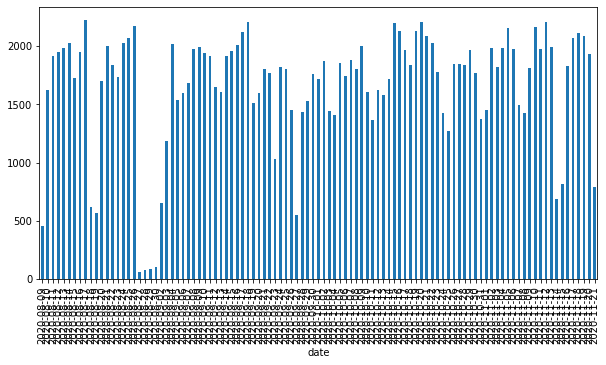

In [205]:
%%time 

def show_distribution(df: pd.DataFrame, group_column_name:str="date"):
    df.sort_values(by=[group_column_name], inplace=True)

    day_groups = df.groupby(df[group_column_name])[group_column_name].count()

    day_groups.plot(kind='bar', figsize=(10,5), legend=None)

show_distribution(df=df_twitter_raw)

In [206]:
%%time

df_booled = twitter_service.convert_to_bool(df=df_twitter_raw)
print(df_booled["date"].max())

2020-11-21
Wall time: 3.33 s


2020-11-21
93296
Wall time: 42.3 s


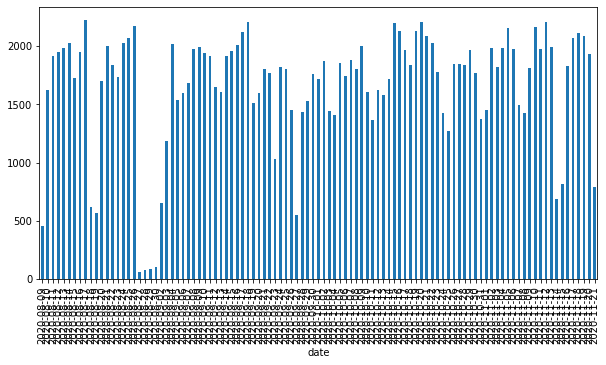

In [207]:
%%time
df_twitter = df_booled
del df_booled
def coerce_convert_to_numeric(df: pd.DataFrame, col: str):
    df[col] = pd.to_numeric(df[col], errors='coerce')
    df[col] = df[col].fillna(0)
    return df

df_twitter = coerce_convert_to_numeric(df=df_twitter, col="user_followers_count")
df_twitter = coerce_convert_to_numeric(df=df_twitter, col="f22_sentiment_compound")
df_twitter = coerce_convert_to_numeric(df=df_twitter, col="f22_compound_score")

df_stock_data = twitter_service.get_stock_data_for_twitter_companies(df_tweets=df_twitter, num_days_in_future=5)

print(df_twitter["date"].max())
print(df_stock_data.shape[0])

show_distribution(df=df_twitter)

In [208]:
df_rec_quart_drop = twitter_service.get_all_quarterly_data_for_twitter()

columns_fundy = list(df_rec_quart_drop.columns)

print(df_rec_quart_drop['calendardate'].max())

2020-12-31


In [209]:
%%time
from ams.services.equities import equity_fundy_service as efs
df_equity_fundies = efs.get_equity_fundies()

df_eq_fun_quarters = df_equity_fundies[df_equity_fundies["dimension"] == EquityFundaDimension.AsReportedQuarterly.value]
del df_equity_fundies

df_result = pd.merge(df_eq_fun_quarters, df_stock_data, on=["ticker"], how='outer', suffixes=[None, "_eq_fun"])

del df_eq_fun_quarters
del df_stock_data


Wall time: 7.98 s


In [210]:
df_drop_init = df_result.dropna(subset=["date"]).drop(columns="lastupdated_eq_fun")

df_drop_future = df_drop_init[df_drop_init["date"] > df_drop_init["calendardate"]]

df_drop_future = df_drop_future.sort_values(by=["ticker", "date", "calendardate"], ascending=False)

df_stock_and_quarter = df_drop_future.drop_duplicates(subset=["ticker", "date"], keep="first")
del df_drop_init
del df_drop_future
del df_result

gc.collect()

32760

In [211]:
df_stock_and_quarter.sort_values(by=["ticker", "date", "calendardate"], ascending=True).head(50)

,ticker,dimension,calendardate,datekey,reportperiod,lastupdated,accoci,assets,assetsavg,assetsc,assetsnc,assetturnover,bvps,capex,cashneq,cashnequsd,cor,consolinc,currentratio,de,debt,debtc,debtnc,debtusd,deferredrev,depamor,deposits,divyield,dps,ebit,ebitda,ebitdamargin,ebitdausd,ebitusd,ebt,eps,epsdil,epsusd,equity,equityavg,equityusd,ev,evebit,evebitda,fcf,fcfps,fxusd,gp,grossmargin,intangibles,intexp,invcap,invcapavg,inventory,investments,investmentsc,investmentsnc,liabilities,liabilitiesc,liabilitiesnc,marketcap,ncf,ncfbus,ncfcommon,ncfdebt,ncfdiv,ncff,ncfi,ncfinv,ncfo,ncfx,netinc,netinccmn,netinccmnusd,netincdis,netincnci,netmargin,opex,opinc,payables,payoutratio,pb,pe,pe1,ppnenet,prefdivis,price,ps,ps1,receivables,retearn,revenue,revenueusd,rnd,roa,roe,roic,ros,sbcomp,sgna,sharefactor,sharesbas,shareswa,shareswadil,sps,tangibles,taxassets,taxexp,taxliabilities,tbvps,workingcapital,date,open,high,low,close,volume,dividends,closeunadj,future_open,future_low,future_high,future_close,future_date,None
1789842,AACQ,ARQ,2020-09-30,2020-10-28,2020-09-30,2020-11-03,0.000000e+00,7.261300e+08,NaN,1.551950e+06,7.245781e+08,NaN,0.249,NaN,1.261683e+06,1.261683e+06,0.000000e+00,-6.218500e+04,99.420,5.075,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,NaN,0.0,0.000,0.0,-6.218500e+04,NaN,NaN,NaN,-6.218500e+04,-6.218500e+04,-0.01,-0.01,-0.01,5.000006e+06,NaN,5.000006e+06,8.699496e+08,NaN,NaN,NaN,NaN,1.0,0.0,NaN,0.000000e+00,0.0,7.248527e+08,NaN,0.000000e+00,7.245781e+08,0.000000e+00,724578087.0,2.537311e+07,1.561000e+04,2.535750e+07,8.712112e+08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-6.218500e+04,-6.218500e+04,-6.218500e+04,0.0,0.0,NaN,1.402720e+05,-1.402720e+05,0.000000e+00,0.0,174.242,NaN,NaN,0.000000e+00,0.0,9.620,NaN,NaN,0.000000e+00,-7.125400e+04,0.000000e+00,0.000000e+00,0.0,NaN,NaN,NaN,NaN,NaN,0.000000e+00,1.0,90562500.0,20071954.0,20071954.0,0.000,7.261300e+08,0.000000e+00,0.0,0.0,36.176,1.536340e+06,2020-11-11,9.700,9.750,9.700,9.740,2209.0,0.0,9.740,9.725,9.700,9.770,9.700,2020-11-12,NaN
1496,AAL,ARQ,2020-06-30,2020-07-23,2020-06-30,2020-10-22,-6.463000e+09,6.454400e+10,NaN,1.378900e+10,5.075500e+10,NaN,-6.231,-275000000.0,1.001000e+09,1.001000e+09,1.954000e+09,-2.067000e+09,0.766,-21.367,4.004900e+10,4.379000e+09,3.567000e+10,4.004900e+10,0.0,0.0,0.0,0.025,0.0,-2.405000e+09,-2.405000e+09,-1.483,-2.405000e+09,-2.405000e+09,-2.659000e+09,-4.82,-4.82,-4.82,-3.169000e+09,NaN,-3.169000e+09,4.503376e+10,-13.0,-43.177,-1.183000e+09,-2.326,1.0,-332000000.0,-0.205,6.140000e+09,254000000.0,7.945200e+10,NaN,1.653000e+09,9.351000e+09,9.351000e+09,0.0,6.771300e+10,1.800000e+10,4.971300e+10,5.985765e+09,-19000000.0,0.0,1.525000e+09,6.215000e+09,0.0,7.688000e+09,-6.799000e+09,-6.512000e+09,-9.080000e+08,0.0,-2.067000e+09,-2.067000e+09,-2.067000e+09,0.0,0.0,-1.274,2.154000e+09,-2.486000e+09,1.175000e+09,0.0,-1.889,-1.726,-1.441,4.167400e+10,0.0,11.770,0.179,0.179,8.790000e+08,-2.088000e+09,1.622000e+09,1.622000e+09,0.0,NaN,NaN,NaN,NaN,0.0,2.581000e+09,1.0,508561163.0,508561163.0,NaN,3.189,5.840400e+10,1.725000e+09,-592000000.0,0.0,114.842,-4.211000e+09,2020-08-11,15.020,15.100,13.550,13.730,126759332.0,0.0,13.730,14.030,13.100,14.060,13.540,2020-08-12,NaN
1497,AAL,ARQ,2020-06-30,2020-07-23,2020-06-30,2020-10-22,-6.463000e+09,6.454400e+10,NaN,1.378900e+10,5.075500e+10,NaN,-6.231,-275000000.0,1.001000e+09,1.001000e+09,1.954000e+09,-2.067000e+09,0.766,-21.367,4.004900e+10,4.379000e+09,3.567000e+10,4.004900e+10,0.0,0.0,0.0,0.025,0.0,-2.405000e+09,-2.405000e+09,-1.483,-2.405000e+09,-2.405000e+09,-2.659000e+09,-4.82,-4.82,-4.82,-3.169000e+09,NaN,-3.169000e+09,4.503376e+10,-13.0,-43.177,-1.183000e+09,-2.326,1.0,-332000000.0,-0.205,6.140000e+09,254000000.0,7.945200e+10,NaN,1.653000e+09,9.351000e+09,9.351000e+09,0.0,6.771300e+10,1.800000e+10,4.971300e+10,5.985765e+09,-19000000.0,0.0,1.525000e+09,6.215000e+09,0.0,7.688000e+09,-6.799000e+09,-6.512000e+09,-9.080000e+08,0.0,-2.067000e+09,-2.067000e+09,-2.067000e+09,0.0,0.0,-1.274,2.154000e+09,-

In [212]:
df_nas_tickers_info = ticker_service.get_nasdaq_tickers()

C:\Users\Chris\workspaces\alpha_media_signal\ams\services\ticker_service.py:273: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[c] = df[c].fillna("<unknown>")
C:\Users\Chris\workspaces\alpha_media_signal\ams\services\ticker_service.py:274: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[c] = df[c].astype(CategoricalDtype(uniques))


In [213]:
%time

col_ticker = "ticker_drop"

df_stock_quart_info = pd.merge(df_stock_and_quarter, df_nas_tickers_info, how='inner', left_on=["ticker"], right_on=[col_ticker])
df_nas_tickers_info = None
df_sqi = df_stock_quart_info.drop(columns=[col_ticker])
df_stock_quart_info = None

print(df_sqi.shape)
print(df_sqi["date"].max())
print(df_sqi["date"].min())

Wall time: 0 ns
(169237, 588)
2020-11-20
2020-08-10


In [214]:
%%time

df_stock_renamed = df_sqi.rename(columns={"ticker": "f22_ticker"})

if 'None' in df_stock_renamed.columns:
    df_stock_renamed = df_stock_renamed.drop(columns=['None'])

print(f'Twitter: {df_twitter.shape[0]}')

df_merged = pd.merge(df_twitter, df_stock_renamed, how='inner', left_on=["f22_ticker","date"], right_on=["f22_ticker","date"])
del df_twitter
del df_stock_renamed

print(f'Num merged: {df_merged.shape[0]}')
print(df_merged["date"].min())
print(df_merged["date"].max())

Twitter: 171058
Num merged: 169237
2020-08-10
2020-11-20
Wall time: 1.97 s


In [215]:
# show_distribution(df=df_result, group_column_name="calendardate")
from ams.utils import date_utils

df_days = df_merged
del df_merged

def num_days_from(from_date: str, to_date: str):
    from_dt = date_utils.parse_std_datestring(from_date)
    to_dt = date_utils.parse_std_datestring(to_date)
    
    return (to_dt - from_dt).days

df_days = df_days.dropna(axis="rows", subset=["datekey", "future_date"])

df_days["days_since"] = df_days.apply(lambda x: num_days_from(x["datekey"], x["future_date"]), axis=1)
df_days[["days_since", "calendardate", "datekey", "reportperiod"]].head(10)

,days_since,calendardate,datekey,reportperiod
0,11,2020-06-30,2020-07-31,2020-06-30
1,11,2020-06-30,2020-07-31,2020-06-30
2,-1,2020-06-30,2020-08-12,2020-06-30
3,-1,2020-06-30,2020-08-12,2020-06-30
4,11,2020-06-30,2020-07-31,2020-06-30
5,11,2020-06-30,2020-07-31,2020-06-30
6,29,2020-06-30,2020-07-13,2020-05-31
7,29,2020-06-30,2020-07-13,2020-05-31
8,-3,2020-06-30,2020-08-14,2020-06-30
9,-3,2020-06-30,2020-08-14,2020-06-30


In [216]:
%%time

df_days_of = df_days
del df_days

def day_of_week(date_str):
    return pd.Timestamp(date_str).dayofweek

df_days_of["fd_day_of_week"] = df_days_of.apply(lambda x: day_of_week(x["future_date"]), axis=1)

def day_of_year(date_str):
    return pd.Timestamp(date_str).dayofyear

df_days_of["fd_day_of_year"] = df_days_of.apply(lambda x: day_of_year(x["future_date"]), axis=1)

def day_of_month(date_str):
    return int(date_str.split("-")[2])

df_days_of["fd_day_of_month"] = df_days_of.apply(lambda x: day_of_month(x["future_date"]), axis=1)

Wall time: 12.9 s


In [217]:
df_roi_nasdaq = pd.read_parquet(constants.DAILY_ROI_NASDAQ_PATH)

df_roi_win = pd.merge(df_roi_nasdaq, df_days_of, on=["date"], how="right")

df_roi_win.head()

,date,roi,created_at,user_screen_name,favorite_count,in_reply_to_screen_name,user_verified,metadata_result_type,user_listed_count,user_time_zone,user_has_extended_profile,in_reply_to_status_id,user_statuses_count,user_protected,user_is_translation_enabled,user_location,lang,user_geo_enabled,place_country,place_name,possibly_sensitive,user_friends_count,retweet_count,user_follow_request_sent,user_followers_count,f22_ticker,f22_has_cashtag,f22_ticker_in_text,f22_num_other_tickers_in_tweet,f22_sentiment_pos,f22_sentiment_neu,f22_sentiment_neg,f22_sentiment_compound,f22_id,created_at_timestamp,f22_compound_score,dimension,calendardate,datekey,reportperiod,lastupdated,accoci,assets,assetsavg,assetsc,assetsnc,assetturnover,bvps,capex,cashneq,cashnequsd,cor,consolinc,currentratio,de,debt,debtc,debtnc,debtusd,deferredrev,depamor,deposits,divyield,dps,ebit,ebitda,ebitdamargin,ebitdausd,ebitusd,ebt,eps,epsdil,epsusd,equity,equityavg,equityusd,ev,evebit,evebitda,fcf,fcfps,fxusd,gp,grossmargin,intangibles,intexp,invcap,invcapavg,inventory,investments,investmentsc,investmentsnc,liabilities,liabilitiesc,liabilitiesnc,marketcap,ncf,ncfbus,ncfcommon,ncfdebt,ncfdiv,ncff,ncfi,ncfinv,ncfo,ncfx,netinc,netinccmn,netinccmnusd,netincdis,netincnci,netmargin,opex,opinc,payables,payoutratio,pb,pe,pe1,ppnenet,prefdivis,price,ps,ps1,receivables,retearn,revenue,revenueusd,rnd,roa,roe,roic,ros,sbcomp,sgna,sharefactor,sharesbas,shareswa,shareswadil,sps,tangibles,taxassets,taxexp,taxliabilities,tbvps,workingcapital,open,high,low,close,volume,dividends,closeunadj,future_open,future_low,future_high,future_close,future_date,table_SFP,table_SEP,table_<unknown>,table_SF3B,table_SF1,category_ETD,category_Domestic Common Stock Secondary Class,category_ADR Common Stock Secondary Class,category_Domestic Stock Warrant,category_<unknown>,category_ETN,category_ADR Stock Warrant,category_ADR Common Stock,category_Canadian Common Stock,category_ADR Preferred Stock,category_Canadian Stock Warrant,category_ETF,category_Domestic Common Stock Primary Class,category_CEF,category_Domestic Common Stock,category_Canadian Common Stock Primary Class,category_ADR Common Stock Primary Class,category_Domestic Preferred Stock,category_IDX,category_Canadian Preferred Stock,sicsector_Services,sicsector_Retail Trade,sicsector_Transportation Communications Electric Gas And Sanitary Service,sicsector_Manufacturing,sicsector_Construction,sicsector_<unknown>,sicsector_Mining,sicsector_Nonclassifiable,sicsector_Finance Insurance And Real Estate,sicsector_Agriculture Forestry And Fishing,sicsector_Public Administration,sicsector_Wholesale Trade,famaindustry_Business Supplies,famaindustry_Almost Nothing,famaindustry_Wholesale,famaindustry_Recreation,famaindustry_Healthcare,famaindustry_Medical Equipment,famaindustry_Automobiles and Trucks,famaindustry_Aircraft,famaindustry_Electronic Equipment,famaindustry_Rubber and Plastic Products,famaindustry_Printing and Publishing,famaindustry_Non-Metallic and Industrial Metal Mining,famaindustry_Construction Materials,famaindustry_<unknown>,famaindustry_Textiles,famaindustry_Construction,famaindustry_Retail,famaindustry_Precious Metals,famaindustry_Shipbuilding Railroad Equipment,famaindustry_Apparel,famaindustry_Real Estate,famaindustry_Computers,famaindustry_Banking,famaindustry_Agriculture,famaindustry_Entertainment,famaindustry_Insurance,famaindustry_Pharmaceutical Products,famaindustry_Transportation,famaindustry_Petroleum and Natural Gas,famaindustry_Steel Works Etc,famaindustry_Shipping Containers,famaindustry_Tobacco Products,famaindustry_Chemicals,famaindustry_Electrical Equipment,famaindustry_Measuring and Control Equipment,famaindustry_Fabricated Products,famaindustry_Communication,famaindustry_Utilities,famaindustry_Restaraunts Hotels Motels,famaindustry_Consumer Goods,famaindustry_Machinery,famaindustry_Food Products,famaindustry_Beer & Liquor,famaindustry_Candy & Soda,famaindustry_Defense,famaindustry_Coal,famaindustry_Personal Services,fama

In [218]:
%%time

df_thin_rabbit = twitter_service.add_buy_sell(df=df_roi_win)
# del df_days_of

df_thin_rabbit.drop_duplicates(subset=["f22_ticker", "date", "roi"])[["f22_ticker", "date", "roi", "stock_val_change", "stock_val_change_ex"]].head()

Wall time: 592 ms


,f22_ticker,date,roi,stock_val_change,stock_val_change_ex
0,PCH,2020-08-10,-0.018281,0.028724,-0.005468
2,XPEL,2020-08-10,-0.018281,0.043591,-0.005467
4,CG,2020-08-10,-0.018281,0.009093,-0.005469
6,EDUC,2020-08-10,-0.018281,-0.013724,-0.005469
8,CFRX,2020-08-10,-0.018281,-0.042801,-0.005470


In [219]:
df_thin_rabbit["original_close_price"] = df_thin_rabbit["close"]
df_thin_rabbit["date"].max()
print(f'Num df_thin_rabbit: {df_thin_rabbit.shape[0]}')

Num df_thin_rabbit: 169237


In [220]:
def save_twitter_stock_join(df: pd.DataFrame):
    sorted(list(df.columns))

    file_path_str = str(Path(constants.OVERFLOW_DATA_PATH, "twitter", "inference_model_drop", "twitter_id_with_label.parquet"))

    df.to_parquet(file_path_str)
    
# save_twitter_stock_join(df=df_thin_rabbit)

In [221]:
%%time
cols_fundy_numeric = list(set(columns_fundy) - {"ticker", 'calendardate', 'datekey', 'reportperiod'})

df_no_z = twitter_service.fill_null_numeric(df=df_thin_rabbit, cols_fundy_numeric=cols_fundy_numeric)
del df_thin_rabbit

Wall time: 793 ms


In [222]:
%%time

df_after_hours = twitter_service.add_is_tweet_after_hours(df=df_no_z)
del df_no_z

Wall time: 11.8 s


In [223]:
%%time
from ams.utils import ticker_utils

df_sma = ticker_utils.add_sma_history(df=df_after_hours, target_column="close", windows=[15, 20, 50, 100, 200])

Wall time: 30.7 s


In [224]:
%%time
df_since_sma = ticker_utils.add_days_since_under_sma_many_tickers(df=df_sma, col_sma="close_SMA_200", close_col="close")
df_since_sma = ticker_utils.add_days_since_under_sma_many_tickers(df=df_since_sma, col_sma="close_SMA_15", close_col="close")
df_since_sma = ticker_utils.add_days_since_under_sma_many_tickers(df=df_since_sma, col_sma="close_SMA_20", close_col="close")
df_since_sma = ticker_utils.add_days_since_under_sma_many_tickers(df=df_since_sma, col_sma="close_SMA_50", close_col="close")
df_since_sma = ticker_utils.add_days_since_under_sma_many_tickers(df=df_since_sma, col_sma="close_SMA_100", close_col="close")

Wall time: 1min 16s


In [225]:
%%time

df_pay = twitter_service.add_purchase_date(df=df_since_sma)
del df_since_sma
del df_sma
df_pay["date"].max()

Wall time: 330 ms


'2020-11-20'

In [226]:
%%time

df_days_until = ticker_service.add_days_until_sale(df=df_pay)
# del df_pay

Wall time: 6.61 s


In [227]:
class SplitData():
    X_train = None
    y_train = None
    X_test = None
    y_test = None
    df_test_raw = None
    df_test_std = None
    train_cols = None
    has_enough_data = None
    
    def __init__(self, 
                 X_train: np.array,
                 y_train: np.array,
                 X_test: np.array,
                 y_test: np.array,
                 df_test_raw: pd.DataFrame,
                 df_test_std: pd.DataFrame,
                 df_val_raw: pd.DataFrame,
                 df_val_std: pd.DataFrame,
                 train_cols: List[str],
                 has_enough_data: bool
                ):
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.df_test_raw = df_test_raw
        self.df_test_std = df_test_std
        self.df_val_raw = df_val_raw
        self.df_val_std = df_val_std
        self.train_cols = train_cols
        self.has_enough_data = has_enough_data

In [228]:
def has_f22_column(df: pd.DataFrame):
    cols = [c for c in df.columns if c.startswith("f22")]
    print(cols)

def split_off_data_new(df: pd.DataFrame, narrow_cols: List[str], tickers: List[str] = None, use_recent_for_holdout = True) -> SplitData :
    df_samp, df_val_raw = twitter_service.ho_split_by_days(df, 
                                                            small_data_days_to_pull=None, 
                                                            small_data_frac=.025, 
                                                            use_only_recent_for_holdout=use_recent_for_holdout)
        
    X_train = None
    y_train = None
    X_test = None
    y_test = None
    df_test_raw = None
    df_test_std = None
    df_val_std = None
    train_cols = None
    
    
    has_enough_data = df_samp is not None and df_val_raw is not None and df_val_raw.shape[0] > 500
    if has_enough_data:

        df_shuff = df_samp.sample(frac=1.0)

        df_train_raw, df_test_raw = twitter_service.ho_split_by_days(df_shuff, small_data_days_to_pull=None, small_data_frac=.2, use_only_recent_for_holdout=use_recent_for_holdout) #        

        has_enough_data = df_train_raw is not None and df_test_raw is not None and df_test_raw.shape[0] > 500
        if has_enough_data:
            print(f"Original: {df.shape[0]}; train_set: {df_train_raw.shape[0]}; test_set: {df_test_raw.shape[0]}")

            df_train_std, df_test_std, df_val_std = ticker_service.std_dataframe(df_train=df_train_raw, df_test=df_test_raw, df_val=df_val_raw)

            X_train, y_train, X_test, y_test, train_cols = twitter_service.split_train_test(train_set=df_train_std, test_set=df_test_std, narrow_cols=narrow_cols, label_col="stock_val_change")

        return SplitData(X_train=X_train,
                       y_train=y_train,
                       X_test=X_test,
                       y_test=y_test,
                       df_test_raw=df_test_raw,
                       df_test_std=df_test_std,
                       df_val_raw=df_val_raw,
                       df_val_std=df_val_std,
                       train_cols=train_cols,
                       has_enough_data=has_enough_data)
    if not has_enough_data:
        print("Not enough data.")

In [229]:
%%time

min_volume = None
min_price = None
max_price = None

# min_volume = 100000
# min_price = 5.00
# max_price = 3.

# min_volume = None
# min_price = None
# max_price = 3.

df = twitter_service.refine_pool(df=df_days_until, min_volume=min_volume, min_price=min_price, max_price=max_price)
df = twitter_service.omit_columns(df=df)
df_tweet_counted = twitter_service.add_tweet_count(df=df).drop(columns=["calendardate", "reportperiod", "dimension", "datekey"])

del df

Wall time: 32.8 s


In [230]:
# Add col = calc dividend as prop of price
# drop all location prefixed tweets

In [231]:
from matplotlib.legend_handler import HandlerLine2D
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
import numpy as np

def randy_forest(X_train: np.array, y_train: np.array, X_test: np.array, y_test: np.array):
    n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200]
    train_results = []
    test_results = []

    for estimator in n_estimators:
        rf = RandomForestClassifier(n_estimators=estimator, n_jobs=-1)
        rf.fit(X_train, y_train)
        train_pred = rf.predict(X_train)
        from sklearn.metrics import roc_curve
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
        from sklearn.metrics import auc
        roc_auc = auc(false_positive_rate, true_positive_rate)
        train_results.append(roc_auc)
        y_pred = rf.predict(X_test)
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        test_results.append(roc_auc)

    line1, = plt.plot(n_estimators, train_results, 'b', label="Train AUC")
    line2, = plt.plot(n_estimators, test_results, 'r', label="Test AUC")
    plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
    plt.ylabel('AUC score')
    plt.xlabel('n_estimators')
    plt.show()

In [232]:
def rnd_forest_clf(X_train: np.array, y_train: np.array, X_test: np.array, y_test: np.array):
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.metrics import accuracy_score

    rf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
     max_depth=None, max_features='auto', max_leaf_nodes=None,
     min_impurity_split=1e-07, min_samples_leaf=1,
     min_samples_split=2, min_weight_fraction_leaf=0.0,
     n_estimators=1, n_jobs=1, oob_score=False, random_state=None,
     verbose=0, warm_start=False)
    rf.fit(X=X_train, y=y_train)

    y_test_pred = rf.predict(X_test)

    print(accuracy_score(y_test, y_test_pred))

    return rf

In [233]:
def find_columns_with_value(df: pd.DataFrame, value_to_find: any):
    col_matched = []
    for c in df.columns:
        df = df[df[c] == value_to_find]
        if df.shape[0] > 0:
            col_matched.append(c)

    return col_matched

In [234]:
cols = list(df_tweet_counted.columns)

# cols = [c for c in cols if not c.startswith("location_")]
# cols = [c for c in cols if not c.startswith("currency_")]
# cols = [c for c in cols if not c.startswith("industry_")]
# cols = [c for c in cols if not c.startswith("famaindustry_")]
# cols = [c for c in cols if not c.startswith("category_")]
# cols = [c for c in cols if not c.startswith("sector_")]
# cols = [c for c in cols if not c.startswith("scalerevenue_")]
# cols = [c for c in cols if not c.startswith("table_")]
# cols = [c for c in cols if not c.startswith("sicsector_")]
# cols = [c for c in cols if not c.startswith("scalemarketcap_")]

# cols = list(set(cols) - {'sharesbas', 'sps', 'ps', 'receivables', 'debtnc', 'invcap', 'sbcomp', 'workingcapital',
#                         'taxliabilities', 'ebt', 'retearn', 'accoci', 'invcapavg', 'liabilitiesnc', 'pb', 'taxassets',
#                          'revenueusd', 'price', 'netincdis', 'sharefactor', 'netmargin', 'ncfcommon', 'investmentsc', 'opinc',
#                          'inventory', 'eps', 'de', 'sgna', 'siccode', 'fxusd', 'revenue', 'opex', 'cashnequsd', 'tbvps', 'shareswa', 
#                          'ros', 'evebitda', 'ncfdebt', 'consolinc', 'ncfinv', 'deposits', 'marketcap', 'ev', 'roe', 'payoutratio',
#                          'investmentsnc', 'equity', 'roa', 'divyield', 'investmentsnc', 'equity', 'roa', 'divyield', 'ps1', 
#                          'shareswadil', 'liabilitiesc', 'gp', 'tangibles', 'epsusd', 'assetsnc', 'ppnenet', 'epsdil', 'ncfdiv',
#                           'ncfi', 'payables', 'fcfps', 'investments', 'cashneq', 'roic', 'currentratio', 'ebit', 'ebitda', 
#                          'volume', 'ncfo', 'netinc', 'netinccmn', 'debt', 'pe', 'debtc', 'rnd', 'evebit', 'ebitusd', 'netincnci', 
#                          'assetsc', 'assetsavg', 'assetturnover', 'taxexp', 'ebitdausd', 'liabilities', 'capex', 'prefdivis',
#                          'netinccmnusd', 'depamor', 'famasector', 'dps', 'assets', 'fcf', 'ebitdamargin', 'equityusd', 'ncfx', 
#                          'ncfbus', 'equityavg', 'dividends', 'cor', 'grossmargin', 'ncff', 'intangibles', 'debtusd', 'bvps', 'pe1',
#                          'intexp', 'ncf'
#                         })
# print(f"Total cols: {len(cols)}")

col_drop = set(df_tweet_counted.columns) - set(cols)

df_winnowed = df_tweet_counted.drop(columns=col_drop).reset_index(drop=True)

narrow_cols = list(df_winnowed.columns)
print(narrow_cols)

df_winnowed = twitter_service.add_buy_sell(df=df_winnowed)

max_val = df_winnowed["stock_val_change_ex"].max()
min_val = df_winnowed["stock_val_change_ex"].min()


print(f"{max_val}: {min_val}")


['sector_Consumer Defensive', 'category_Canadian Stock Warrant', 'location_California; U.S.A', 'industry_Oil & Gas Refining & Marketing', "location_Democratic People'S Republic Of Korea", 'industry_Savings & Cooperative Banks', 'industry_Building Products & Equipment', 'currency_MXN', 'fd_day_of_year', 'industry_Real Estate - General', 'industry_Textile Manufacturing', 'industry_Semiconductor Memory', 'location_Hong Kong', 'industry_Consumer Electronics', 'industry_Specialty Chemicals', 'industry_Business Equipment & Supplies', 'ncfcommon', 'famaindustry_Personal Services', 'future_low', 'industry_Utilities - Diversified', 'currency_ILS', 'f22_sentiment_neu', 'location_Maryland; U.S.A', 'famaindustry_Communication', 'cashneq', 'user_follow_request_sent', 'debt', 'industry_Apparel Stores', 'location_Ireland', 'sicsector_Finance Insurance And Real Estate', 'location_Jordan', 'de', 'industry_Insurance - Life', 'ncfinv', 'category_ADR Common Stock Primary Class', 'industry_Oil & Gas Midstr

In [235]:
df_tip_ranks = pd.read_parquet(str(tr_file_path))
df_tip_ranks = df_tip_ranks.rename(columns={"ticker": "f22_ticker"})

df_ranked = pd.merge(df_winnowed, df_tip_ranks, on=["date", "f22_ticker"], how="left")

def rank_roied(row):
    close = row["close"]
    target_price = row["target_price"]
    rank_roi = None
    
    if target_price is None:
        target_price = close + .01
        
    target_price = row["target_price"]
    rank_roi = (target_price - close)/close
        
    return rank_roi

df_ranked["rank_roi"] = df_ranked.apply(rank_roied, axis=1)

rating_mean = df_tip_ranks["rating"].mean()
rank_mean = df_tip_ranks["rank"].mean()
rating_age_days_mean = df_tip_ranks["rating_age_days"].mean()

df_ranked["rating"] = df_ranked["rating"].fillna(0)
df_ranked["rank"] = df_ranked["rank"].fillna(rank_mean)
df_ranked["rating_age_days"] = df_ranked["rating_age_days"].fillna(1000)

narrow_cols = list(df_ranked.columns)
df_tip_ranks.head()

,rating,rank,rating_age_days,target_price,f22_ticker,date
0,0.80,3.28,45.00,48.0920,ALLO,2020-08-09
1,0.25,4.65,58.75,238.0000,COUP,2020-08-09
2,1.00,4.60,19.00,47.0000,GO,2020-08-09
3,0.50,4.40,21.50,94.5000,DDOG,2020-08-09
4,1.00,4.40,48.00,15.9375,ARCC,2020-08-09


In [236]:
df_skinny = df_ranked.drop_duplicates(subset=["f22_ticker", "date"])

In [243]:
%%time
import random
from ams.notebooks.twitter import twitter_ml_utils
from sklearn.metrics import plot_confusion_matrix

use_regression = True

# raise Exception("Add time data Monday, Tuesday, first of month, etc.")
# Add technical details? 20MA, etc?

def find_ml_pred_perf(df: pd.DataFrame):
    zero_in = True
    if zero_in:
        target_roi_frac = 0.06
    else:
        target_roi_frac = .001

    print(f"Count: {df.shape[0]}")

    use_rnd_forest = True

    all_avgs = []

    tickers = df["f22_ticker"].unique().tolist()
    random.shuffle(tickers)

    sac_roi_list = []

    count = 0
    while True:
        sd = twitter_ml_utils.split_off_data(df=df, narrow_cols=narrow_cols, use_recent_for_holdout=True)
        if sd and sd.has_enough_data:
            X_train = sd.X_train
            y_train = sd.y_train
            X_test = sd.X_test
            y_test = sd.y_test
            df_test_raw = sd.df_test_raw
            df_test_std = sd.df_test_std
            df_val_raw = sd.df_val_raw
            df_val_std = sd.df_val_std
            train_cols = sd.train_cols
            has_enough_data = sd.has_enough_data
            
            if df_test_raw.shape[0] == 0:
                raise Exception("No holdout data.")

            if use_rnd_forest:

                if use_regression:
                    model = twitter_service.dec_tree_regressor(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, max_depth=16)
                else:
                    # randy_forest(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)
                    # model = rnd_forest_clf(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)
                    model = twitter_service.dec_tree(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, max_depth=16) 
    
                acc_model = model
            else:
                acc_model = twitter_service.train_mlp(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)
                
            df_splitted = twitter_service.join_with_stock_splits(df=df_val_raw)
            
            if use_regression:
                g_tickers, group_preds = twitter_ml_utils.group_and_mean_preds_regress(df_val_std, acc_model, train_cols)
            else:
                g_tickers, group_preds = twitter_ml_utils.group_and_mean_preds_buy_sell(df_val_std, acc_model, train_cols)

            roi_list, sac_roi, trade_history = twitter_ml_utils.get_roi_matrix(df=df_splitted, group_preds=group_preds, target_roi_frac=target_roi_frac, zero_in=zero_in)
            
            overwrite_existing = True if count == 0 else False
            twitter_ml_utils.persist_trade_history(twitter_trades=trade_history, overwrite_existing=True)
            
            if len(roi_list) > 0:
                max_avg = max(roi_list)
                all_avgs.append(max_avg)

            if sac_roi is not None:
                sac_roi_list.append(sac_roi)
            
            if len(all_avgs) > 0 and len(sac_roi_list) > 0:
                print(f"Cumulative Metrics: Avg Best Sell@High ROI rate: {mean(all_avgs)} | Avg Sell@Close ROI: {mean(sac_roi_list)} ")

        df, has_remaining_days = twitter_service.remove_last_days(df=df, num_days=1)

        if not has_remaining_days:
            print("No more remaining days to test.")
            break
            
        count += 1
        
    return sac_roi_list
            
ml_pred_fraction = 1.0
df_4_model = df_skinny.sample(frac=ml_pred_fraction)
sac_roi_list = find_ml_pred_perf(df=df_4_model)

Count: 84634
Split | min: 2020-08-10 | max: 2020-11-23
Split dates for small dataset: ['2020-11-21', '2020-11-22', '2020-11-23']
Not enough data.
Split | min: 2020-08-10 | max: 2020-11-20
Split dates for small dataset: ['2020-11-18', '2020-11-19', '2020-11-20']
Split | min: 2020-08-10 | max: 2020-11-17
Split dates for small dataset: ['2020-10-29', '2020-10-30', '2020-10-31', '2020-11-01', '2020-11-02', '2020-11-03', '2020-11-04', '2020-11-05', '2020-11-06', '2020-11-07', '2020-11-08', '2020-11-09', '2020-11-10', '2020-11-11', '2020-11-12', '2020-11-13', '2020-11-14', '2020-11-15', '2020-11-16', '2020-11-17']
Original: 84282; train_set: 62551; test_set: 17696


C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


0.5273279352226721
Mean: 0.3333333333333333
Avg investment per trade: 51.48779911699778
Roi per trade: 0.0027
Num trades: 453 | acc: 0.53863 | s@close roi: 0.009826188182654788 | s@high roi: 0.035294
Sell high/close roi@0.06: 0.006656; weight: 3.015013942220213
Cumulative Metrics: Avg Best Sell@High ROI rate: 0.006655659916600912 | Avg Sell@Close ROI: 0.009826188182654788 
Split | min: 2020-08-10 | max: 2020-11-19
Split dates for small dataset: ['2020-11-17', '2020-11-18', '2020-11-19']
Split | min: 2020-08-10 | max: 2020-11-16
Split dates for small dataset: ['2020-10-28', '2020-10-29', '2020-10-30', '2020-10-31', '2020-11-01', '2020-11-02', '2020-11-03', '2020-11-04', '2020-11-05', '2020-11-06', '2020-11-07', '2020-11-08', '2020-11-09', '2020-11-10', '2020-11-11', '2020-11-12', '2020-11-13', '2020-11-14', '2020-11-15', '2020-11-16']
Original: 82930; train_set: 61414; test_set: 17537


C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


0.5301923968474733
Mean: 0.3210332103321033
Avg investment per trade: 54.03257564575643
Roi per trade: 0.0007
Num trades: 542 | acc: 0.50369 | s@close roi: 0.005285246141522449 | s@high roi: 0.030736
Sell high/close roi@0.06: 0.003602; weight: 1.9521580302991612
Cumulative Metrics: Avg Best Sell@High ROI rate: 0.00512871375008935 | Avg Sell@Close ROI: 0.0075557171620886186 
Split | min: 2020-08-10 | max: 2020-11-18
Split dates for small dataset: ['2020-11-16', '2020-11-17', '2020-11-18']
Split | min: 2020-08-10 | max: 2020-11-13
Split dates for small dataset: ['2020-10-26', '2020-10-27', '2020-10-28', '2020-10-29', '2020-10-30', '2020-10-31', '2020-11-01', '2020-11-02', '2020-11-03', '2020-11-04', '2020-11-05', '2020-11-06', '2020-11-07', '2020-11-08', '2020-11-09', '2020-11-10', '2020-11-11', '2020-11-12', '2020-11-13']
Original: 81556; train_set: 59273; test_set: 18654


C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


0.5160360948032181
Mean: 0.47619047619047616
Avg investment per trade: 10.75965714285714
Roi per trade: -0.0008
Num trades: 105 | acc: 0.57143 | s@close roi: 0.02811484811762609 | s@high roi: 0.031191
Sell high/close roi@0.06: 0.010175; weight: 1.068413884554816
Cumulative Metrics: Avg Best Sell@High ROI rate: 0.006810932609757395 | Avg Sell@Close ROI: 0.014408760813934442 
Split | min: 2020-08-10 | max: 2020-11-17
Split dates for small dataset: ['2020-11-15', '2020-11-16', '2020-11-17']
Split | min: 2020-08-10 | max: 2020-11-13
Split dates for small dataset: ['2020-10-26', '2020-10-27', '2020-10-28', '2020-10-29', '2020-10-30', '2020-10-31', '2020-11-01', '2020-11-02', '2020-11-03', '2020-11-04', '2020-11-05', '2020-11-06', '2020-11-07', '2020-11-08', '2020-11-09', '2020-11-10', '2020-11-11', '2020-11-12', '2020-11-13']
Original: 80247; train_set: 59273; test_set: 18654


C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


0.4991846053489889
Mean: 0.3352941176470588
Avg investment per trade: 45.81884411764708
Roi per trade: 0.0034
Num trades: 340 | acc: 0.45588 | s@close roi: 0.003183698041551652 | s@high roi: 0.029501
Sell high/close roi@0.06: 0.000646; weight: 0.21950894249699845
Cumulative Metrics: Avg Best Sell@High ROI rate: 0.005269603091507016 | Avg Sell@Close ROI: 0.011602495120838744 
Split | min: 2020-08-10 | max: 2020-11-16
Split dates for small dataset: ['2020-11-14', '2020-11-15', '2020-11-16']
Split | min: 2020-08-10 | max: 2020-11-13
Split dates for small dataset: ['2020-10-26', '2020-10-27', '2020-10-28', '2020-10-29', '2020-10-30', '2020-10-31', '2020-11-01', '2020-11-02', '2020-11-03', '2020-11-04', '2020-11-05', '2020-11-06', '2020-11-07', '2020-11-08', '2020-11-09', '2020-11-10', '2020-11-11', '2020-11-12', '2020-11-13']
Original: 78951; train_set: 59273; test_set: 18654


C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


0.5007066753642097
Mean: 0.45454545454545453
Avg investment per trade: 57.89493006993006
Roi per trade: 0.0079
Num trades: 143 | acc: 0.58042 | s@close roi: 0.014513701638227051 | s@high roi: 0.030221
Sell high/close roi@0.06: 0.008495; weight: 1.214844860403645
Cumulative Metrics: Avg Best Sell@High ROI rate: 0.005914766194049871 | Avg Sell@Close ROI: 0.012184736424316406 
Split | min: 2020-08-10 | max: 2020-11-13
Split dates for small dataset: ['2020-11-11', '2020-11-12', '2020-11-13']
Split | min: 2020-08-10 | max: 2020-11-10
Split dates for small dataset: ['2020-10-23', '2020-10-24', '2020-10-25', '2020-10-26', '2020-10-27', '2020-10-28', '2020-10-29', '2020-10-30', '2020-10-31', '2020-11-01', '2020-11-02', '2020-11-03', '2020-11-04', '2020-11-05', '2020-11-06', '2020-11-07', '2020-11-08', '2020-11-09', '2020-11-10']
Original: 77927; train_set: 57975; test_set: 15813


C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


0.5314408210991295
Mean: 0.46601941747572817
Avg investment per trade: 13.296970873786403
Roi per trade: -0.0028
Num trades: 103 | acc: 0.48544 | s@close roi: 0.0025463935265960663 | s@high roi: 0.034515
Sell high/close roi@0.06: 0.007361; weight: 0.758217466259333
Cumulative Metrics: Avg Best Sell@High ROI rate: 0.006155860932354396 | Avg Sell@Close ROI: 0.010578345941363016 
Split | min: 2020-08-10 | max: 2020-11-12
Split dates for small dataset: ['2020-11-10', '2020-11-11', '2020-11-12']
Split | min: 2020-08-10 | max: 2020-11-09
Split dates for small dataset: ['2020-10-22', '2020-10-23', '2020-10-24', '2020-10-25', '2020-10-26', '2020-10-27', '2020-10-28', '2020-10-29', '2020-10-30', '2020-10-31', '2020-11-01', '2020-11-02', '2020-11-03', '2020-11-04', '2020-11-05', '2020-11-06', '2020-11-07', '2020-11-08', '2020-11-09']
Original: 76447; train_set: 56690; test_set: 15640


C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


0.5198376325782376
Mean: 0.4461387112641417
Avg investment per trade: 46.75401770782095
Roi per trade: 0.0024
Num trades: 2033 | acc: 0.45893 | s@close roi: 0.0017992803630294415 | s@high roi: 0.033634
Sell high/close roi@0.06: 0.00045; weight: 0.9145936503643125
Cumulative Metrics: Avg Best Sell@High ROI rate: 0.005340719928551981 | Avg Sell@Close ROI: 0.00932419371588679 
Split | min: 2020-08-10 | max: 2020-11-11
Split dates for small dataset: ['2020-11-09', '2020-11-10', '2020-11-11']
Split | min: 2020-08-10 | max: 2020-11-06
Split dates for small dataset: ['2020-10-20', '2020-10-21', '2020-10-22', '2020-10-23', '2020-10-24', '2020-10-25', '2020-10-26', '2020-10-27', '2020-10-28', '2020-10-29', '2020-10-30', '2020-10-31', '2020-11-01', '2020-11-02', '2020-11-03', '2020-11-04', '2020-11-05', '2020-11-06']
Original: 75135; train_set: 53852; test_set: 17424


C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


0.5311013320647003
Mean: 0.4786392405063291
Avg investment per trade: 56.104765031645506
Roi per trade: 0.0006
Num trades: 1264 | acc: 0.50158 | s@close roi: 0.007227755293904482 | s@high roi: 0.040637
Sell high/close roi@0.06: 0.004132; weight: 5.222345149201133
Cumulative Metrics: Avg Best Sell@High ROI rate: 0.005189580209358095 | Avg Sell@Close ROI: 0.009062138913139003 
Split | min: 2020-08-10 | max: 2020-11-10
Split dates for small dataset: ['2020-11-08', '2020-11-09', '2020-11-10']
Split | min: 2020-08-10 | max: 2020-11-06
Split dates for small dataset: ['2020-10-20', '2020-10-21', '2020-10-22', '2020-10-23', '2020-10-24', '2020-10-25', '2020-10-26', '2020-10-27', '2020-10-28', '2020-10-29', '2020-10-30', '2020-10-31', '2020-11-01', '2020-11-02', '2020-11-03', '2020-11-04', '2020-11-05', '2020-11-06']
Original: 73788; train_set: 53852; test_set: 17424


C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


0.5268791627021884
Mean: 0.5364583333333334
Avg investment per trade: 53.254471354166725
Roi per trade: -0.0031
Num trades: 768 | acc: 0.57552 | s@close roi: 0.010875321386670883 | s@high roi: 0.046406
Sell high/close roi@0.06: 0.009544; weight: 7.329421390370072
Cumulative Metrics: Avg Best Sell@High ROI rate: 0.005673351012249162 | Avg Sell@Close ROI: 0.009263603632420323 
Split | min: 2020-08-10 | max: 2020-11-09
Split dates for small dataset: ['2020-11-07', '2020-11-08', '2020-11-09']
Split | min: 2020-08-10 | max: 2020-11-06
Split dates for small dataset: ['2020-10-20', '2020-10-21', '2020-10-22', '2020-10-23', '2020-10-24', '2020-10-25', '2020-10-26', '2020-10-27', '2020-10-28', '2020-10-29', '2020-10-30', '2020-10-31', '2020-11-01', '2020-11-02', '2020-11-03', '2020-11-04', '2020-11-05', '2020-11-06']
Original: 72330; train_set: 53852; test_set: 17424


C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


0.5089200761179828
Mean: 0.6063218390804598
Avg investment per trade: 72.79396264367816
Roi per trade: -0.0174
Num trades: 348 | acc: 0.65517 | s@close roi: 0.014716126370839107 | s@high roi: 0.059756
Sell high/close roi@0.06: 0.01278; weight: 4.447582979679132
Cumulative Metrics: Avg Best Sell@High ROI rate: 0.006384056997138939 | Avg Sell@Close ROI: 0.0098088559062622 
Split | min: 2020-08-10 | max: 2020-11-06
Split dates for small dataset: ['2020-11-04', '2020-11-05', '2020-11-06']
Split | min: 2020-08-10 | max: 2020-11-03
Split dates for small dataset: ['2020-10-18', '2020-10-19', '2020-10-20', '2020-10-21', '2020-10-22', '2020-10-23', '2020-10-24', '2020-10-25', '2020-10-26', '2020-10-27', '2020-10-28', '2020-10-29', '2020-10-30', '2020-10-31', '2020-11-01', '2020-11-02', '2020-11-03']
Original: 71276; train_set: 52442; test_set: 14943


C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


0.4948518157784889
Mean: 0.48120300751879697
Avg investment per trade: 17.02098496240601
Roi per trade: 0.0082
Num trades: 133 | acc: 0.52632 | s@close roi: 0.004134484055039332 | s@high roi: 0.045139
Sell high/close roi@0.06: 0.003415; weight: 0.4541426435642001
Cumulative Metrics: Avg Best Sell@High ROI rate: 0.0061141069376343055 | Avg Sell@Close ROI: 0.009293003919787395 
Split | min: 2020-08-10 | max: 2020-11-05
Split dates for small dataset: ['2020-11-03', '2020-11-04', '2020-11-05']
Split | min: 2020-08-10 | max: 2020-11-02
Split dates for small dataset: ['2020-10-17', '2020-10-18', '2020-10-19', '2020-10-20', '2020-10-21', '2020-10-22', '2020-10-23', '2020-10-24', '2020-10-25', '2020-10-26', '2020-10-27', '2020-10-28', '2020-10-29', '2020-10-30', '2020-10-31', '2020-11-01', '2020-11-02']
Original: 69944; train_set: 52442; test_set: 13742


C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


0.495773782080836
Mean: 0.5454545454545454
Avg investment per trade: 12.928123966942145
Roi per trade: 0.0196
Num trades: 121 | acc: 0.52893 | s@close roi: 0.007781180412625421 | s@high roi: 0.03866
Sell high/close roi@0.06: 0.005775; weight: 0.6988132568901448
Cumulative Metrics: Avg Best Sell@High ROI rate: 0.006085874373885265 | Avg Sell@Close ROI: 0.009167018627523896 
Split | min: 2020-08-10 | max: 2020-11-04
Split dates for small dataset: ['2020-11-02', '2020-11-03', '2020-11-04']
Split | min: 2020-08-10 | max: 2020-10-30
Split dates for small dataset: ['2020-10-14', '2020-10-15', '2020-10-16', '2020-10-17', '2020-10-18', '2020-10-19', '2020-10-20', '2020-10-21', '2020-10-22', '2020-10-23', '2020-10-24', '2020-10-25', '2020-10-26', '2020-10-27', '2020-10-28', '2020-10-29', '2020-10-30']
Original: 68591; train_set: 48427; test_set: 16526


C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


0.5109108827256089
Mean: 0.6219298245614036
Avg investment per trade: 51.22350789473685
Roi per trade: 0.0199
Num trades: 1140 | acc: 0.69474 | s@close roi: 0.017500699770843033 | s@high roi: 0.041207
Sell high/close roi@0.06: 0.01597; weight: 18.205273280105292
Cumulative Metrics: Avg Best Sell@High ROI rate: 0.0068461561885867555 | Avg Sell@Close ROI: 0.00980807102316383 
Split | min: 2020-08-10 | max: 2020-11-03
Split dates for small dataset: ['2020-11-01', '2020-11-02', '2020-11-03']
Split | min: 2020-08-10 | max: 2020-10-30
Split dates for small dataset: ['2020-10-14', '2020-10-15', '2020-10-16', '2020-10-17', '2020-10-18', '2020-10-19', '2020-10-20', '2020-10-21', '2020-10-22', '2020-10-23', '2020-10-24', '2020-10-25', '2020-10-26', '2020-10-27', '2020-10-28', '2020-10-29', '2020-10-30']
Original: 67385; train_set: 48427; test_set: 16526


C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


0.49732507391243136
Mean: 0.6120959332638165
Avg investment per trade: 49.98187278415015
Roi per trade: 0.0166
Num trades: 959 | acc: 0.70699 | s@close roi: 0.0169582363353574 | s@high roi: 0.04102
Sell high/close roi@0.06: 0.016805; weight: 16.11607508735888
Cumulative Metrics: Avg Best Sell@High ROI rate: 0.007557508140210782 | Avg Sell@Close ROI: 0.010318797116891943 
Split | min: 2020-08-10 | max: 2020-11-02
Split dates for small dataset: ['2020-10-31', '2020-11-01', '2020-11-02']
Split | min: 2020-08-10 | max: 2020-10-30
Split dates for small dataset: ['2020-10-14', '2020-10-15', '2020-10-16', '2020-10-17', '2020-10-18', '2020-10-19', '2020-10-20', '2020-10-21', '2020-10-22', '2020-10-23', '2020-10-24', '2020-10-25', '2020-10-26', '2020-10-27', '2020-10-28', '2020-10-29', '2020-10-30']
Original: 66184; train_set: 48427; test_set: 16526


C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


0.4845839786005913
Mean: 0.6232771822358346
Avg investment per trade: 54.35944104134763
Roi per trade: 0.0166
Num trades: 653 | acc: 0.75345 | s@close roi: 0.02006183768471806 | s@high roi: 0.042302
Sell high/close roi@0.06: 0.020092; weight: 13.119978655474204
Cumulative Metrics: Avg Best Sell@High ROI rate: 0.008393130992678017 | Avg Sell@Close ROI: 0.010968333154747018 
Split | min: 2020-08-10 | max: 2020-10-30
Split dates for small dataset: ['2020-10-28', '2020-10-29', '2020-10-30']
Split | min: 2020-08-10 | max: 2020-10-27
Split dates for small dataset: ['2020-10-12', '2020-10-13', '2020-10-14', '2020-10-15', '2020-10-16', '2020-10-17', '2020-10-18', '2020-10-19', '2020-10-20', '2020-10-21', '2020-10-22', '2020-10-23', '2020-10-24', '2020-10-25', '2020-10-26', '2020-10-27']
Original: 64953; train_set: 46535; test_set: 14879


C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


0.4704677364288153
Mean: 0.6232264844981608
Avg investment per trade: 60.73871939043621
Roi per trade: -0.0074
Num trades: 1903 | acc: 0.46138 | s@close roi: -0.0034787016455620793 | s@high roi: 0.023325
Sell high/close roi@0.06: -0.003418; weight: -6.50416000234589
Cumulative Metrics: Avg Best Sell@High ROI rate: 0.007654944961365216 | Avg Sell@Close ROI: 0.0100653934797277 
Split | min: 2020-08-10 | max: 2020-10-29
Split dates for small dataset: ['2020-10-28', '2020-10-29']
Split | min: 2020-08-10 | max: 2020-10-27
Split dates for small dataset: ['2020-10-12', '2020-10-13', '2020-10-14', '2020-10-15', '2020-10-16', '2020-10-17', '2020-10-18', '2020-10-19', '2020-10-20', '2020-10-21', '2020-10-22', '2020-10-23', '2020-10-24', '2020-10-25', '2020-10-26', '2020-10-27']
Original: 63819; train_set: 46535; test_set: 14879


C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


0.47832024581768523
Mean: 0.5635555555555556
Avg investment per trade: 62.7730391111111
Roi per trade: -0.0115
Num trades: 1125 | acc: 0.40889 | s@close roi: -0.008585081519806585 | s@high roi: 0.020484
Sell high/close roi@0.06: -0.008723; weight: -9.812813348974407
Cumulative Metrics: Avg Best Sell@High ROI rate: 0.006691565801599973 | Avg Sell@Close ROI: 0.008968306715049211 
Split | min: 2020-08-10 | max: 2020-10-28
Split dates for small dataset: ['2020-10-27', '2020-10-28']
Split | min: 2020-08-10 | max: 2020-10-26
Split dates for small dataset: ['2020-10-11', '2020-10-12', '2020-10-13', '2020-10-14', '2020-10-15', '2020-10-16', '2020-10-17', '2020-10-18', '2020-10-19', '2020-10-20', '2020-10-21', '2020-10-22', '2020-10-23', '2020-10-24', '2020-10-25', '2020-10-26']
Original: 62551; train_set: 46535; test_set: 13720


C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


0.4599773456673589
Mean: 0.5181128896377422
Avg investment per trade: 61.70987363100251
Roi per trade: -0.0125
Num trades: 1187 | acc: 0.33867 | s@close roi: -0.012536011529752224 | s@high roi: 0.015758
Sell high/close roi@0.06: -0.012118; weight: -14.384150605976728
Cumulative Metrics: Avg Best Sell@High ROI rate: 0.005646585963891657 | Avg Sell@Close ROI: 0.007773622368115798 
Split | min: 2020-08-10 | max: 2020-10-27
Split dates for small dataset: ['2020-10-26', '2020-10-27']
Split | min: 2020-08-10 | max: 2020-10-23
Split dates for small dataset: ['2020-10-09', '2020-10-10', '2020-10-11', '2020-10-12', '2020-10-13', '2020-10-14', '2020-10-15', '2020-10-16', '2020-10-17', '2020-10-18', '2020-10-19', '2020-10-20', '2020-10-21', '2020-10-22', '2020-10-23']
Original: 61414; train_set: 45116; test_set: 14157


C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


0.47450071326676174
Mean: 0.4938388625592417
Avg investment per trade: 53.905237914691945
Roi per trade: -0.0165
Num trades: 1055 | acc: 0.24455 | s@close roi: -0.01687410159017468 | s@high roi: 0.015074
Sell high/close roi@0.06: -0.016627; weight: -17.541468711005315
Cumulative Metrics: Avg Best Sell@High ROI rate: 0.004474292778413432 | Avg Sell@Close ROI: 0.006476373738732089 
Split | min: 2020-08-10 | max: 2020-10-26
Split dates for small dataset: ['2020-10-25', '2020-10-26']
Split | min: 2020-08-10 | max: 2020-10-23
Split dates for small dataset: ['2020-10-09', '2020-10-10', '2020-10-11', '2020-10-12', '2020-10-13', '2020-10-14', '2020-10-15', '2020-10-16', '2020-10-17', '2020-10-18', '2020-10-19', '2020-10-20', '2020-10-21', '2020-10-22', '2020-10-23']
Original: 60255; train_set: 45116; test_set: 14157


C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


0.4709343794579173
Mean: 0.4037854889589905
Avg investment per trade: 39.496025236593084
Roi per trade: -0.0103
Num trades: 317 | acc: 0.2776 | s@close roi: -0.0160040425620107 | s@high roi: 0.020537
Sell high/close roi@0.06: -0.014553; weight: -4.613164359422753
Cumulative Metrics: Avg Best Sell@High ROI rate: 0.003522949691634282 | Avg Sell@Close ROI: 0.00535235292369495 
Split | min: 2020-08-10 | max: 2020-10-23
Split dates for small dataset: ['2020-10-22', '2020-10-23']
Split | min: 2020-08-10 | max: 2020-10-21
Split dates for small dataset: ['2020-10-07', '2020-10-08', '2020-10-09', '2020-10-10', '2020-10-11', '2020-10-12', '2020-10-13', '2020-10-14', '2020-10-15', '2020-10-16', '2020-10-17', '2020-10-18', '2020-10-19', '2020-10-20', '2020-10-21']
Original: 59273; train_set: 42916; test_set: 13774


C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


0.49525374224169405
Mean: 0.3866891322662174
Avg investment per trade: 54.14927042965454
Roi per trade: -0.0054
Num trades: 1187 | acc: 0.42713 | s@close roi: 0.013795780426550153 | s@high roi: 0.035651
Sell high/close roi@0.06: -0.006375; weight: -7.566649502373431
Cumulative Metrics: Avg Best Sell@High ROI rate: 0.003051637829543243 | Avg Sell@Close ROI: 0.005754420900021388 
Split | min: 2020-08-10 | max: 2020-10-22
Split dates for small dataset: ['2020-10-21', '2020-10-22']
Split | min: 2020-08-10 | max: 2020-10-20
Split dates for small dataset: ['2020-10-06', '2020-10-07', '2020-10-08', '2020-10-09', '2020-10-10', '2020-10-11', '2020-10-12', '2020-10-13', '2020-10-14', '2020-10-15', '2020-10-16', '2020-10-17', '2020-10-18', '2020-10-19', '2020-10-20']
Original: 57975; train_set: 41665; test_set: 13535


C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


0.5052414825907899
Mean: 0.5427184466019418
Avg investment per trade: 52.80326407766985
Roi per trade: 0.0088
Num trades: 1030 | acc: 0.64757 | s@close roi: 0.010007798436501705 | s@high roi: 0.032886
Sell high/close roi@0.06: 0.008783; weight: 9.04638487387127
Cumulative Metrics: Avg Best Sell@High ROI rate: 0.003312149652554793 | Avg Sell@Close ROI: 0.005947756242588675 
Split | min: 2020-08-10 | max: 2020-10-21
Split dates for small dataset: ['2020-10-20', '2020-10-21']
Split | min: 2020-08-10 | max: 2020-10-19
Split dates for small dataset: ['2020-10-06', '2020-10-07', '2020-10-08', '2020-10-09', '2020-10-10', '2020-10-11', '2020-10-12', '2020-10-13', '2020-10-14', '2020-10-15', '2020-10-16', '2020-10-17', '2020-10-18', '2020-10-19']
Original: 56690; train_set: 41665; test_set: 12187


C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


0.49830974012254386
Mean: 0.5226615236258437
Avg investment per trade: 54.18787656702025
Roi per trade: 0.0032
Num trades: 1037 | acc: 0.53038 | s@close roi: 0.004193402753508678 | s@high roi: 0.033297
Sell high/close roi@0.06: 0.002919; weight: 3.027009145598591
Cumulative Metrics: Avg Best Sell@High ROI rate: 0.0032950564470665233 | Avg Sell@Close ROI: 0.005871480003933022 
Split | min: 2020-08-10 | max: 2020-10-20
Split dates for small dataset: ['2020-10-19', '2020-10-20']
Split | min: 2020-08-10 | max: 2020-10-16
Split dates for small dataset: ['2020-10-03', '2020-10-04', '2020-10-05', '2020-10-06', '2020-10-07', '2020-10-08', '2020-10-09', '2020-10-10', '2020-10-11', '2020-10-12', '2020-10-13', '2020-10-14', '2020-10-15', '2020-10-16']
Original: 55200; train_set: 40630; test_set: 11812


C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


0.4948913043478261
Mean: 0.5335640138408304
Avg investment per trade: 65.71574671280271
Roi per trade: -0.0026
Num trades: 1445 | acc: 0.46574 | s@close roi: -0.0013783508670862984 | s@high roi: 0.035478
Sell high/close roi@0.06: -0.001538; weight: -2.221824667221609
Cumulative Metrics: Avg Best Sell@High ROI rate: 0.003093695973213215 | Avg Sell@Close ROI: 0.005569403717640551 
Split | min: 2020-08-10 | max: 2020-10-19
Split dates for small dataset: ['2020-10-18', '2020-10-19']
Split | min: 2020-08-10 | max: 2020-10-16
Split dates for small dataset: ['2020-10-03', '2020-10-04', '2020-10-05', '2020-10-06', '2020-10-07', '2020-10-08', '2020-10-09', '2020-10-10', '2020-10-11', '2020-10-12', '2020-10-13', '2020-10-14', '2020-10-15', '2020-10-16']
Original: 53852; train_set: 40630; test_set: 11812


C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


0.5
Mean: 0.5027777777777778
Avg investment per trade: 69.72213750000003
Roi per trade: -0.0015
Num trades: 720 | acc: 0.43889 | s@close roi: -0.003917888149331848 | s@high roi: 0.041503
Sell high/close roi@0.06: -0.003053; weight: -2.1980870743011787
Cumulative Metrics: Avg Best Sell@High ROI rate: 0.0028478321857123984 | Avg Sell@Close ROI: 0.005189912042961655 
Split | min: 2020-08-10 | max: 2020-10-16
Split dates for small dataset: ['2020-10-15', '2020-10-16']
Split | min: 2020-08-10 | max: 2020-10-14
Split dates for small dataset: ['2020-10-02', '2020-10-03', '2020-10-04', '2020-10-05', '2020-10-06', '2020-10-07', '2020-10-08', '2020-10-09', '2020-10-10', '2020-10-11', '2020-10-12', '2020-10-13', '2020-10-14']
Original: 52442; train_set: 39337; test_set: 10203


C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


0.502473650247365
Mean: 0.28183118741058655
Avg investment per trade: 44.85380329041496
Roi per trade: -0.0059
Num trades: 1398 | acc: 0.38698 | s@close roi: -0.0020519789268920183 | s@high roi: 0.035768
Sell high/close roi@0.06: -0.00278; weight: -3.8858864726365763
Cumulative Metrics: Avg Best Sell@High ROI rate: 0.002631392330197308 | Avg Sell@Close ROI: 0.00491137777489036 
Split | min: 2020-08-10 | max: 2020-10-15
Split dates for small dataset: ['2020-10-14', '2020-10-15']
Split | min: 2020-08-10 | max: 2020-10-13
Split dates for small dataset: ['2020-10-01', '2020-10-02', '2020-10-03', '2020-10-04', '2020-10-05', '2020-10-06', '2020-10-07', '2020-10-08', '2020-10-09', '2020-10-10', '2020-10-11', '2020-10-12', '2020-10-13']
Original: 51066; train_set: 38293; test_set: 10134


C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


0.5169144580909287
Mean: 0.486318407960199
Avg investment per trade: 47.98525621890541
Roi per trade: -0.0017
Num trades: 1608 | acc: 0.47077 | s@close roi: 0.001260753470979247 | s@high roi: 0.024752
Sell high/close roi@0.06: 0.000713; weight: 1.147126160840487
Cumulative Metrics: Avg Best Sell@High ROI rate: 0.002560355092632429 | Avg Sell@Close ROI: 0.004776169467338096 
Split | min: 2020-08-10 | max: 2020-10-14
Split dates for small dataset: ['2020-10-13', '2020-10-14']
Split | min: 2020-08-10 | max: 2020-10-12
Split dates for small dataset: ['2020-09-30', '2020-10-01', '2020-10-02', '2020-10-03', '2020-10-04', '2020-10-05', '2020-10-06', '2020-10-07', '2020-10-08', '2020-10-09', '2020-10-10', '2020-10-11', '2020-10-12']
Original: 49540; train_set: 37159; test_set: 10413


C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


0.5010986815821015
Mean: 0.4449818621523579
Avg investment per trade: 83.20356590084644
Roi per trade: -0.0036
Num trades: 827 | acc: 0.38936 | s@close roi: -0.0011483311322851206 | s@high roi: 0.024384
Sell high/close roi@0.06: -0.003393; weight: -2.8059296008278767
Cumulative Metrics: Avg Best Sell@High ROI rate: 0.002347738783147419 | Avg Sell@Close ROI: 0.004564580160208696 
Split | min: 2020-08-10 | max: 2020-10-13
Split dates for small dataset: ['2020-10-12', '2020-10-13']
Split | min: 2020-08-10 | max: 2020-10-09
Split dates for small dataset: ['2020-09-28', '2020-09-29', '2020-09-30', '2020-10-01', '2020-10-02', '2020-10-03', '2020-10-04', '2020-10-05', '2020-10-06', '2020-10-07', '2020-10-08', '2020-10-09']
Original: 48427; train_set: 35431; test_set: 11104


C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


0.4915484748397125
Mean: 0.4211017740429505
Avg investment per trade: 76.51633520074694
Roi per trade: -0.0012
Num trades: 1071 | acc: 0.40056 | s@close roi: -0.0029460333909368114 | s@high roi: 0.022585
Sell high/close roi@0.06: -0.00297; weight: -3.181282327762173
Cumulative Metrics: Avg Best Sell@High ROI rate: 0.0021643552046512323 | Avg Sell@Close ROI: 0.004305593486031265 
Split | min: 2020-08-10 | max: 2020-10-12
Split dates for small dataset: ['2020-10-11', '2020-10-12']
Split | min: 2020-08-10 | max: 2020-10-09
Split dates for small dataset: ['2020-09-28', '2020-09-29', '2020-09-30', '2020-10-01', '2020-10-02', '2020-10-03', '2020-10-04', '2020-10-05', '2020-10-06', '2020-10-07', '2020-10-08', '2020-10-09']
Original: 47572; train_set: 35431; test_set: 11104


C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


0.49125704293763356
Mean: 0.5426195426195426
Avg investment per trade: 56.173378378378374
Roi per trade: 0.0048
Num trades: 481 | acc: 0.50936 | s@close roi: 0.0018053505029155678 | s@high roi: 0.023093
Sell high/close roi@0.06: 0.001794; weight: 0.8628820521661024
Cumulative Metrics: Avg Best Sell@High ROI rate: 0.002152007817175755 | Avg Sell@Close ROI: 0.004222252053260741 
Split | min: 2020-08-10 | max: 2020-10-09
Split dates for small dataset: ['2020-10-08', '2020-10-09']
Split | min: 2020-08-10 | max: 2020-10-07
Split dates for small dataset: ['2020-09-26', '2020-09-27', '2020-09-28', '2020-09-29', '2020-09-30', '2020-10-01', '2020-10-02', '2020-10-03', '2020-10-04', '2020-10-05', '2020-10-06', '2020-10-07']
Original: 46535; train_set: 35431; test_set: 8585


C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


0.47949801192842945
Mean: 0.475
Avg investment per trade: 59.88679374999996
Roi per trade: 0.0139
Num trades: 640 | acc: 0.55937 | s@close roi: 0.005483766383051756 | s@high roi: 0.029031
Sell high/close roi@0.06: 0.00575; weight: 3.680114083280663
Cumulative Metrics: Avg Best Sell@High ROI rate: 0.0022680778313031833 | Avg Sell@Close ROI: 0.004262946063899161 
Split | min: 2020-08-10 | max: 2020-10-08
Split dates for small dataset: ['2020-10-07', '2020-10-08']
Split | min: 2020-08-10 | max: 2020-10-06
Split dates for small dataset: ['2020-09-25', '2020-09-26', '2020-09-27', '2020-09-28', '2020-09-29', '2020-09-30', '2020-10-01', '2020-10-02', '2020-10-03', '2020-10-04', '2020-10-05', '2020-10-06']
Original: 45116; train_set: 34337; test_set: 8579


C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


0.4980865821573786
Mean: 0.3739495798319328
Avg investment per trade: 71.07067226890743
Roi per trade: 0.0102
Num trades: 952 | acc: 0.67857 | s@close roi: 0.010326015458913356 | s@high roi: 0.033045
Sell high/close roi@0.06: 0.008794; weight: 8.37192464612437
Cumulative Metrics: Avg Best Sell@High ROI rate: 0.0024720141020070875 | Avg Sell@Close ROI: 0.004452416982493355 
Split | min: 2020-08-10 | max: 2020-10-07
Split dates for small dataset: ['2020-10-06', '2020-10-07']
Split | min: 2020-08-10 | max: 2020-10-05
Split dates for small dataset: ['2020-09-24', '2020-09-25', '2020-09-26', '2020-09-27', '2020-09-28', '2020-09-29', '2020-09-30', '2020-10-01', '2020-10-02', '2020-10-03', '2020-10-04', '2020-10-05']
Original: 44016; train_set: 33179; test_set: 8486


C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


0.49720806020878855
Mean: 0.42150170648464164
Avg investment per trade: 62.12396160409561
Roi per trade: 0.0104
Num trades: 1172 | acc: 0.68003 | s@close roi: 0.012624296469721586 | s@high roi: 0.039333
Sell high/close roi@0.06: 0.011089; weight: 12.996667300403425
Cumulative Metrics: Avg Best Sell@High ROI rate: 0.002733144176804148 | Avg Sell@Close ROI: 0.004700049694227544 
Split | min: 2020-08-10 | max: 2020-10-06
Split dates for small dataset: ['2020-10-05', '2020-10-06']
Split | min: 2020-08-10 | max: 2020-10-02
Split dates for small dataset: ['2020-09-22', '2020-09-23', '2020-09-24', '2020-09-25', '2020-09-26', '2020-09-27', '2020-09-28', '2020-09-29', '2020-09-30', '2020-10-01', '2020-10-02']
Original: 42916; train_set: 31406; test_set: 9224


C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


0.5311674008810573
Mean: 0.5356835769561479
Avg investment per trade: 56.777951848667215
Roi per trade: 0.0081
Num trades: 1163 | acc: 0.60447 | s@close roi: 0.010705402346156714 | s@high roi: 0.042959
Sell high/close roi@0.06: 0.009569; weight: 11.129161243592254
Cumulative Metrics: Avg Best Sell@High ROI rate: 0.00293420923587979 | Avg Sell@Close ROI: 0.004876677713401931 
Split | min: 2020-08-10 | max: 2020-10-05
Split dates for small dataset: ['2020-10-04', '2020-10-05']
Split | min: 2020-08-10 | max: 2020-10-02
Split dates for small dataset: ['2020-09-22', '2020-09-23', '2020-09-24', '2020-09-25', '2020-09-26', '2020-09-27', '2020-09-28', '2020-09-29', '2020-09-30', '2020-10-01', '2020-10-02']
Original: 41665; train_set: 31406; test_set: 9224


C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


0.5145374449339207
Mean: 0.5491949910554562
Avg investment per trade: 67.10590518783542
Roi per trade: 0.0012
Num trades: 559 | acc: 0.53667 | s@close roi: 0.007578216275162245 | s@high roi: 0.044151
Sell high/close roi@0.06: 0.006792; weight: 3.7967751943834043
Cumulative Metrics: Avg Best Sell@High ROI rate: 0.0030444342413245436 | Avg Sell@Close ROI: 0.004953864529452226 
Split | min: 2020-08-10 | max: 2020-10-02
Split dates for small dataset: ['2020-10-01', '2020-10-02']
Split | min: 2020-08-10 | max: 2020-09-30
Split dates for small dataset: ['2020-09-20', '2020-09-21', '2020-09-22', '2020-09-23', '2020-09-24', '2020-09-25', '2020-09-26', '2020-09-27', '2020-09-28', '2020-09-29', '2020-09-30']
Original: 40630; train_set: 30308; test_set: 7985


C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


0.5132147395171538
Mean: 0.6740890688259109
Avg investment per trade: 34.55244230769231
Roi per trade: 0.0072
Num trades: 988 | acc: 0.66296 | s@close roi: 0.01220005652151271 | s@high roi: 0.031477
Sell high/close roi@0.06: 0.010648; weight: 10.52021482784578
Cumulative Metrics: Avg Best Sell@High ROI rate: 0.00325564414341117 | Avg Sell@Close ROI: 0.005155147640342795 
Split | min: 2020-08-10 | max: 2020-10-01
Split dates for small dataset: ['2020-09-30', '2020-10-01']
Split | min: 2020-08-10 | max: 2020-09-29
Split dates for small dataset: ['2020-09-20', '2020-09-21', '2020-09-22', '2020-09-23', '2020-09-24', '2020-09-25', '2020-09-26', '2020-09-27', '2020-09-28', '2020-09-29']
Original: 39337; train_set: 30308; test_set: 6851


C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


0.4993999399939994
Mean: 0.576271186440678
Avg investment per trade: 39.971969491525414
Roi per trade: 0.0044
Num trades: 590 | acc: 0.51356 | s@close roi: 0.0016301650862581064 | s@high roi: 0.027046
Sell high/close roi@0.06: 0.001003; weight: 0.5917084628600519
Cumulative Metrics: Avg Best Sell@High ROI rate: 0.0031947590503395924 | Avg Sell@Close ROI: 0.005059877841583749 
Split | min: 2020-08-10 | max: 2020-09-30
Split dates for small dataset: ['2020-09-29', '2020-09-30']
Split | min: 2020-08-10 | max: 2020-09-28
Split dates for small dataset: ['2020-09-19', '2020-09-20', '2020-09-21', '2020-09-22', '2020-09-23', '2020-09-24', '2020-09-25', '2020-09-26', '2020-09-27', '2020-09-28']
Original: 38293; train_set: 30308; test_set: 6036


C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


0.5245901639344263
Mean: 0.5681063122923588
Avg investment per trade: 46.21820265780735
Roi per trade: 0.0056
Num trades: 903 | acc: 0.52713 | s@close roi: 0.0023518760784548617 | s@high roi: 0.030288
Sell high/close roi@0.06: 0.002688; weight: 2.4270839763834267
Cumulative Metrics: Avg Best Sell@High ROI rate: 0.0031814180394964023 | Avg Sell@Close ROI: 0.004988614637290884 
Split | min: 2020-08-10 | max: 2020-09-29
Split dates for small dataset: ['2020-09-28', '2020-09-29']
Split | min: 2020-08-10 | max: 2020-09-25
Split dates for small dataset: ['2020-09-16', '2020-09-17', '2020-09-18', '2020-09-19', '2020-09-20', '2020-09-21', '2020-09-22', '2020-09-23', '2020-09-24', '2020-09-25']
Original: 37159; train_set: 26076; test_set: 9355


C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


0.4576829268292683
Mean: 0.40524781341107874
Avg investment per trade: 49.1828498542274
Roi per trade: 0.0067
Num trades: 686 | acc: 0.51895 | s@close roi: 0.002904011996400722 | s@high roi: 0.030638
Sell high/close roi@0.06: 0.003393; weight: 2.327698233928305
Cumulative Metrics: Avg Best Sell@High ROI rate: 0.0031868469644733693 | Avg Sell@Close ROI: 0.004935163287524469 
Split | min: 2020-08-10 | max: 2020-09-28
Split dates for small dataset: ['2020-09-27', '2020-09-28']
Split | min: 2020-08-10 | max: 2020-09-25
Split dates for small dataset: ['2020-09-16', '2020-09-17', '2020-09-18', '2020-09-19', '2020-09-20', '2020-09-21', '2020-09-22', '2020-09-23', '2020-09-24', '2020-09-25']
Original: 36344; train_set: 26076; test_set: 9355


C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


0.44951219512195123
Mean: 0.33574007220216606
Avg investment per trade: 60.253480144404335
Roi per trade: 0.0091
Num trades: 277 | acc: 0.53791 | s@close roi: 0.0053430690996151935 | s@high roi: 0.032486
Sell high/close roi@0.06: 0.004696; weight: 1.3008950661915821
Cumulative Metrics: Avg Best Sell@High ROI rate: 0.0032245850923643855 | Avg Sell@Close ROI: 0.004945360932826737 
Split | min: 2020-08-10 | max: 2020-09-25
Split dates for small dataset: ['2020-09-24', '2020-09-25']
Split | min: 2020-08-10 | max: 2020-09-23
Split dates for small dataset: ['2020-09-15', '2020-09-16', '2020-09-17', '2020-09-18', '2020-09-19', '2020-09-20', '2020-09-21', '2020-09-22', '2020-09-23']
Original: 35431; train_set: 24722; test_set: 8457


C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


0.4795976197223009
Mean: 0.4513064133016627
Avg investment per trade: 45.998068883610415
Roi per trade: 0.0144
Num trades: 842 | acc: 0.69359 | s@close roi: 0.01253434213242562 | s@high roi: 0.038836
Sell high/close roi@0.06: 0.013566; weight: 11.422960032966783
Cumulative Metrics: Avg Best Sell@High ROI rate: 0.003476825964422666 | Avg Sell@Close ROI: 0.005130458035255979 
Split | min: 2020-08-10 | max: 2020-09-24
Split dates for small dataset: ['2020-09-23', '2020-09-24']
Split | min: 2020-08-10 | max: 2020-09-22
Split dates for small dataset: ['2020-09-14', '2020-09-15', '2020-09-16', '2020-09-17', '2020-09-18', '2020-09-19', '2020-09-20', '2020-09-21', '2020-09-22']
Original: 34337; train_set: 23566; test_set: 9104


C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


0.48917214912280704
Mean: 0.5203619909502263
Avg investment per trade: 44.47747624434386
Roi per trade: 0.0031
Num trades: 884 | acc: 0.52715 | s@close roi: 0.000641396368903975 | s@high roi: 0.030442
Sell high/close roi@0.06: 0.001725; weight: 1.5245904751573107
Cumulative Metrics: Avg Best Sell@High ROI rate: 0.003435107485716775 | Avg Sell@Close ROI: 0.00502357561462855 
Split | min: 2020-08-10 | max: 2020-09-23
Split dates for small dataset: ['2020-09-22', '2020-09-23']
Split | min: 2020-08-10 | max: 2020-09-21
Split dates for small dataset: ['2020-09-13', '2020-09-14', '2020-09-15', '2020-09-16', '2020-09-17', '2020-09-18', '2020-09-19', '2020-09-20', '2020-09-21']
Original: 33179; train_set: 23566; test_set: 7840


C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


0.4947862356621481
Mean: 0.6530343007915568
Avg investment per trade: 40.93206728232191
Roi per trade: -0.0117
Num trades: 758 | acc: 0.23615 | s@close roi: -0.022457128083594485 | s@high roi: 0.02501
Sell high/close roi@0.06: -0.020722; weight: -15.70727507691923
Cumulative Metrics: Avg Best Sell@High ROI rate: 0.0028733143166950977 | Avg Sell@Close ROI: 0.004384489482111735 
Split | min: 2020-08-10 | max: 2020-09-22
Split dates for small dataset: ['2020-09-21', '2020-09-22']
Split | min: 2020-08-10 | max: 2020-09-18
Split dates for small dataset: ['2020-09-11', '2020-09-12', '2020-09-13', '2020-09-14', '2020-09-15', '2020-09-16', '2020-09-17', '2020-09-18']
Original: 32670; train_set: 22258; test_set: 8050


C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


0.49865951742627346
Mean: 0.5902366863905325
Avg investment per trade: 48.58429142011832
Roi per trade: -0.0144
Num trades: 676 | acc: 0.27071 | s@close roi: -0.022133890346073555 | s@high roi: 0.022974
Sell high/close roi@0.06: -0.020267; weight: -13.700439303203105
Cumulative Metrics: Avg Best Sell@High ROI rate: 0.002347399853902972 | Avg Sell@Close ROI: 0.00378179903147116 
Split | min: 2020-08-10 | max: 2020-09-21
Split dates for small dataset: ['2020-09-20', '2020-09-21']
Split | min: 2020-08-10 | max: 2020-09-18
Split dates for small dataset: ['2020-09-11', '2020-09-12', '2020-09-13', '2020-09-14', '2020-09-15', '2020-09-16', '2020-09-17', '2020-09-18']
Original: 31406; train_set: 22258; test_set: 8050


C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


0.4973190348525469
Mean: 0.5259259259259259
Avg investment per trade: 49.32277037037038
Roi per trade: 0.0133
Num trades: 270 | acc: 0.34074 | s@close roi: -0.014368070173686862 | s@high roi: 0.018271
Sell high/close roi@0.06: -0.012824; weight: -3.462455420354314
Cumulative Metrics: Avg Best Sell@High ROI rate: 0.002010259657943456 | Avg Sell@Close ROI: 0.003378468604689871 
Split | min: 2020-08-10 | max: 2020-09-18
Split dates for small dataset: ['2020-09-18']
Split | min: 2020-08-10 | max: 2020-09-17
Split dates for small dataset: ['2020-09-10', '2020-09-11', '2020-09-12', '2020-09-13', '2020-09-14', '2020-09-15', '2020-09-16', '2020-09-17']
Original: 30308; train_set: 21018; test_set: 7754


C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


0.5130685675492193
Mean: 0.47785547785547783
Avg investment per trade: 28.31980885780888
Roi per trade: -0.0106
Num trades: 429 | acc: 0.28438 | s@close roi: -0.012125235361292343 | s@high roi: 0.011919
Sell high/close roi@0.06: -0.018842; weight: -8.083364205840722
Cumulative Metrics: Avg Best Sell@High ROI rate: 0.0015569422565500002 | Avg Sell@Close ROI: 0.003041431561951127 
Split | min: 2020-08-10 | max: 2020-09-17
Split dates for small dataset: ['2020-09-17']
Split | min: 2020-08-10 | max: 2020-09-16
Split dates for small dataset: ['2020-09-09', '2020-09-10', '2020-09-11', '2020-09-12', '2020-09-13', '2020-09-14', '2020-09-15', '2020-09-16']
Original: 28772; train_set: 19721; test_set: 7723


C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


0.5142811296534018
Mean: 0.29206963249516443
Avg investment per trade: 62.06823017408125
Roi per trade: -0.0059
Num trades: 517 | acc: 0.45261 | s@close roi: 0.0007982856546843797 | s@high roi: 0.027905
Sell high/close roi@0.06: 0.000121; weight: 0.06268001414110837
Cumulative Metrics: Avg Best Sell@High ROI rate: 0.0015263953561633486 | Avg Sell@Close ROI: 0.002993705053285877 
Split | min: 2020-08-10 | max: 2020-09-16
Split dates for small dataset: ['2020-09-16']
Split | min: 2020-08-10 | max: 2020-09-15
Split dates for small dataset: ['2020-09-08', '2020-09-09', '2020-09-10', '2020-09-11', '2020-09-12', '2020-09-13', '2020-09-14', '2020-09-15']
Original: 27444; train_set: 18555; test_set: 7521


C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


0.5157392686804452
Mean: 0.39646464646464646
Avg investment per trade: 46.6989570707071
Roi per trade: -0.0072
Num trades: 396 | acc: 0.43434 | s@close roi: 0.00026272456370141447 | s@high roi: 0.023821
Sell high/close roi@0.06: 0.001286; weight: 0.5090957431101569
Cumulative Metrics: Avg Best Sell@High ROI rate: 0.0015213786885533672 | Avg Sell@Close ROI: 0.002936809626419534 
Split | min: 2020-08-10 | max: 2020-09-15
Split dates for small dataset: ['2020-09-15']
Split | min: 2020-08-10 | max: 2020-09-14
Split dates for small dataset: ['2020-09-08', '2020-09-09', '2020-09-10', '2020-09-11', '2020-09-12', '2020-09-13', '2020-09-14']
Original: 26076; train_set: 18555; test_set: 6167


C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


0.5074432452549311
Mean: 0.37554585152838427
Avg investment per trade: 38.1832008733625
Roi per trade: 0.0081
Num trades: 458 | acc: 0.5655 | s@close roi: 0.004549370680626665 | s@high roi: 0.035456
Sell high/close roi@0.06: 0.005393; weight: 2.469789539595262
Cumulative Metrics: Avg Best Sell@High ROI rate: 0.0016003822577645703 | Avg Sell@Close ROI: 0.0029697190356890676 
Split | min: 2020-08-10 | max: 2020-09-14
Split dates for small dataset: ['2020-09-14']
Split | min: 2020-08-10 | max: 2020-09-11
Split dates for small dataset: ['2020-09-05', '2020-09-06', '2020-09-07', '2020-09-08', '2020-09-09', '2020-09-10', '2020-09-11']
Original: 24722; train_set: 18555; test_set: 5011


C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


0.48412698412698413
Mean: 0.45664739884393063
Avg investment per trade: 29.431806358381515
Roi per trade: 0.0183
Num trades: 346 | acc: 0.63006 | s@close roi: 0.02054955437214744 | s@high roi: 0.039685
Sell high/close roi@0.06: 0.014446; weight: 4.998445728743447
Cumulative Metrics: Avg Best Sell@High ROI rate: 0.0018573021113805763 | Avg Sell@Close ROI: 0.003321315742418235 
Split | min: 2020-08-10 | max: 2020-09-11
Split dates for small dataset: ['2020-09-11']
Split | min: 2020-08-10 | max: 2020-09-10
Split dates for small dataset: ['2020-09-04', '2020-09-05', '2020-09-06', '2020-09-07', '2020-09-08', '2020-09-09', '2020-09-10']
Original: 23566; train_set: 17006; test_set: 5252


C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


0.5245471877979028
Mean: 0.72782874617737
Avg investment per trade: 38.14396330275226
Roi per trade: 0.0118
Num trades: 327 | acc: 0.62997 | s@close roi: 0.019877927976472743 | s@high roi: 0.042857
Sell high/close roi@0.06: 0.015711; weight: 5.137485250755443
Cumulative Metrics: Avg Best Sell@High ROI rate: 0.0021289425419336733 | Avg Sell@Close ROI: 0.003645955197987931 
Split | min: 2020-08-10 | max: 2020-09-10
Split dates for small dataset: ['2020-09-10']
Split | min: 2020-08-10 | max: 2020-09-09
Split dates for small dataset: ['2020-09-04', '2020-09-05', '2020-09-06', '2020-09-07', '2020-09-08', '2020-09-09']
Original: 22258; train_set: 17006; test_set: 4012


C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


0.5174983797796501
Mean: 0.5706666666666667
Avg investment per trade: 47.97161866666668
Roi per trade: -0.0052
Num trades: 375 | acc: 0.36533 | s@close roi: -0.005695649860441609 | s@high roi: 0.026811
Sell high/close roi@0.06: -0.003722; weight: -1.3959151439984443
Cumulative Metrics: Avg Best Sell@High ROI rate: 0.002016415947204259 | Avg Sell@Close ROI: 0.003466308946864286 
Split | min: 2020-08-10 | max: 2020-09-09
Split dates for small dataset: ['2020-09-09']
Split | min: 2020-08-10 | max: 2020-09-08
Split dates for small dataset: ['2020-09-03', '2020-09-04', '2020-09-05', '2020-09-06', '2020-09-07', '2020-09-08']
Original: 21018; train_set: 16595; test_set: 3126


C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


0.5413564929693961
Mean: 0.4745308310991957
Avg investment per trade: 35.59796514745307
Roi per trade: 0.0029
Num trades: 373 | acc: 0.437 | s@close roi: 0.006155796204711771 | s@high roi: 0.036945
Sell high/close roi@0.06: 0.00394; weight: 1.469784260734994
Cumulative Metrics: Avg Best Sell@High ROI rate: 0.0020527182949420207 | Avg Sell@Close ROI: 0.003517053989465182 
Split | min: 2020-08-10 | max: 2020-09-08
Split dates for small dataset: ['2020-09-08']
Split | min: 2020-08-10 | max: 2020-09-04
Split dates for small dataset: ['2020-08-31', '2020-09-01', '2020-09-02', '2020-09-03', '2020-09-04']
Original: 19721; train_set: 16349; test_set: 2206


C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


0.4830827067669173
Mean: 0.44135802469135804
Avg investment per trade: 55.60174537037039
Roi per trade: 0.0043
Num trades: 648 | acc: 0.56173 | s@close roi: 0.005363840831498728 | s@high roi: 0.034321
Sell high/close roi@0.06: 0.005191; weight: 3.363959724988688
Cumulative Metrics: Avg Best Sell@High ROI rate: 0.0021108401019226523 | Avg Sell@Close ROI: 0.0035512537457991367 
Split | min: 2020-08-10 | max: 2020-09-04
Split dates for small dataset: ['2020-09-04']
Split | min: 2020-08-10 | max: 2020-09-03
Split dates for small dataset: ['2020-08-30', '2020-08-31', '2020-09-01', '2020-09-02', '2020-09-03']
Original: 18555; train_set: 16349; test_set: 657


C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


0.5111940298507462
Mean: 0.38738738738738737
Avg investment per trade: 59.55100563063062
Roi per trade: -0.0235
Num trades: 888 | acc: 0.25338 | s@close roi: -0.015861069784144324 | s@high roi: 0.019042
Sell high/close roi@0.06: -0.015723; weight: -13.96212926891657
Cumulative Metrics: Avg Best Sell@High ROI rate: 0.0017865863083226545 | Avg Sell@Close ROI: 0.0031983024088910734 
Split | min: 2020-08-10 | max: 2020-09-03
Split dates for small dataset: ['2020-09-03']
Not enough data.
Split | min: 2020-08-10 | max: 2020-09-02
Split dates for small dataset: ['2020-09-02']
Not enough data.
Split | min: 2020-08-10 | max: 2020-08-31
Split dates for small dataset: ['2020-08-31']
Not enough data.
Split | min: 2020-08-10 | max: 2020-08-28
Split dates for small dataset: ['2020-08-28']
Not enough data.
Split | min: 2020-08-10 | max: 2020-08-27
Split dates for small dataset: ['2020-08-27']
Not enough data.
Split | min: 2020-08-10 | max: 2020-08-26
Split dates for small dataset: ['2020-08-26']
Spli

C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


0.46531531531531534
Mean: 0.6871508379888268
Avg investment per trade: 62.93343575418985
Roi per trade: -0.0004
Num trades: 895 | acc: 0.46704 | s@close roi: -0.0018539328848393942 | s@high roi: 0.022824
Sell high/close roi@0.06: -0.002517; weight: -2.252749678254501
Cumulative Metrics: Avg Best Sell@High ROI rate: 0.0017097358609123737 | Avg Sell@Close ROI: 0.0031080839215030295 
Split | min: 2020-08-10 | max: 2020-08-25
Split dates for small dataset: ['2020-08-25']
Split | min: 2020-08-10 | max: 2020-08-24
Split dates for small dataset: ['2020-08-22', '2020-08-23', '2020-08-24']
Original: 14480; train_set: 11644; test_set: 1363


C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


0.45161290322580644
Mean: 0.4323699421965318
Avg investment per trade: 63.3504092485549
Roi per trade: 0.0076
Num trades: 865 | acc: 0.43699 | s@close roi: -0.00045289416753961214 | s@high roi: 0.023309
Sell high/close roi@0.06: -0.000883; weight: -0.7640295467661831
Cumulative Metrics: Avg Best Sell@High ROI rate: 0.0016642445098028434 | Avg Sell@Close ROI: 0.003045610621695264 
Split | min: 2020-08-10 | max: 2020-08-24
Split dates for small dataset: ['2020-08-24']
Split | min: 2020-08-10 | max: 2020-08-21
Split dates for small dataset: ['2020-08-19', '2020-08-20', '2020-08-21']
Original: 13007; train_set: 8811; test_set: 2833


C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


0.5195749440715883
Mean: 0.44140625
Avg investment per trade: 73.78471289062504
Roi per trade: 0.0051
Num trades: 512 | acc: 0.54883 | s@close roi: 0.0021615802815380582 | s@high roi: 0.027424
Sell high/close roi@0.06: 0.003279; weight: 1.6786891549415197
Cumulative Metrics: Avg Best Sell@High ROI rate: 0.0016920797726639179 | Avg Sell@Close ROI: 0.0030303687192787605 
Split | min: 2020-08-10 | max: 2020-08-21
Split dates for small dataset: ['2020-08-21']
Split | min: 2020-08-10 | max: 2020-08-20
Split dates for small dataset: ['2020-08-19', '2020-08-20']
Original: 11644; train_set: 8811; test_set: 1292


C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


0.5129740518962076
Mean: 0.7638888888888888
Avg investment per trade: 56.76616512345679
Roi per trade: 0.001
Num trades: 648 | acc: 0.43056 | s@close roi: -0.008043580932610922 | s@high roi: 0.025535
Sell high/close roi@0.06: -0.009741; weight: -6.312160179728384
Cumulative Metrics: Avg Best Sell@High ROI rate: 0.0014982989641157225 | Avg Sell@Close ROI: 0.002842674657382325 
Split | min: 2020-08-10 | max: 2020-08-20
Split dates for small dataset: ['2020-08-20']
Split | min: 2020-08-10 | max: 2020-08-19
Split dates for small dataset: ['2020-08-18', '2020-08-19']
Original: 10103; train_set: 8283; test_set: 743


C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


0.5171428571428571
Mean: 0.7016129032258065
Avg investment per trade: 80.5584112903225
Roi per trade: 0.003
Num trades: 372 | acc: 0.33871 | s@close roi: -0.006585510101861939 | s@high roi: 0.018214
Sell high/close roi@0.06: -0.007607; weight: -2.8298469004493163
Cumulative Metrics: Avg Best Sell@High ROI rate: 0.0013465420593173191 | Avg Sell@Close ROI: 0.002685538244728254 
Split | min: 2020-08-10 | max: 2020-08-19
Split dates for small dataset: ['2020-08-19']
Not enough data.
Split | min: 2020-08-10 | max: 2020-08-18
Split dates for small dataset: ['2020-08-18']
Split | min: 2020-08-10 | max: 2020-08-17
Split dates for small dataset: ['2020-08-16', '2020-08-17']
Original: 8811; train_set: 6781; test_set: 1502


C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


0.5336134453781513
Mean: 0.6222222222222222
Avg investment per trade: 87.04006222222223
Roi per trade: 0.0064
Num trades: 225 | acc: 0.37778 | s@close roi: -0.004157982826102684 | s@high roi: 0.022882
Sell high/close roi@0.06: -0.00341; weight: -0.7673610011049646
Cumulative Metrics: Avg Best Sell@High ROI rate: 0.0012685578724720469 | Avg Sell@Close ROI: 0.002573349374714632 
Split | min: 2020-08-10 | max: 2020-08-17
Split dates for small dataset: ['2020-08-17']
Split | min: 2020-08-10 | max: 2020-08-14
Split dates for small dataset: ['2020-08-14']
Original: 8283; train_set: 5308; test_set: 1473


C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


0.4479638009049774
Mean: 0.49404761904761907
Avg investment per trade: 35.63349702380957
Roi per trade: -0.0048
Num trades: 672 | acc: 0.3006 | s@close roi: -0.007698221949636949 | s@high roi: 0.023595
Sell high/close roi@0.06: -0.009348; weight: -6.2817740030369915
Cumulative Metrics: Avg Best Sell@High ROI rate: 0.001097325036130404 | Avg Sell@Close ROI: 0.002407678869483155 
Split | min: 2020-08-10 | max: 2020-08-14
Split dates for small dataset: ['2020-08-14']
Split | min: 2020-08-10 | max: 2020-08-13
Split dates for small dataset: ['2020-08-13']
Original: 6781; train_set: 3819; test_set: 1489


C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


0.49008498583569404
Mean: 0.6687306501547987
Avg investment per trade: 53.44368111455104
Roi per trade: 0.0105
Num trades: 323 | acc: 0.57585 | s@close roi: 0.005705786805074588 | s@high roi: 0.026956
Sell high/close roi@0.06: 0.005526; weight: 1.784916412627333
Cumulative Metrics: Avg Best Sell@High ROI rate: 0.00116762236897021 | Avg Sell@Close ROI: 0.0024600297890957174 
Split | min: 2020-08-10 | max: 2020-08-13
Split dates for small dataset: ['2020-08-13']
Split | min: 2020-08-10 | max: 2020-08-12
Split dates for small dataset: ['2020-08-12']
Original: 5308; train_set: 2319; test_set: 1500


C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


0.46769456681350957
Mean: 0.6102418207681366
Avg investment per trade: 59.11445519203412
Roi per trade: -0.0035
Num trades: 703 | acc: 0.43101 | s@close roi: -0.001203996196733151 | s@high roi: 0.022021
Sell high/close roi@0.06: -0.002076; weight: -1.4595465041211098
Cumulative Metrics: Avg Best Sell@High ROI rate: 0.0011169381355618892 | Avg Sell@Close ROI: 0.0024027793830671412 
Split | min: 2020-08-10 | max: 2020-08-12
Split dates for small dataset: ['2020-08-12']
Split | min: 2020-08-10 | max: 2020-08-11
Split dates for small dataset: ['2020-08-11']
Original: 3819; train_set: 650; test_set: 1669


C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


0.5743534482758621
Mean: 0.43171806167400884
Avg investment per trade: 48.283599118942746
Roi per trade: 0.0007
Num trades: 681 | acc: 0.40382 | s@close roi: -0.003328467037048396 | s@high roi: 0.024677
Sell high/close roi@0.06: -0.003196; weight: -2.1766240953377083
Cumulative Metrics: Avg Best Sell@High ROI rate: 0.0010505818955154561 | Avg Sell@Close ROI: 0.00231460636121921 
Split | min: 2020-08-10 | max: 2020-08-11
Split dates for small dataset: ['2020-08-11']
Split | min: 2020-08-10 | max: 2020-08-10
No more remaining days to test.
Wall time: 13min 14s


In [168]:
def show_confusion_matrix(clf, X_test, y_test):
    disp = plot_confusion_matrix(clf, X_test, y_test,
                                 display_labels=["buy", "sell"],
                                 cmap=plt.cm.Blues,
                                 normalize='true')
    disp.ax_.set_title("Confusion Matrix (Buy/Sell))")

    plt.show()

In [238]:
from torch.utils.data import Dataset
import random
import torch
import torch.nn as nn
import torch.optim as optim
num_iterations = 1
from torch.utils.data import DataLoader

class trainData(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


## test data    
class testData(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)

In [239]:
import copy
BATCH_SIZE = 16
LEARNING_RATE = .0001
from ams.utils.Stopwatch import Stopwatch

def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

def train(model, data_loader, epoch_ndx, criterion: object, optimizer: object, device: object):
    model.train()
    train_loss = 0
    epoch_loss = 0
    epoch_acc = 0
    start = Stopwatch(start_now=True)
    for batch_idx, (X_batch, y_batch) in enumerate(data_loader):
        
        optimizer.zero_grad()
        
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        y_pred = model(X_batch)
        
        loss = criterion(y_pred, y_batch.unsqueeze(1))
        acc = binary_acc(y_pred, y_batch.unsqueeze(1))
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
     
    num_items = len(data_loader)
    avg_loss = epoch_loss/num_items
    avg_acc = epoch_acc/num_items
    print(f'Epoch {epoch_ndx+0:03}: | Loss: {avg_loss:.5f} | Acc: {avg_acc:.3f}')
    
    start.end(msg="Epoch time")
    
    return avg_loss, avg_acc

def test(model, data_loader, criterion: object, device: object):
    model.eval()
    test_loss = 0
    correct = 0
    total_loss = 0
    total_acc = 0
    with torch.no_grad():
        count_loops = 0
        for X_batch, y_batch in data_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            y_pred = model(X_batch)
        
            loss = criterion(y_pred, y_batch.unsqueeze(1))
            acc = binary_acc(y_pred, y_batch.unsqueeze(1))

            total_loss += loss.item()
            total_acc += acc.item()
            count_loops += 1
        
    num_items = len(data_loader.dataset)
    avg_loss = total_loss / num_items
    avg_acc = total_acc / count_loops
    
    print(f'\nTest loss: {avg_loss:.4f} | Acc: {avg_acc:.2f}% | Count_loops: {count_loops})\n')
    
    return avg_loss, avg_acc

def train_model(model: object, train_loader: object, test_loader: object, criterion: object, optimizer: object, device: object):

    model.train()
    EPOCHS = 200

    last_t_loss = 9999999999
    best_test_loss = 9999999999
    best_test_acc = 0
    countdown = 0
    max_wait_countdown = 3
    for e in range(1, EPOCHS + 1):
        loss, acc = train(model, train_loader, e, criterion=criterion, optimizer=optimizer, device=device)
        t_loss, t_acc = test(model, test_loader, criterion=criterion, device=device)

        # Overfitting guard
#         if t_loss < best_test_loss:
        if t_acc > best_test_acc:
            best_test_loss = t_loss
            best_test_acc = t_acc
            
            best_model = copy.deepcopy(model)
            countdown = 0
        else:
            countdown += 1

        if countdown >= max_wait_countdown:
            break

    print(f"Best loss: {loss} | best acc: {acc}% | best test loss: {best_test_loss} | best test acc: {best_test_acc}%")
    
    return best_model

In [240]:

class BinaryClassification(nn.Module):
#     def __init__(self, num_input_features: int):
#         super(BinaryClassification, self).__init__()
#         #Our network consists of 3 layers. 1 input, 1 hidden and 1 output layer
#         #This applies Linear transformation to input data. 
#         self.fc1 = nn.Linear(num_input_features, num_input_features - 10)
#         #This applies linear transformation to produce output data
#         self.fc2 = nn.Linear(num_input_features - 10, num_input_features)
#         self.layer_out = nn.Linear(num_input_features, 1)
#         self.relu = nn.ReLU()
        
#     #This must be implemented
#     def forward(self, inputs):
#         #Output of the first layer
#         x = self.relu(self.fc1(inputs))
#         x = self.relu(self.fc2(x))
#         #This produces output
#         x = self.layer_out(x)
        
#         return x
    
    def __init__(self, num_input_features: int):
        super(BinaryClassification, self).__init__()
        self.layer_1 = nn.Linear(num_input_features, num_input_features - 10) 
        self.layer_2 = nn.Linear(num_input_features - 10, num_input_features)
        self.layer_out = nn.Linear(num_input_features, 1) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)
        self.batchnorm1 = nn.BatchNorm1d(num_input_features - 10,)
        self.batchnorm2 = nn.BatchNorm1d(num_input_features)
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.layer_out(x)
        
        return x

def initialize_gpu():
    torch.cuda.empty_cache()
    if torch.cuda.is_available():
        torch.cuda.set_device(0)
        device = torch.device('cuda:0')
        print("Using GPU")
    else:
        print("Using CPU")
        device = torch.device('cpu')
    
    return device

def get_initialized_model(num_input_features: int, device: object):
    model = BinaryClassification(num_input_features)
    model.to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    return model, criterion, optimizer

def calc_nn_roi(
                df_val_raw: pd.DataFrame, 
                df_val_std: pd.DataFrame, 
                model: object, 
                train_cols: List[str],
                target_roi_frac: float,
                zero_in: bool,
                is_model_torch: bool = True
               ):

    all_avgs = []
    sac_roi_list = []
    if df_val_raw.shape[0] == 0:
        raise Exception("No holdout data.")

    g_tickers, group_preds = twitter_ml_utils.group_and_mean_preds_buy_sell(df_val_std, model, train_cols, is_model_torch=is_model_torch)

    df_splitted = twitter_service.join_with_stock_splits(df=df_val_raw)

    roi_list, sac_roi, trade_history = twitter_ml_utils.get_roi_matrix(df=df_splitted, group_preds=group_preds, target_roi_frac=target_roi_frac, zero_in = zero_in)

    if len(roi_list) > 0:
        max_avg = max(roi_list)
        all_avgs.append(max_avg)

    if sac_roi is not None:
        sac_roi_list.append(sac_roi)

    target_roi_frac += .001

    if len(all_avgs) > 0 and len(sac_roi_list) > 0:
        print(f"Mean s@high: {mean(all_avgs)} | mean sac_roi: {mean(sac_roi_list)}")
    
    return sac_roi_list

In [241]:
# for c in narrow_cols:
#     dtype = str(df_tweet_counted[c].dtype)
#     if dtype not in ['uint8', 'float64', 'int64', 'int32', 'bool']:
#         print(f"{c}: {dtype}")
# df_tweet_counted.shape[0]

# print(narrow_cols)

# print(len(list(df_tweet_counted["user_screen_name"].unique())))

# df_tweet_counted.sort_values(by="date", ascending=False, inplace=True)
# df_tweet_counted["date"].head(10)
# print(narrow_cols)

# TOP_2019 = ["AMZN", "NFLX", "COP", "EC", "ABMD", "VEEV", "SNP", "CTL", "SQ", "SHOP"]
# TOP_2020 = ['PYPL', 'TSLA', 'AMZN', 'CMCSA', 'FB', 'INTC', 'AAPL', 'NVDA', 'MSFT', 'NFLX', 'PEP', 'CSCO', 'ADBE', 'GOOGL', 'WDAY', 'DOCU', 'NBIX', 'AAL', 'TXN', 'TLRY', 'NBL', 'AVGO', 'SIVB', 'WDC', 'MEDI', 'CINF', 'DNA', 'GMST', 'NOVL', 'LKQ', 'CHTR', 'LINE', 'TLSNY', 'SIRI', 'ORLY', 'TMUS', 'ATML', 'ZION', 'GRRF', 'GRPN', 'GRMN', 'PALM', 'SII1', 'ZM', 'GRFS', 'ZNGA', 'MDVN', 'LIFE2', 'GR', 'GILD', 'CHRT', 'CHRW', 'GPRO', 'ATVI', 'MOLX', 'ZS', 'DOX', 'REG', 'REGN', 'IONS', 'DLTR', 'GMCR', 'TIBX', 'BBBY', 'MFNXQ', 'STLD', 'SLM', 'GMAB', 'GH', 'LNT', 'ATHM1', 'ACGL', 'SEDG', 'IPGP', 'ENDP', 'OTEX', 'TIBB', 'SLXP', 'MEL', 'MELI', 'SEBL', 'GENZ', 'BCOR', 'STNE', 'SWKS', 'LOGI', 'ULTA', 'QRTEA', 'CHIR1', 'DIGX', 'RFMD', 'STCN', 'GLPI', 'GLPG', 'ABMD', 'KRFT', 'LLTC', 'DKNG', 'TLAB', 'AYE', 'WBA', 'AZN', 'WB', 'SEIC', 'HK1', 'MNST', 'DISH', 'DISCA', 'CHKP', 'QRVO', 'UB', 'SSNC', 'CMRCQ', 'PCYC', 'TW', 'WWY', 'NTAP', 'WYNN', 'WLTW', 'SRCL', 'MLNM', 'XEL', 'GDS', 'SGEN', 'LBRDA', 'ARMH', 'EBAY', 'LBTYA', 'MCWEQ', 'CG', 'XLNX', 'GEC', 'MLCO', 'HBOC', 'TRB', 'MDB', 'WMG', 'EA', 'CME', 'TCGIA', 'PPD', 'DTV1', 'TTWO', 'TRMB', 'APOL', 'MYL', 'CERN', 'SPWR', 'INKT', 'TRIP', 'DWRI', 'HQCL', 'TVGIA', 'CMVT', 'SHLD', 'NTES', 'EDS', 'DXCM', 'HET', 'TCOMA', 'LCTO', 'TCOM', 'ARBA', 'PDD', 'RATL', 'MKTX', 'RBAK', 'ASO1', 'SRPT', 'YHOO', 'SHPG', 'GTW', 'HNZ', 'NKLA', 'YNDX', 'MDLZ', 'PFG', 'NKTR', 'SIAL', 'Z', 'GT', 'NLOK', 'PAYX', 'ZBRA', 'STOR1', 'UAL', 'INTU', 'WFM', 'ZI', 'ASND1', 'ASML', 'NSOL', 'HBAN', 'XOXO1', 'XP', 'PCAR', 'TWTC', 'WIX', 'GEMP1', 'HOLX', 'HAS', 'RBBN', 'NIHDQ', 'XRAY', 'HAND', 'CGNX', 'XTO', 'GX', 'NIPNY', 'DELL1', 'ACTA', 'FMKT', 'SPLK', 'MAT', 'SBUX', 'EXDS', 'CTAS', 'ALXN', 'SPLS', 'JD', 'CSX', 'AMAT', 'ODP', 'ODFL', 'COMS1', 'AMCC', 'JBHT', 'JAZZ', 'PTON', 'VITR', 'AMD', 'EXPD', 'FLEX', 'EXPE', 'CSGP', 'JAVA', 'EXC', 'ALTR1', 'AMGN', 'EXAS', 'ETSY', 'NTRS', 'CTXS', 'ALGN', 'NDSN', 'ALKS', 'CTSH', 'VMED', 'CTRX', 'OKTA', 'BRCD', 'BRCM', 'SOTR', 'ISRG', 'JKHY', 'ALNY', 'MAR', 'MASI', 'PSFT', 'UVN', 'ETEK1', 'COX', 'PTC', 'FEYE', 'FDRY', 'MCLDQ', 'ANGI', 'SBAC', 'ITWO', 'NXTL', 'NXPI', 'MCDT', 'VEON', 'SANM', 'NWL', 'CPRT', 'CAR', 'CPWR', 'MCIC', 'ANSS', 'MCHP', 'CA', 'NVAX', 'EXTR', 'NVCR', 'FITB', 'FISV', 'VIGN', 'BVSN', 'BVXV', 'CRWD', 'FANG', 'BWNG', 'IYCOY', 'VIAV', 'AMTD', 'COST', 'COUP', 'RYAAY', 'FAST', 'VIAC', 'BYND', 'VIAB', 'FFIV', 'ETFC', 'VOD', 'BGNE', 'FWONA', 'FWLT', 'QDEL', 'UPCOY', 'MERQ', 'BIDU', 'LSI1', 'BIIB', 'BILI', 'QCOM', 'TFCF', 'VRTX', 'EQIX', 'VRTS1', 'STX', 'FTNT', 'BIVV', 'RNWK', 'VSTR1', 'DBX', 'SNDK', 'ULTI', 'KLAC', 'BEAS', 'QLGC', 'SDLI', 'ADCT1', 'QKKAD', 'DDOG', 'ADI', 'IQ', 'VTSS', 'ADP', 'ADSK', 'LRCX', 'DCLK', 'KHC', 'BGEN', 'TEAM', 'LYFT', 'NDAQ', 'BMRN', 'LYO', 'CDW', 'ROST', 'NTNX', 'SNY', 'AKAM', 'BNI', 'ESRX', 'BNTX', 'ON', 'AKZOY', 'RPRX', 'CDNS', 'FOXA', 'FOX1', 'BMET', 'BMC', 'ERIC', 'VRSN', 'VRSK', 'BKNG', 'AFM', 'ERIE', 'ROH', 'TER', 'LULU', 'SUN1', 'SCMR', 'FSLR', 'AGNC', 'CELG', 'ROKU', 'SNPS', 'LVGO', 'TECH', 'ONIS', 'BLUE', 'JUNO', 'NWSA', 'PODD', 'HUNT', 'POOL', 'PLL', 'IEP', 'IDXX', 'IBEM', 'IAC', 'HZNP', 'IMNX', 'MTCH2', 'PMCS', 'IMMU', 'MTCH', 'MRNA', 'INAPQ', 'TROW', 'ILMN', 'MRVL', 'MU', 'MPWR', 'INCY', 'TSCO', 'TSRO', 'HSIC', 'MXIM', 'TSIX1', 'PGN1', 'TTD', 'HTHT', 'ISIL', 'IIXL', 'APAGF', 'SVNX', 'AONEQ', 'EXPO', 'ISHP1', 'MCIP', 'CVBF', 'EXXIQ', 'APCC', 'ESPR', 'MRX', 'ARRY1', 'BRKR', 'ITMR', 'API', 'MDCO', 'ESLT', 'MRVC', 'EXFO', 'ARTG', 'MLHR', 'SNCR', 'EXEL', 'STAY', 'MIPS', 'IDTI', 'ITMN', 'MINI', 'TMTA', 'CY', 'BRKS', 'MLNX', 'ISCA', 'PLXS', 'MSLV', 'IDIX', 'SNDA', 'EXLS', 'BOBJ', 'EXNT1', 'CYCL', 'SNDE', 'ITCD', 'SSTI1', 'SSSW', 'MKSI', 'ISBC', 'FCFS', 'EXPEA', 'MUSE', 'IRWD', 'ASCL', 'MEDP', 'SNDV', 'FCEL', 'SODA', 'ARUN', 'BUCY', 'ESPRY', 'MDGL', 'ITRI', 'BOKF', 'STAA', 'ESGR', 'CYBR', 'ARVN', 'PSEC', 'SSYS', 'ISEE', 'ARWR', 'BUFF', 'BRL', 'IKN', 'AQNT', 'IIXC', 'STRA', 'IIVI', 'APPB', 'EVEP', 'ARCE', 'MDSO', 'EVBG', 'IGTE', 'ARCC1', 'CWTRQ', 'PRXL', 'CWST', 'PLUG', 'MDRX', 'ARGX', 'ARIA', 'ETYS', 'BPOP', 'SNRA', 'STRZA', 'EWBC', 'CWCIQ', 'MSTR', 'BPY', 'BPYU', 'ARRS', 'TMWD', 'PSMT', 'CZR2', 'EVOQ', 'EVOP', 'CZR1', 'CZR', 'TMCS', 'APPX', 'DADA', 'SVC', 'DADE', 'MCTR', 'APPN', 'SUSQ', 'IGMS', 'STRM1', 'APPF', 'PS', 'ARCC', 'SVMK', 'STSA1', 'STEI', 'ISSX', 'TNOX', 'ARNA', 'IRTC', 'ISLD', 'MCRL', 'STMP', 'STXN', 'APLS', 'EYE', 'BPMC', 'SWKH', 'ARPT', 'DCPH', 'SUPN', 'MSCC', 'TLND', 'CVET', 'APKT', 'CVCO', 'DCEL', 'MCRS', 'ITCI', 'FATE', 'STTSY', 'TNDM', 'ARLP', 'MTFB', 'SWCM', 'PSIXQ', 'ETEC1', 'CXRX', 'IFIN', 'SMTC', 'TLTOA', 'CYTC', 'SNSAY', 'STLW', 'MTSI', 'CVLT', 'SVVS', 'INGN', 'MMSI', 'MEDX', 'DORM', 'IMVT', 'AXSM', 'PRDO', 'MORN', 'AXGT', 'SSB', 'EDIT', 'DOYU', 'SSCCQ', 'EDMC', 'MOR', 'DOOO', 'MOMO', 'BHF', 'SRNE', 'AWAY1', 'DPTRQ', 'TERP', 'SPPI', 'BAANF', 'SRNA1', 'AZPN', 'SPOT1', 'BGCP', 'AY', 'TBL', 'SSRM', 'INSM', 'INSS', 'INSY', 'DPL', 'AVXS', 'ASDV', 'SPLT1', 'MIK1', 'DNEX', 'IMPV', 'DNDNQ', 'MIK', 'SYUT', 'PRGS', 'EFNT', 'EGBN', 'AVEI', 'TGNT', 'PRGX', 'PRGY', 'MIDD', 'SSP', 'AVID', 'TFM', 'BIGC', 'EEFT', 'AVT', 'MIME', 'TFSL', 'AVNX', 'INVA', 'EFII', 'BIGT', 'DNLI', 'DNKN', 'AVNR', 'PRGN1', 'DRIV1', 'TERN', 'BFRE1', 'DYAX', 'MMGR', 'BEAV', 'BEC', 'BECN', 'PPRO1', 'INMRY', 'MNTA', 'DWA', 'POWI', 'PRAA', 'PRAH', 'TELL', 'SQST', 'BBRC1', 'BEAT', 'MOGN', 'MNKD', 'BDK', 'TECD', 'PPC', 'DTPI', 'DTRM', 'MNMD', 'PPBI', 'BCPC', 'MNRO', 'PPDI', 'MMYT', 'DURA1', 'BCST1', 'BCSI', 'EAC1', 'SPSNQ', 'TCF', 'BANR', 'BEXP', 'DRYR', 'INET1', 'INRG', 'BARE', 'BANF', 'MOVE', 'BAND', 'DRTN', 'MPWR1', 'INDB', 'TBPH', 'BFPT', 'INOV', 'EBIX', 'INFA', 'INFI', 'TENF', 'SPSC', 'TENB', 'DSGX', 'BBEPQ', 'TCAT', 'MPPP', 'TCBI', 'INFN', 'BBIO', 'INO', 'EAGL1', 'AVCT1', 'BLUD', 'BLSW', 'ENTA', 'ENTG', 'IPXL', 'MRCY', 'ENTU', 'ASWX', 'IRBT', 'MEOH', 'MENT', 'TIGO', 'DHC', 'ENGA1', 'BLMN', 'DIAL1', 'MRBK1', 'PRSF', 'MRCH', 'INGP', 'ENPH', 'MESO', 'ENSG', 'PNK', 'BLUE1', 'ASPX', 'EPAY', 'TLCP', 'SONC', 'EPZM', 'ASIA', 'SOHU', 'MRTX', 'TLCR', 'ASFD', 'BNR', 'ILG', 'ASKJ', 'TKLC', 'SONE', 'PRTA', 'ASMIY', 'EPNY', 'TIVO', 'ASND', 'TINTA', 'PNFP', 'IRDM', 'MRD', 'ASPS', 'ASPT', 'BLKB', 'BLI', 'AVAV', 'IOSP', 'SPIL', 'SYNH', 'IOVA', 'ELNK', 'ELAB', 'ELNK1', 'ELON', 'PNRA', 'ATYT', 'AUB', 'DIGI2', 'EGOV', 'SYNT', 'AUPH', 'EHTH', 'IOM', 'EIDX', 'EIGI', 'TGTX', 'PRNB', 'MGLN', 'SYNC1', 'BLDP', 'MFRM', 'IMCL', 'EMMS', 'ATHR', 'ATHN', 'SYNA', 'BLDR', 'ENERQ', 'DIGL', 'DIOD', 'THQIQ', 'DITC', 'THOR1', 'IMDC1', 'SXCL', 'IPCR', 'ATON', 'MGEE', 'BL', 'DJ', 'IPAR', 'PNP', 'MGI', 'FIVN', 'PXCM', 'HSNI', 'TSEM', 'TSFG', 'HRTX', 'SCOR', 'WEBX', 'KOSP', 'WEBM', 'TSG', 'TSG1', 'SCNT', 'WEN1', 'KOPN', 'WDFC', 'WCRX1', 'WCRX', 'WCII', 'KOD', 'HTLD', 'HTLF', 'WBVN', 'WEN', 'WERN', 'WINS', 'LGTO', 'KRTX', 'SDGR', 'WING', 'WIND', 'HOPE', 'SDC', 'LGIH', 'LGND', 'MCAF', 'LHCG', 'LILA', 'LHSG', 'SCTY1', 'LHSP', 'KRNT', 'WFSI', 'HQY', 'LIHR', 'SCRI', 'WETF', 'WBMD', 'WBD', 'KNSL', 'KEYN', 'IBOC', 'IBTX', 'ICBC', 'TUNE', 'RESP1', 'SBGI', 'RETA', 'RETK', 'ICIX', 'MAXY', 'LITE', 'ICLR', 'TVTY', 'REYN', 'ICON', 'VSEA', 'ICOS', 'ICPT', 'TW2', 'ICST', 'VTS', 'IBKR', 'IBKC', 'SBRA', 'SCHN', 'SCHL', 'HWC', 'RELYQ', 'LIVN', 'TTEC', 'WAFD', 'KLXI', 'HYDL', 'TTEK', 'TTELA', 'SCAI', 'HYSL', 'SBYN', 'KITE', 'VWR', 'MBFI', 'IART', 'KIOR', 'HOMB', 'TRVG', 'HALO', 'SFSK', 'HCSG', 'TREE', 'LAUR1', 'LAUR', 'HDS', 'LCOS', 'RCII', 'WWD', 'HCR1', 'WWCA', 'SFNC', 'WW', 'SFM', 'HELE', 'SFLY', 'SFIX', 'HEROQ', 'RCNCQ', 'SFX.A', 'XCIT', 'TRUP', 'XMSR', 'SHEN', 'XPER', 'HAVSF', 'HAWK', 'TPTX', 'TQNT', 'TRAK', 'XNCR', 'XLRN', 'XCRA', 'SGMS', 'SGMO', 'TRBS', 'SGID', 'LBTE', 'HCBK', 'HCM', 'WTNY', 'SFBS', 'LANC', 'LEXEB', 'WPRT', 'HLNE', 'HLTH1', 'WOOF', 'LEVL1', 'HMHC', 'TRNX1', 'HMIN', 'WMGI', 'WTFC', 'SEEK1', 'HMSY', 'RDUS', 'KTOS', 'REAL', 'LFUS', 'WJCI', 'MCCC', 'KSTN', 'HLIT', 'RDFN', 'HLG', 'KYPH', 'RCOM1', 'LAMR', 'LAF', 'RCPT', 'LEAP2', 'HGSI', 'WSTC1', 'WSTC', 'RDA1', 'HIB', 'WSFS', 'LECO', 'SEPR', 'WSC1', 'HIMX', 'WSC', 'WSBC', 'TRMK', 'HITT', 'VSAT', 'VRUS1', 'ICUI', 'VARI', 'JAMF', 'VC', 'LSTR', 'JACK', 'VATA', 'UMBF', 'LSCC', 'UMPQ', 'RPD', 'LTRPA', 'RMR', 'VA', 'RPAY', 'IWOV', 'RRR', 'SAWS', 'JBLU', 'LPRO', 'JCOM', 'LPSN', 'VERX', 'VERT', 'RSTN1', 'UHAL', 'LQDT', 'RRRR', 'VECO', 'MANT', 'MANH', 'JASO', 'RMBS', 'RSAS', 'IWAV', 'RP', 'ROIC', 'LWSN', 'LX', 'USBC1', 'MACR1', 'UPLCQ', 'LZ', 'RNST', 'URBN', 'UONE', 'ITRU', 'UTSI', 'LTXB', 'UTIW', 'UTHR', 'IVIL', 'LUFK', 'UNEWY', 'USWB', 'UNIT', 'ROSE1', 'ROOM', 'ITXC', 'ITVU', 'USIX', 'ROLL', 'JCOR', 'RTHMQ', 'TXRH', 'RGNX', 'VPHM', 'SAIA', 'TXG', 'SAGE', 'MATW', 'SAFM', 'VNWI', 'UAPH', 'SABR', 'VNRSQ', 'VNOM', 'VMSI', 'VLY', 'TXCCQ', 'SALE', 'LNCR', 'TWST', 'KDNY', 'IDCC', 'VRTA1', 'SATS', 'VRRM', 'VRNT', 'VRNS', 'TWNK', 'VRM', 'SAPE', 'TWOU', 'VRIO', 'RGEN', 'RGLD', 'LNCE', 'LNCOQ', 'UAXSQ', 'VIAN', 'LORL', 'RVBD', 'VIE', 'RUSHA', 'VICR', 'RUN', 'LOXO', 'RLAY', 'UFPI', 'JP1', 'JDEC', 'VG', 'RTLR', 'UGCE', 'LPLA', 'LPNT', 'LOPE', 'RVMD', 'JJSF', 'RXT', 'RXSD', 'VLDR', 'JOINA', 'JOBS', 'VKNG1', 'LOGM', 'JNIC', 'UBSI', 'JMED', 'UCBHQ', 'UCBI', 'LOOK', 'UCOMA', 'VIRT', 'JLG', 'VIR', 'HANAY', 'FCLR', 'AKRXQ', 'FOSL', 'FOXF', 'AKTX', 'FORM', 'AKCA', 'AIXNY', 'PVTB', 'AIRM', 'FRME', 'PWAVQ', 'AINV', 'ALDR', 'FNFG', 'FNGN', 'ALLR', 'ALLO', 'ALLK', 'FNSR', 'ALGXQ', 'ALGT', 'FOCS', 'FOLD', 'ALEC', 'FORE', 'AIMT', 'FRPT', 'AIMC', 'FTRL', 'FTDR', 'FTHL', 'AFFX', 'FTSV', 'AFCI', 'PZZA', 'FUEL', 'FULT', 'AERL', 'AFSI', 'AFYA', 'PWER', 'AHGP', 'FSCO', 'PWRD', 'AGRPA', 'PLMR', 'AGIO', 'AGIL', 'AGCX', 'FSV', 'XSELY', 'PTEL1', 'FFBC', 'PTCT', 'ANAT', 'ANAC', 'ANAB', 'AMWD', 'FFIN', 'PTEN', 'AMSG', 'FELE', 'ALRM', 'FCNCA', 'FCOM2', 'FCOMQ', 'FCS', 'FDML', 'FDMLQ', 'ANDW', 'PSYS', 'FEIC', 'FGEN', 'AMRQQ', 'AMRN', 'AMCX', 'FLIR', 'AMBA', 'AMAG', 'FMBI', 'FHB', 'FMCN', 'FMER', 'FMI', 'ALTR', 'ALTE', 'PTV', 'AMED', 'PTNR', 'FHCC', 'AMRI', 'FIBK', 'AMMD', 'FIRE', 'FIRE1', 'AMLN', 'AMKR', 'FIVE', 'PTLA', 'FIZZ', 'FLA', 'AERI', 'QCOR', 'FUTU', 'GOGO', 'GOLD1', 'AAAP', 'SIR', 'ZU', 'ZSPH', 'GPOR', 'GO', 'SINA', 'GPRO1', 'SILK1', 'ZLTQ', 'SILI', 'ZLAB', 'GOCO', 'SIRF', 'AEIS', 'ABGBY', 'SKIL', 'QTT', 'ABCO', 'GNCI', 'ABCB', 'GNET1', 'GNTX', 'AAXN', 'AAON', 'SITE1', 'QUNR', 'QURE', 'SIRO', 'SIGI', 'YRCW', 'GTLS', 'SHS', 'GTS1', 'RAZF', 'SHOO', 'GWPH', 'XYLN', 'HA', 'HAIN', 'YY', 'GTATQ', 'RARX', 'RAMR', 'SIFY', 'GSHD', 'GSIC', 'ZGNX', 'SIE', 'GSM', 'RARE', 'GSPN1', 'GSTRF', 'ABGX', 'ABII', 'ADIC', 'GBT', 'ADELQ', 'GCTY', 'ACTS', 'ACTRQ', 'ACTG', 'QLIK', 'GEN1', 'SMPL', 'AEGR', 'QEDI', 'FWRD', 'ADVS', 'ADVP', 'QFIN', 'ADTN', 'GAME', 'ADRX', 'ADPT', 'QHGI', 'GBCI', 'GBDC', 'QIWI', 'ACOM1', 'GLYT', 'SLAB', 'ACAS', 'GLBC', 'GLBL', 'GLBL1', 'ACAD', 'GLDN1', 'SKYW', 'GLIBA', 'QTRN', 'SKYF', 'GLNG', 'ABLX', 'ABKFQ', 'ABIZA', 'GKNT', 'QSFT', 'ACCD', 'QLYS', 'ACLI', 'GEVA', 'ACIW', 'ACIA', 'ACHC', 'ACF', 'GHDX', 'SLGN', 'ACDO', 'GIII', 'CYMI', 'UPWK', 'CRZO', 'NTRI', 'NEXC', 'NTRO1', 'OCAS', 'CRWN', 'BWE', 'OCLI', 'CSGS', 'CSOD', 'CSIQ', 'PGEN', 'ONCE', 'CSFL', 'OCNW', 'OCNF', 'NTRA', 'CRUS', 'CACC', 'ONB', 'CACQ', 'CRON', 'PBYI', 'NYMT', 'NETL1', 'CAKE', 'CROX', 'PGNY', 'BWLD', 'NEWP', 'CRTO', 'CRSS', 'CRSP', 'BZUN', 'OLLI', 'CTV1', 'NGHC', 'OLED', 'OMCL', 'CTRE', 'OK', 'NFS', 'OMAB', 'CTLM', 'PAS', 'OMPT', 'PETM', 'NTLI', 'CTYA', 'CSRE', 'PFSW', 'PFPT', 'NTOP', 'NFE', 'CSTE', 'ONDS1', 'CTCM', 'ONEM', 'PBCT', 'CRGN', 'PIOIQ', 'CCOI', 'COCO', 'COBT', 'NUAN', 'PCTY', 'CNXT1', 'CCXI', 'CDCAQ', 'NDN', 'PCVX', 'CNVR', 'COGN', 'COGT1', 'CDEV', 'CONE', 'NUVA', 'COMR', 'NEO', 'COMM', 'COLM', 'CCMP', 'COLE', 'COLB', 'COKE', 'NUFO', 'COHR', 'NUAN1', 'CEDCQ', 'CNET1', 'CNDT', 'CNCX', 'CDX', 'CEI1', 'NTIQ', 'PDCE', 'NTGR', 'CNV', 'CDK', 'CDLX', 'CNTO1', 'PIXR', 'CDWC', 'CNQR', 'CNMD', 'CONN', 'CBST', 'NXTV', 'CASA', 'CARI', 'CPTH', 'CPST', 'PCH', 'PHRM', 'CPNO', 'CASY', 'PCO1', 'CARG', 'PHLY', 'CPHD', 'CREE', 'CALD', 'NXTP', 'CALM', 'CALP', 'CRDN', 'NETE1', 'NXST', 'NXGN', 'CATM', 'CBSS', 'NEOG', 'PCRX', 'CORT', 'CORR1', 'CORE', 'CBPO', 'CBRL', 'CBSH', 'COSN', 'CATP', 'CATY', 'CAVM', 'CBF', 'NEON2', 'NVLS1', 'CMTN', 'PETC', 'OSIP', 'OVER', 'OSIS', 'OUTR', 'OTTR', 'NOVT', 'OSTK', 'NST', 'ORIG', 'OPTV', 'NSCN', 'NSCP', 'ORBK', 'NRPH', 'OXPS', 'OZK', 'PAAS', 'NPNTQ', 'NPLSQ', 'PAHC', 'PAE', 'PACW', 'NPSP', 'NSIT', 'ORTL', 'OPLK', 'ONXX', 'OPCH', 'NICE', 'OPEN', 'OPK', 'PEGI', 'PEGA', 'PENN', 'NMIH', 'NLCS', 'NMRK', 'NTCT', 'PDCO', 'NIU', 'PDLI', 'PLAT1', 'PINC', 'PLAY', 'NCNT', 'NCNO', 'MWIV', 'MYOK', 'CETV', 'CENX', 'MYOG', 'CMOS', 'CMPR', 'CFFN', 'CMRX', 'CEPH', 'CENT', 'MYG1', 'MYGN', 'PLCE', 'PLCM', 'NBLX', 'NBCI', 'NBRV', 'NAVI1', 'NARI', 'NAVI', 'NAVG', 'NATI', 'CKFR', 'CHNG', 'CHDN', 'CLDX', 'CHSI', 'CHTRQ', 'CITC', 'CIGI', 'CMCT', 'CLIC', 'CHAP1', 'CLMT', 'CLRN', 'CLVS', 'CLWR', 'PROS1', 'TPTI', 'UNTD', 'RAMP1', 'PTMN', 'UCFC', 'UNTD1', 'TWPG', 'NWPX', 'TUTS', 'TVIA1', 'UFPT', 'RAYS1', 'PSDO', 'MAXS', 'PTXP', 'MB', 'MAIR', 'QH', 'UFCS', 'PTXTQ', 'TPTH', 'NWLI', 'NVEE', 'TVIAQ', 'MAFB', 'PSNL', 'TRAD', 'MDLI', 'TRCD', 'MAPX', 'TUSK', 'NVCN', 'NXTM', 'NWRE', 'UNCAQ', 'TRCA', 'PRPL', 'PRPL1', 'NSSC', 'PSRC', 'PSPT', 'UNCA', 'RAPT', 'NUZE', 'PRPO', 'QK', 'TRBN', 'TWTI1', 'TRVL', 'NSTA', 'NSPH', 'TUTR', 'RAVN', 'NSPK', 'TRVN', 'MAG1', 'NSPR1', 'UNBJ', 'UNIZ', 'TWRI', 'PTMK', 'PROX', 'UNISQ', 'MDAS', 'QNTA1', 'NVEC', 'TPPHQ', 'MDCA', 'TONEQ', 'NSDA', 'UPHN', 'PRIA', 'UPFC', 'PRIM', 'NXW', 'QADB', 'MAXM', 'TONS1', 'TOPP', 'PRMA', 'MDEA', 'PSMI', 'PTUS', 'RBNC1', 'RBNC', 'TSCN', 'RBMG', 'QCRH', 'TWIN', 'NWK', 'NSCT', 'NVDM', 'RBPAA', 'TWGP', 'PTRY', 'MAXN', 'UPUP', 'TOBC', 'UPSL', 'PTSI', 'TWAV', 'UPRO1', 'UPLD', 'MDIZQ', 'UDFI', 'QCBC', 'TOMO', 'UDRL', 'TOMOY', 'UPCS', 'TSC', 'TOR', 'TPIC', 'PRMX', 'TWLL', 'MDCC', 'TPCG', 'NTMD', 'TPCO', 'NXTR', 'PTIX1', 'RBB', 'NVDQ', 'TRYF1', 'TVLY', 'PROG', 'PROJ', 'NWKC', 'UNXL', 'UNWR', 'MADGQ', 'TVSFF', 'UEPS', 'PRME1', 'UOUT', 'UEIC', 'PTVCB', 'PTVL1', 'PSEM', 'NSIL', 'MDCM', 'RBCN', 'TWLB', 'TSBS', 'MBWM', 'PRMS', 'RBCF1', 'MARK', 'PRMW1', 'RBCAA', 'MDCI', 'TOUR', 'MBVT', 'NTLS', 'UBX', 'MARQ', 'ULAB', 'UIRT', 'PRTLQ', 'PRTM', 'UIHC', 'NVTP', 'TRLG', 'PSTI1', 'TRMAQ', 'NTRT', 'MCFT', 'PRTR', 'MATR1', 'NVMI', 'TRMD', 'TRS', 'NTUS', 'NTSP', 'PRTS', 'NTK', 'UBNK', 'MCEP', 'PXPLY', 'TRIV', 'PVTL1', 'NXTC', 'TYPE', 'TRIN', 'TZIX', 'QUIK', 'NTGX', 'MAPS', 'TTES', 'ULBI', 'MCNS', 'NTWO', 'TZOO', 'PTE', 'MBII', 'TRST', 'QTRX', 'TRIP2', 'PWEI', 'MAPP', 'PT', 'PTILY', 'PSTX', 'PRWK', 'MATR', 'MATK', 'PRVD', 'QNST', 'MCKC', 'NTKK', 'PXP1', 'NXCD', 'UGNEQ', 'QRSI', 'MCHX', 'PRVL', 'MBNY', 'NXEO', 'QRHC', 'QNTS', 'MBOT', 'UBID1', 'NTKI', 'TST', 'QTNT', 'PSUNQ', 'TRMPQ', 'TTCF', 'PSTV', 'MCGC', 'TRPH', 'TSYS', 'MBIN', 'QTNA', 'TSTRQ', 'MCLL', 'MBIO', 'PRVB', 'NTSL', 'TSRX', 'QMAR', 'NTK1', 'QMDC', 'MCLD', 'NTLA', 'TTGT', 'MBRN', 'PTEC', 'PRRC', 'NURO', 'PTI', 'PUYI', 'PVAC', 'RADN', 'MCSI', 'NWBI', 'NSTG', 'TREE1', 'PSSI', 'NUHC', 'NSTR', 'NTBKQ', 'QXMCF', 'TTPH', 'MATX1', 'NTCR', 'UBNK1', 'MCRI', 'PRSC', 'MAKO', 'ULCM', 'TTXGQ', 'NTLO', 'RAIN', 'RAIL', 'TXCOQ', 'PRQR', 'TRCR', 'NUTR', 'TRDO', 'MBUU', 'PXLW', 'MCBC', 'PUMP1', 'TUDO', 'TRDRF', 'PYPL1', 'NSTC', 'RADS', 'MCSW', 'TUBE', 'MAKR', 'MBTF', 'PRSE', 'TSIX', 'TRHC', 'NTPA', 'TTMI', 'TXUI', 'TTLA', 'TRIB', 'NTEC1', 'PVSW', 'NVTR', 'MCOM', 'PRTH', 'MBHIQ', 'ULH', 'TYHT', 'TYME', 'PRTK', 'NTGN', 'TRIDQ', 'MCOAQ', 'ULTEQ', 'PRSW', 'QUMU', 'TTOO', 'PRSS', 'TXMD', 'NVIV', 'PTGX', 'QLTY', 'MCBS', 'TTPA', 'NUCO', 'NVLNF', 'MCOX', 'TRFI', 'TTNP', 'PRXIQ', 'NVUS', 'PSTB', 'PRST', 'TRUE', 'MCRB', 'UCTT', 'SMOD1', 'RCBK', 'SEEL', 'SERO', 'STB', 'STAT', 'SFAM', 'NBEV', 'NBBC', 'SSTI', 'NBAK', 'SFFB', 'SSPK', 'NAUT', 'SSNC1', 'SFNT', 'NATR', 'SFST', 'MOND', 'NATL', 'MONE', 'MONIE', 'STBA', 'MOFN', 'MOFG', 'NCBS', 'NCMI', 'STGC', 'NCIT', 'STFC', 'MNTG', 'STEL1', 'SELB', 'STEL', 'STEC1', 'SEQU1', 'MOBI', 'SEMI', 'MOBI1', 'SENEA', 'MOBL', 'NBTB', 'STBZ', 'MODL', 'NATH', 'MONT', 'SFUN1', 'SRCE', 'NAFC', 'MOTV', 'SGNT', 'SGNT1', 'SGRY', 'SGSF', 'SGTL', 'MZOR', 'MOVIQ', 'SRCP', 'SQSW', 'SGYP', 'MYRG', 'SQNM', 'MYPT', 'SQI', 'SHF', 'SHFL', 'SGNL', 'SRDX', 'MORF', 'SRRA', 'SSBX', 'SSAX', 'SSAG', 'SFXE', 'SRVY', 'SG', 'SRSC', 'SRRK', 'SGA', 'SREV', 'NASC', 'SGC', 'NAPS', 'SGH', 'MOSY', 'SGI', 'SRGA', 'SGICQ', 'STII', 'NCMV', 'MJRC', 'STIM', 'SUPR', 'NDLS', 'SCFS', 'SUPC', 'MLAB', 'MLAN', 'MLND', 'SCHSQ', 'MLNTQ', 'SUNH', 'SCKT', 'NCTY', 'SCLN', 'SCMP', 'MLTC1', 'SCNB', 'MLTX', 'SUGN', 'MM1', 'SUPR1', 'SUPX', 'SURE1', 'SVGI', 'NEOF', 'SBSE', 'SBSI', 'SBT', 'SVRA', 'SBTK', 'SBX', 'SVNTQ', 'MKTG', 'SURF', 'MKTO', 'SVA', 'SCAC', 'MKTW', 'SCAI1', 'SURW', 'NEI', 'NDRM', 'MMCN', 'NCSM', 'STXS', 'STOK', 'STRO', 'NCOG', 'MMPT', 'STRL', 'NCNXQ', 'SDRC', 'SDTHQ', 'SDXC', 'SEAC', 'MMLP', 'STNR', 'STNL', 'SECD', 'SECO', 'STML', 'NCNA', 'MNOV', 'STKL', 'NCOM', 'MMGR1', 'STXB', 'SCRX', 'SCON', 'NCSAA', 'STUA', 'SCOP2', 'STTX1', 'NCRX', 'SCOXQ', 'SCPL', 'STST', 'STRT', 'SCSC', 'SCTC1', 'SCTT', 'STSA', 'SCUR', 'SCVL', 'STRX', 'SCWX', 'SQBK', 'SQBG', 'SHG1', 'MPAA', 'SLNK', 'MTNT1', 'SLOT1', 'SNRS1', 'SLP', 'SNRR1', 'SLRC', 'SLRX', 'SLS', 'MSCP', 'SNNA', 'SNMX', 'MSCS', 'MTLS', 'MTLM', 'SNIC', 'MSEL', 'MSEX', 'MTLG', 'MTNT2', 'SNSS', 'MSCA1', 'MTP', 'MROI', 'MRSN', 'MRTN', 'MTSC', 'MTRX', 'MRUS', 'SLDB', 'SLFI', 'SLGL', 'SNTL', 'MRVT', 'MSBC', 'SOAP', 'SNWL', 'MSBI', 'SNTS', 'MSBK', 'MTOH', 'SNEX', 'MSFG', 'SLXA', 'SMSI', 'SMTL', 'SMDI', 'SMTK', 'SMDK', 'MTEX', 'MTEM', 'SMT1', 'SMT', 'SMSC', 'SMTX', 'SMMC', 'SMRA', 'SMMF', 'SMMT', 'MTCH1', 'SMMX', 'MTCT', 'SMNS', 'SMTS1', 'MSTX', 'MSGI', 'SNC', 'MTIC', 'SNDX', 'MSON', 'SMBC', 'SMBI', 'SND', 'SNCA', 'SMBK', 'MTGNY', 'MSSR', 'SMCI', 'MSPD', 'MSPR', 'SNBR', 'MTGE', 'MSSN', 'SNBI', 'SNBC', 'MRNS', 'SOMX', 'SONA', 'SIEN', 'SIBN', 'SIC', 'SPRI', 'SPRD', 'MXIP', 'SIEB', 'MQST', 'SPOK', 'MRBA', 'MXWL', 'SIGA', 'SPNS', 'MXICY', 'SPNE', 'SIGM', 'SPNC', 'SILC', 'SILK', 'MPVD', 'SPRT', 'SPLX1', 'SHOP1', 'SPYG1', 'SPWY', 'SHLM', 'SPWX', 'SHLOQ', 'SHLR', 'SPWH', 'SPTN', 'SHOR', 'SHYF', 'MPLX1', 'SHOS', 'SHRP', 'SPT', 'SPSX', 'SPSS', 'SHVA', 'MYCO', 'SPMD1', 'SPLT', 'SONG', 'MRIN', 'MVBI', 'MRII', 'SP1', 'SP', 'MTWV', 'SKIL1', 'SKP', 'MTSN', 'SORCQ', 'SITM', 'SKUL', 'MRKR', 'SKYS', 'SKYT', 'MRLL', 'SONO1', 'SONO', 'MRLN', 'SIXD', 'MVIS', 'MWWW', 'MWHS', 'SIMG', 'MWP', 'SPLN', 'SPLI', 'SPLH', 'SIMO', 'SPKE', 'SPI', 'SPGLQ', 'SISB', 'SINT1', 'SPFI', 'SIPX', 'SPCT', 'SIR1', 'SPBC1', 'MRGE1', 'SIRT', 'MKD', 'MJCO', 'RCCC', 'NODK', 'MEMP', 'MEND', 'NMRD', 'THFF', 'THER', 'RJETQ', 'NMFC', 'THDO', 'THCB', 'NLTX', 'RLMD', 'RLOC', 'THBR', 'TH', 'RLRN', 'RLYP', 'NKTX', 'RMDY', 'NKSH', 'RIOT', 'THOR', 'RINO1', 'RGX', 'TILE', 'NOBLQ', 'MEET', 'MEIP', 'TIGR', 'RGP', 'TIG2', 'TIG', 'NNBR', 'RINO', 'NMTR', 'RIBT', 'RICK', 'NMTC', 'THRT', 'THRM', 'RIGL', 'RILY', 'TGRP', 'RMIXQ', 'RMNI', 'NIKU', 'NITE', 'NINE1', 'MESG', 'RNOW', 'MESG1', 'TEXP', 'NILE', 'RNVS', 'TEUM', 'MESA', 'ROAD', 'TESS', 'ROAD1', 'NIHD', 'TESO', 'METC', 'ROCK', 'TERA', 'MESAQ', 'RNET', 'RMOC', 'RNA1', 'NKBP', 'TGLS', 'RMTI', 'TGLO', 'RMTR', 'RMY.A', 'RNA', 'TGL', 'TGICQ', 'MERU', 'MERC', 'TGA', 'RNA2', 'RNAI', 'RNBO', 'TFSM', 'NK', 'RNDC', 'RGLS', 'TIMHY', 'SWAV', 'RGCIQ', 'MDST', 'RDNT', 'RDRTQ', 'MDTH', 'NPTT', 'RDWR', 'TMRK', 'MDTL', 'MEAD', 'REDU', 'NPSI', 'TMDX', 'MEAS', 'MECAQ', 'REFR', 'MECK', 'TMARQ', 'TLXN', 'REGI', 'RDI', 'NRC', 'NREB', 'RCNI', 'RCCK', 'TNSI', 'RCKT', 'TNI', 'TNGO', 'RCM', 'NRIX', 'TNFI', 'NRGN', 'RDEN', 'RCOT', 'RCPIQ', 'MDSI', 'TNAV', 'RCRC', 'RDA', 'NRES', 'RDEA', 'REGI1', 'TLVTF', 'TLTN1', 'NOVA1', 'NOVN1', 'RESC', 'NOVN', 'TLCM', 'MEDQ', 'TKTX', 'RETO', 'TKTM', 'MEDT1', 'TLCT', 'TJCO', 'TIXX', 'TIVO1', 'TITN', 'TIPT', 'REXI', 'REXX', 'NOPT', 'REPL', 'REPH', 'TLTN', 'REMC', 'TLSP', 'MEDC', 'NPIX', 'NPCI', 'RELY', 'TLRK', 'MEDE1', 'TLMR', 'TLMDA', 'REPB', 'TLGT', 'NPBC', 'TLGD', 'TLGB', 'TLEO', 'REMY', 'TLCVF', 'RENT', 'ROHIQ', 'TEMPA', 'METG', 'METR', 'SAAS', 'SYRS', 'SABA', 'SYPR', 'NETZ', 'SYNQ', 'SAFT', 'SAGI', 'SYNP', 'SYNO', 'SYNM', 'NETO', 'NETM', 'SYNC', 'SALM', 'SYMM', 'MIKL', 'SYKE', 'SYGR', 'RYTM', 'RYAN', 'RXDX', 'TALR1', 'RVLT', 'RVNC', 'TANN', 'MIAM', 'MICA', 'RVSIQ', 'TALX', 'RVSN', 'NEWT', 'SZMK', 'TALK1', 'RWDT', 'TAGS1', 'TACT', 'MICU', 'TACO', 'NEWS', 'TA', 'NETG', 'SAMC', 'SYBX', 'SBIT', 'SBCF', 'MIST', 'SWIR', 'NEOS', 'NEON1', 'MITI1', 'MITK', 'SBIB', 'SBKC', 'MISI', 'MITL', 'SBLK', 'MITO', 'SWBI', 'SBLK1', 'SBLUQ', 'SWBD', 'SBMC', 'SBBP', 'MIRM', 'SANG', 'SAVA', 'SYBT', 'NETC2', 'SASR', 'SY', 'SATCQ', 'MIND', 'SATH', 'SWWC', 'NESR', 'SWSH', 'SAVLY', 'SWW', 'NERV', 'SBAS', 'MIPIQ', 'NEPT', 'SWTX', 'SWSI', 'RVFD', 'NEXL', 'NEXT', 'RPXC', 'NGM', 'MFSF', 'RPRX1', 'MGAM', 'TCMD', 'RPTP', 'RPTR', 'RPTX', 'RRBI', 'NGPS', 'RRGB', 'MGEN1', 'RRM', 'TCDA', 'MGIC', 'MGL', 'TCBK', 'RSCR', 'TCPC', 'TCRR', 'RSLCF', 'MFH', 'NHWK', 'TELM', 'NHTC', 'METX', 'TEDU', 'SMOD', 'TEAR', 'ROMA', 'MFIN', 'TCTY', 'TDFX', 'ROSE2', 'ROSEQ', 'NH', 'MFLX', 'ROSI', 'ROWE', 'TCX', 'NGEN', 'RSLN', 'TAOP', 'NFBK', 'TBCC', 'RTSX', 'TBBK', 'NFIN', 'MGTA', 'RUBY', 'RUE', 'RUHN', 'MGTX', 'TBFC', 'RURL', 'TAYC', 'RUTH', 'NEXT1', 'TAST', 'TARRQ', 'MHGC', 'MHLD', 'RTRX', 'NFLDQ', 'RSNT', 'TBNK', 'RSTA', 'RSTI', 'TC', 'MGNX', 'TBSIQ', 'MGPI', 'TBRA', 'MGR1', 'RSTO', 'MGRM', 'MGRC', 'RSTR', 'RSYS', 'NFO1', 'TBK', 'RTKHQ', 'RTLX', 'TBIO', 'TECU', 'AFOP', 'URGN', 'CNTG', 'HBIX', 'HBMD', 'COGT', 'HBNC', 'CODX', 'COBZ', 'HBT', 'COB', 'HCAC', 'CNXS', 'HCAT', 'CNXN', 'CNVR1', 'HCCI', 'HCCO', 'GRDG', 'CNST', 'HCKT', 'CNSL', 'HCOM', 'CNOB', 'HCT', 'HDLD', 'HDNG', 'HDP', 'CNDS', 'CNCT1', 'HDSN', 'CNCE', 'CNBKA', 'COHU', 'COLL', 'COLY', 'COMM1', 'CPICQ', 'CPHRF', 'CPHL', 'HAKI', 'HALL', 'HARB', 'HARP', 'HARS', 'CPAA1', 'CPAA', 'COWN', 'COVS', 'COSIQ', 'CORV', 'CORSQ', 'CORL', 'CORI1', 'CORI', 'HAWKQ', 'HAYN', 'HAYZQ', 'COOP', 'COOL1', 'HBCP', 'CONV', 'CONR', 'CONEQ', 'CONC1', 'COMV', 'HEAR', 'HEARZ', 'HEC', 'HHR', 'CLSCQ', 'CLRT', 'CLRK', 'HIBB', 'HIC', 'HIFN', 'CLNE', 'CLMS', 'CLLS', 'CLKS', 'HILL', 'CLFY', 'CLFD', 'CLFC', 'CLDA', 'CLCX', 'CLCT', 'CLCD', 'HITK', 'CLBK1', 'CLBK', 'HITS', 'CLAY', 'CLAR', 'CLAC', 'CKXE', 'CKSW', 'CKSG', 'CKEC', 'CLSD', 'CLSR', 'CMTY', 'CLTR2', 'CMTO', 'CMTL', 'CMTA', 'CMSX', 'HEES', 'CMSB1', 'HELX1', 'CMPX1', 'HEOP', 'CMPC', 'CMNT', 'CMLSQ', 'CMLS', 'HEVVQ', 'CMIKA', 'CMGE', 'HFFG', 'CMEDQ', 'HFWA', 'CMDCQ', 'CMCO', 'HGEN', 'CMCAF', 'CMBM', 'HGIC', 'CLZR', 'HGSH', 'CLXT', 'CLTX', 'CPII', 'CPIX', 'CPKI', 'CTRN', 'CTRCQ', 'CTRA2', 'CTMX', 'CTMI', 'CTIX', 'CTIC', 'CTHR', 'CTG', 'GSKY', 'CTESY', 'CTEC', 'CTEA', 'CTCT', 'CTCO', 'CTCI', 'CTBI', 'GSM1', 'CTAL', 'CTAC1', 'GSMG', 'CSWI', 'CSWC', 'CSUNY', 'CSTR', 'GSNX', 'GSOF', 'CSTL', 'GSOL', 'GSTN', 'CTRL', 'CTRX1', 'GSUM', 'GSBC', 'CVON', 'CVNS', 'GREY', 'CVLG', 'CVGW', 'CVGP', 'CVGI', 'CVCY', 'GRIC', 'GRIF', 'CVAS1', 'CUTR', 'CUSM', 'GRNB1', 'GRNQ', 'CUREQ', 'CUNO', 'CUNB', 'GROW', 'CUE', 'CUBE1', 'CTZN1', 'GRTS', 'CTWS', 'GRTX', 'GRVY', 'CTST', 'CTSO', 'GRWG', 'GSTX1', 'CSKI', 'CPLA', 'CRMT', 'GVHR', 'CRIS', 'CRIO', 'CRIC', 'GW', 'GWGH', 'CRESY', 'CREL', 'CREG', 'GXDX', 'CRDT1', 'GXGX', 'CRCL1', 'CRBP', 'CRAY', 'CRAI', 'CRA', 'CPXX', 'GYMB', 'CPWM', 'CPTS', 'HABK', 'HABT', 'CPSL', 'CPSI', 'CPRX', 'HAFC', 'CPRK', 'CPLP', 'GURE', 'CRNC', 'CSII', 'GUID', 'GTCB', 'GTHR1', 'GTHX', 'CSCD', 'CSBK', 'CSBI1', 'GTIV', 'CSARQ', 'CRYP', 'GTOPQ', 'CRXLY', 'CRXA', 'GTRC', 'CRVS', 'CRVL', 'CRTX1', 'CRTX', 'CRTO1', 'CRTN', 'CRTK', 'GTTLB', 'GTYH', 'CRSA', 'CRRSQ', 'CRRC', 'GUCO', 'CROS', 'CRNX', 'CRNT', 'CKCM', 'HLIO', 'CJHBQ', 'CBIS1', 'HYSW', 'CBEY', 'CBEH', 'HZWV', 'IAAI', 'CBBI', 'CBAY', 'CBAT', 'IACH', 'IACT', 'IAIA', 'IAWK', 'CATT', 'IBAS', 'CATC', 'IBCP', 'CAST1', 'CASS', 'IBIS', 'CASI', 'CASH', 'CASC', 'IBNKQ', 'CARS2', 'CARO', 'CARB', 'CARA', 'ICCI', 'CAPA1', 'CBIO', 'CBKN', 'CAN', 'HYMC', 'CCMC', 'CCLP', 'HUMC', 'CCIX', 'CCIL', 'CCGM', 'HURC', 'CCCG', 'HURN', 'HUSN', 'CCBN', 'CCBL', 'CCBI', 'CCBG', 'HWCC', 'CCAP', 'CBXC', 'CBTX', 'HWKN', 'CBOU', 'CBONQ', 'HX', 'HYAC', 'HYAC1', 'HYBR', 'CBMI', 'CBMG', 'HYGS', 'CBLK', 'CANI', 'CAMZ', 'HUIZ', 'BWMX', 'IDBE', 'BWEN', 'BWEBF', 'BWB', 'BWAY1', 'IDEV1', 'BVEW', 'IDEX', 'BV1', 'BUYX', 'BUSE', 'IDNX', 'IDRA', 'BUCA', 'IDWK', 'BTRX', 'IDXC', 'BTOB', 'IDXG', 'IDYA', 'BTFG', 'BTAQ', 'BTAI', 'IESC', 'BSTE', 'BSTC', 'BSRR', 'BSQR', 'IFCI1', 'ICXT', 'ICUB', 'CAMT', 'ICTG', 'CAMP', 'ICFI', 'CAMD', 'ICGX', 'ICHR', 'CALL', 'ICII', 'CALCQ', 'ICLK', 'CALA', 'CAIS', 'CAIR', 'CAGC', 'CAFD', 'CADX', 'ICMI', 'CACS', 'ICOC', 'CACB', 'CAC', 'CABA', 'CAAS', 'ICOR1', 'BYSI', 'BYND1', 'ICPT1', 'ICSL', 'ICST1', 'BXM', 'CCN', 'CCNE', 'HLND', 'HMTT', 'CHIC1', 'HNBC', 'CHFN', 'HNCS', 'HNH', 'HNRG', 'HNSN', 'CHEF', 'CHDX', 'CHCO', 'CHCI', 'CHBT', 'HNVD', 'HOFF', 'HOFT', 'HOGS', 'CGRB', 'CGPI1', 'CGLD2', 'HOL', 'HOLI', 'HOLL', 'CGEN', 'CGCP', 'HOMG', 'CGBD', 'CFWY', 'HONE', 'HOOK', 'HMTV', 'CHMA', 'CFSG', 'HMST', 'CIVB', 'HLP', 'CITP', 'HLSSF', 'HLYS', 'CIMA', 'CIIC1', 'CIIC', 'CIH', 'HLYW', 'CIFC', 'HMCH', 'CHZS', 'CHYR', 'CHUY', 'CHUX', 'CHUBA', 'CHTT', 'CHTP', 'CHRX', 'CHRS1', 'CHRS', 'CHRM', 'HMIN1', 'CHRD', 'CHPM', 'CHPC1', 'CHNR', 'HMSK', 'CFSI', 'HORC', 'HUGH', 'HRZB', 'CEDU', 'CECE', 'CDZI', 'CDXS', 'CDXC', 'HSII', 'CDTS', 'HSKA', 'HSON', 'HSTM', 'CDRBQ', 'CDNW', 'CDNA', 'HSTR', 'CDMO', 'HTBI', 'HTBK', 'CDIC', 'HTBX', 'HTCH', 'HTHR', 'HTRN', 'CCSC1', 'HTWR', 'CCRN', 'HUBG', 'CCRD', 'CCRC', 'CCOW', 'CEGE', 'CELH', 'CFNL', 'CELL', 'HOTJ', 'CFMS', 'HOTT', 'HPGP', 'CFFA', 'CFCP', 'HPK', 'CFBX', 'HPLA', 'HPOL', 'HPOW', 'HPRT', 'CFB', 'HPTX', 'CEXP1', 'CEVA', 'CETC', 'CERTF', 'CERS', 'CERO', 'HRBC', 'CERE', 'HRBN', 'HRBT', 'HRLY', 'CENF', 'HRMN1', 'CEMP', 'CELSD', 'CVTX', 'CVVT', 'URGP', 'FTD', 'EPIQ', 'FSTR', 'EPIC', 'EPHC', 'EPEXQ', 'EPAX', 'EOPN', 'EOLS', 'ENZY', 'ENWV', 'ENVY', 'FSYS', 'FTAC', 'ENVE', 'ENTR1', 'GRBK', 'FTD1', 'ENTN', 'ENTL', 'FTDI', 'FTEK', 'ENSI', 'FTEO', 'FTFC', 'ENOC', 'FTGX', 'ENMC', 'ENLV1', 'FTLK', 'ENG', 'EPIX', 'EPIX1', 'EPOC', 'EPRE', 'ESND', 'ESMK', 'ESLRQ', 'ESIO', 'FSBK', 'ESIC', 'ESHR', 'ESHEQ', 'ESFT', 'ESEA', 'FSCI', 'ESCH', 'FSCT', 'ESBF', 'ERYP', 'ERT', 'ERS', 'EROC', 'FSGI', 'ERII', 'FSII', 'ERES', 'FSIN', 'FSLA', 'FSNMQ', 'FSNN', 'EQBK', 'FSRV', 'EPRS1', 'ENDO1', 'ENCY', 'ENCD', 'EIGR', 'EH', 'EGT', 'EGRX', 'EGRT', 'EGNI', 'EGLTQ', 'EGLT1', 'EGLS', 'EGLO', 'FXEN', 'EGLE', 'EGHDQ', 'EGGS1', 'EGFC', 'GABC', 'EGC', 'EGAN', 'GAGA', 'EFTD', 'EFSC', 'GAIA', 'GAIN', 'GALT', 'GALT1', 'EFAX1', 'EF', 'EESI1', 'EELN', 'GASS', 'EICU', 'FWP', 'ENBX', 'FWNC', 'FTUSQ', 'EMUS', 'FTWRQ', 'FULC', 'EMKR', 'EMEX', 'FUQI', 'EMCI', 'FURX', 'EMBT', 'FUSN', 'EMAG1', 'FVCCQ', 'FVE', 'ELRC', 'ELOX', 'ELOT', 'ELOS', 'ELOQ1', 'ELOQ', 'ELNT', 'FWBI', 'ELMG', 'ELIX', 'ELGXQ', 'ELCO', 'ELBO', 'FWMHQ', 'ELAS', 'FSAC', 'ESPI1', 'ESPR1', 'FMAX', 'FFBA', 'FESX', 'FMBK', 'FMBN', 'FEET', 'FEED', 'FDUS', 'FMNB', 'FMTX', 'FMXLQ', 'FNBCQ', 'FCTR1', 'FCSX', 'FCST', 'FCRD', 'FNCB', 'FNCX', 'FCLX', 'FCGI', 'FNHC', 'FNIS', 'FCBP', 'FNKO', 'FCBIB', 'FNLC', 'FCBC', 'FBRX', 'FBRC', 'FBNK1', 'FMBH', 'FFCH', 'FBMS', 'FMAO', 'FISI', 'FINL', 'FINE', 'FINB', 'FLAG1', 'FLAS', 'FICC', 'FIBR1', 'FGXI', 'FGHLQ', 'FLDM', 'FGCI', 'FLDR1', 'FFWM', 'FLFC', 'FLGT', 'FLI', 'FLIC', 'FLMN', 'FLNT', 'FLOW1', 'FFKT', 'FFIC', 'FLSH', 'FLWS', 'FLXN', 'FFFL', 'FLXS', 'FLYI', 'FBNC', 'FOBB', 'FRTZ', 'EVVV', 'FRBK', 'FRCMQ', 'FRDMQ', 'FREDQ', 'FREE', 'FREQ', 'EVLV1', 'EVLO', 'FRG', 'EVGN', 'FRGBQ', 'EVER', 'FRGI', 'FRGO', 'EVAC', 'EURX', 'FRHC', 'EUBK', 'FRNTQ', 'FRP', 'FRPH', 'ETNB', 'ETELY', 'FRPT1', 'FRSH', 'ESTA', 'ESST', 'FRSX', 'FRTA', 'FRAN', 'FPRX', 'FBIO', 'EXAC', 'FODG', 'FOGO', 'FOMX', 'FATB', 'FORR', 'FARO', 'FARM', 'FORTY', 'FANH', 'FOUR2', 'FADV', 'FACT', 'FACO', 'EZPW', 'EZCH', 'EYET', 'FOXH', 'EYES', 'FPAMQ', 'EXTN1', 'EXPI', 'EXPC', 'EXLT', 'EXLN', 'FPFCQ', 'EXEE', 'FPFX', 'FPIC', 'EXAP', 'GBBK', 'EEEE1', 'EEEE', 'GMGC', 'GMLP', 'DGIT', 'DGIN', 'DGII', 'DGICA', 'GMRRQ', 'DFRG', 'GMTA1', 'DFIB', 'GNBC', 'GNCA', 'GNCMA', 'DEVN', 'GNFT', 'DEST1', 'DEST', 'DESC1', 'DERM', 'GNLN', 'GNMK', 'DENN', 'GNOM1', 'GNOM2', 'DEIX', 'DEER', 'DEEPQ', 'GNSC', 'GNSL', 'DEBS', 'GMHI', 'GMET', 'DDSSF', 'DHIL', 'DMAN', 'GLGSQ', 'DLTK', 'DLTH', 'DLLR', 'DLIA2', 'DLIA1', 'DLIA', 'GLLC', 'DKHR', 'DJO', 'DJCO', 'DIVX', 'GLRE', 'GLUU', 'DINE', 'DIMD', 'DIIG', 'GLYC', 'DIGM', 'DIGI1', 'GLYN', 'DIGE', 'DICE', 'DIAN', 'DHXM', 'GMAN1', 'DHOM', 'GMDA', 'DDUP', 'DDMX1', 'GLDD', 'GOVX', 'CYTK', 'CYSV', 'CYRX', 'CYRN', 'CYPB', 'CYOU', 'CYNO', 'GP', 'CYLK', 'CYGN1', 'GPCBY', 'GPFI', 'CYCO', 'CYCN', 'CYCH', 'CYBX', 'CYBS', 'CYBR1', 'CYBE', 'GPP', 'CYAD', 'GPRE', 'CXDO', 'CXDC', 'CWONQ', 'GPSI', 'CWLD', 'CWCO', 'GRAN', 'CYTO', 'CZNC', 'GNSS1', 'GOSS', 'DDIM', 'DDICQ', 'GNTA', 'DDDP', 'DDDC', 'DCTM', 'DCTI1', 'DCTH1', 'GNTY', 'DCOM', 'DCNT', 'GNUS', 'DCGNQ', 'GNVC', 'DBVT', 'DBTK', 'DBT1', 'GOAL', 'GOGL', 'DATE', 'DATC', 'GOMO', 'GOOD', 'DAOU', 'DANKY', 'DALN', 'DAKT', 'GOSHA', 'DAEG', 'GLFD', 'DMLP', 'GBCB', 'EBNX', 'EBIO1', 'EBHIQ', 'EASY', 'EASI1', 'GEDU', 'EAII', 'EAGLU1', 'EAGL2', 'GEHL', 'GELX', 'DZTK', 'DZSI', 'DYT', 'GENC', 'GENE', 'GENI', 'GENTY', 'GENUQ', 'GENXY', 'DXPE', 'DXMMQ', 'DXLG', 'DWSN1', 'GEOC', 'DWRX', 'GEOI', 'GEOS', 'GEOY', 'DVINQ', 'EBKR', 'EBSB', 'DUSA1', 'EBSC', 'EDSN', 'GBIO', 'GBLI', 'GBND', 'GBNK', 'EDGW', 'EDFY1', 'EDEN1', 'GBTB', 'ECYT', 'GCBC', 'ECST', 'GCOM', 'ECPG', 'ECOR', 'GCOR1', 'ECOL', 'GCTI', 'ECLP', 'ECLG', 'ECIL', 'GDEN', 'GDEN1', 'ECHO', 'GDYN', 'GDYS', 'EBTN', 'EBTC', 'GEAC', 'DVAX', 'GERN', 'DMND', 'DRRAQ', 'DRNA', 'DRMD', 'GIFT', 'GIGM', 'DRCT', 'GILT', 'DPRC', 'DPMI', 'DPHC', 'GISX', 'GIVN', 'DOVP', 'DOVA', 'GK', 'DOSE', 'GKIS', 'DOMO', 'GLAD', 'DOCI', 'GLBN', 'GLBR', 'DNET', 'DNCR', 'DNBK', 'GLCH', 'DMTX', 'GLDB', 'DMRC1', 'DMRC', 'GIFI', 'DRRX', 'DUO', 'DRTE', 'GETI', 'GEVO', 'DTSI', 'DTLN', 'DTLK', 'DTIL', 'DTIIQ', 'DTHK', 'DTEC1', 'DTEA', 'DTAS', 'GFN', 'DSTM', 'DSPG', 'DSLGF', 'DSKY', 'DSKE', 'GHCI', 'DSET', 'GHIV', 'DSCP', 'DSCM', 'DSCI', 'GHVIQ', 'DRWI', 'GIBG', 'DRTX', 'DRTT', 'DRTK', 'BSNX', 'IFCJ', 'BSML1', 'LABS1', 'KYTH', 'KZ', 'ZGEN', 'ZEUS', 'ZEAL', 'ZE', 'ZAZA', 'ZARLF', 'KZR', 'ZAIS', 'ZAGG', 'LABL', 'YTRA', 'YTEN', 'YSTM', 'BSFT', 'YORW', 'YONG', 'YMAB', 'YJ', 'YIN', 'YI', 'LAND', 'YDNT', 'YDLE', 'YDKN', 'YBTVQ', 'YANB', 'LASR', 'XYBRQ', 'ZIGO', 'ZILA', 'ZILG', 'ZINCQ', 'KSWS', 'AAII', 'AAI', 'AACQ', 'AACE', 'AACC', 'AACB', 'ZYXI', 'KTII', 'KTO', 'ZVO', 'ZUMZ', 'KTTY', 'ZRAN', 'KTWO', 'ZOOX', 'KURA', 'ZOMX', 'ZOLT', 'ZOLL', 'ZNTL', 'KVHI', 'ZMBA', 'ZLG', 'ZIXI', 'ZIPR', 'ZIP', 'ZIOP', 'KYAK', 'XXIA', 'LATD', 'XTND', 'XENT', 'XELA', 'LCAV', 'XCED', 'LCCI', 'XBKS', 'XBIT', 'WYPT', 'WWWW1', 'WWR', 'WWIN1', 'WWIN', 'WVWCQ', 'WVE', 'WVCMY', 'WTSL', 'WTRH', 'WTRE', 'LCUT', 'LDIG', 'LDIS', 'WTEL', 'LDRH', 'WTBA', 'LDSH', 'LE', 'WSTL', 'LEAF1', 'WSII', 'WSG', 'XENE', 'XERS', 'LAVA', 'LCA', 'LAWS', 'XSPA', 'XRTX', 'LAYN', 'XRIT', 'LBAI', 'XPRT', 'XPRSA', 'LBC', 'XPEL', 'XPDR', 'LBFC', 'XOOM', 'XONE', 'XOMD', 'XOMA', 'XOHO', 'XNPT', 'XNET', 'XMIT', 'XMCM', 'XLTC', 'XLSW', 'XIRC', 'XINGF', 'XIDEQ', 'XICO', 'XGN', 'XFOR', 'AAOI', 'AATI', 'KSPN', 'ADXS', 'ADVM', 'ADUS', 'KFRC', 'KFX', 'KIDS', 'ADSI', 'ADPI', 'ADNC', 'ADMS', 'KIN', 'ADMA', 'ADLTQ', 'ADLR', 'ADFC', 'ADEX', 'ADES', 'ADEP', 'KIRK', 'ADBL', 'KITDQ', 'ADAPQ', 'ADAP', 'ADAC1', 'ACVC', 'ACTV1', 'ACTMQ', 'ACTL1', 'ACTI1', 'ACTI', 'ADVNQ', 'ADZA', 'KLIC', 'KEYW1', 'KALA', 'KALU', 'AGCCQ', 'KALV', 'KANG', 'AGAM', 'AFWY', 'AFM1', 'KBAL', 'KBAY', 'AFIN', 'AFIB', 'KCLI', 'AFCX', 'AFCO1', 'AFAM', 'KE', 'KELL', 'KELYA', 'KERX', 'AERG', 'AEPI', 'AEN', 'AEMI', 'AEIC', 'KEYS1', 'AEHL', 'KEYW', 'AEGN', 'KLDO', 'ACRX', 'KSMT', 'ACAT', 'ACAM', 'KOR', 'KOSN', 'ABUS', 'ABTXQ', 'ABTX', 'KPFS', 'ABSC', 'ABRX1', 'KPTI', 'ABOV', 'ABNK1', 'ABLSQ', 'KRMD', 'ABIO', 'ABEO', 'KRNY', 'ABDR1', 'KROL', 'ABCW', 'ABCR1', 'KRON1', 'KROS', 'ABCD', 'ABBC', 'ABAX', 'KRYS', 'AAWW', 'AAWHQ', 'ACAP', 'KOOP', 'ACRU', 'ACBI', 'ACRTQ', 'ACRS', 'KLXE', 'ACOR', 'ACOM', 'KMAGQ', 'KMDA', 'ACMR1', 'ACMR', 'ACME', 'ACLS', 'KNBT', 'KNDI', 'ACLA', 'ACIU', 'KNDL', 'KNOL', 'ACHN', 'KNSA', 'KNSY', 'ACETQ', 'ACET', 'ACER', 'KNTA', 'KOMG', 'ACCS2', 'ACCL', 'KONA', 'ACCC', 'LEDR', 'LEDS', 'WSBF', 'VKTX', 'VIVO', 'LOIS', 'VITL1', 'VITL', 'LOJN', 'VITC', 'VITA', 'LONG', 'VISN', 'LOOP', 'VIRS1', 'VIRL', 'LOOP1', 'VIOT', 'VIONQ', 'VINA', 'VIMC', 'LOUD', 'LOVE', 'VIAS1', 'VIAS', 'VIAD', 'VIAC1', 'VGNX', 'VGIN', 'LPCN', 'VFSC', 'LPHIQ', 'LPMAF', 'VIXL', 'VLCM', 'VETX', 'VLCT', 'VRCA', 'VRAY', 'LNDC', 'VRAD', 'VRA', 'LNETQ', 'LNTE', 'VOYN', 'VOXX', 'LNTH', 'LNY', 'VOLC', 'VOCS', 'VNWK', 'VNUS', 'VNTV1', 'VNLPY', 'VNET', 'VNDA', 'LOB', 'VMD', 'VLTR', 'VLTC', 'VLSI', 'LOCO', 'VLNK', 'VLNCQ', 'VLGEA', 'LOGC', 'VFF', 'LPTH', 'VREX', 'UTEK', 'USWS', 'USWC', 'LUME', 'LUMO', 'USTB1', 'USSB', 'LUMT', 'USPI1', 'USON', 'USNC', 'USLM', 'LUSA', 'USIT', 'LVCI', 'USFS', 'USFC1', 'LWAY', 'LWIN', 'USCS1', 'USCR', 'LXNT', 'USBE', 'LXRX', 'USAP', 'USAK', 'USAD', 'LYTS', 'UROV', 'MACK', 'UTCI', 'UTMD', 'VERI', 'LTWO', 'LQDA', 'VELTF', 'VEAC', 'VDTH', 'LRMR', 'VCYT', 'VCTR', 'LSBC', 'VCNT', 'VCELA', 'VCEL', 'VCBI', 'VCAM', 'VCAI', 'VBTX', 'LSCP', 'LSON', 'LSPN', 'VBIV', 'VAST', 'VASC', 'VANS', 'LTEK', 'VALU', 'LTRX', 'UXIN', 'UVSP', 'LTVCQ', 'UTVI', 'VRDO', 'VRGE', 'WSBA', 'WINS1', 'WINMQ', 'WINK', 'WINA', 'WIMI', 'WIFI', 'WIBC', 'WHF', 'WGRD', 'LIFC', 'LIFE', 'WGATQ', 'LIFE1', 'WFBI', 'WEYS', 'LINC', 'LIND', 'WEBT', 'WEBS1', 'WEBC1', 'WEB', 'WDRY', 'LINK', 'WCSTF', 'WCRX2', 'WCLX', 'WCBO', 'LION', 'LIOX', 'WBSN', 'WINN', 'WINT', 'LISB', 'WIRE', 'WRTC', 'WRSP', 'LEGH', 'WRLD', 'LEND1', 'WRESQ', 'WRDP', 'LENS1', 'WORK1', 'WOMN1', 'WOLF', 'LEVP', 'WNEB', 'LEXR', 'WMAR', 'WLSC', 'WLNK', 'WLMR', 'WLFC', 'WLDN', 'LFIN1', 'WLBC', 'WLBA', 'WKHS', 'LFMN', 'WJCO', 'LFVN', 'WITS', 'LGCYQ', 'LIPO', 'WAXS', 'VRGY', 'VTEQ', 'LMLP1', 'VTAL', 'VTAE', 'LMNE', 'VSTN1', 'LMNL', 'VSTM', 'VSTH', 'LMNR', 'VSTA1', 'VSTA', 'VSNX', 'LMNS', 'LMNX', 'VSIO', 'LMOS', 'VSEC', 'LMRK', 'VSCN', 'VRTY1', 'VRTU', 'VRTS', 'VRTL', 'VRST1', 'VRSOQ', 'VRSA', 'VRNM', 'VRNA', 'VRLN', 'LMIA', 'LMAT', 'WAVXQ', 'VTIV', 'WAVR', 'WAVO', 'WAVE', 'WATT', 'WATG', 'WASH', 'WARR', 'WANG', 'LIWA', 'WABC', 'VYYO', 'VYTL', 'VYSI', 'VYNE', 'VYGR', 'VXRT', 'LJLB', 'VWRX', 'VVVV', 'LJPC', 'LJPC1', 'LKCO', 'VUSA', 'LKFN', 'LKST', 'LLEN', 'VTRU1', 'VTRO1', 'LLNW', 'AGEN', 'AGFS', 'AGII1', 'BCII1', 'BCEL', 'BCDS', 'BCDA', 'BCAR', 'INMTQ', 'BBSW', 'BBSI', 'BBRG', 'INMX', 'BBOX', 'BBNK', 'BBND', 'BBI', 'BBGI', 'BBDA', 'BBCP', 'BBBB', 'BAXS1', 'BAXS', 'INPC', 'BARZ1', 'BAMM1', 'BAGL', 'AZURQ', 'INSG', 'AXYS', 'AXTI', 'INTD', 'INTF1', 'BCGI', 'BCLI', 'AXNX', 'BCONQ', 'INDG', 'INDQA', 'BFIN', 'INEL', 'INET', 'BFC', 'BEST1', 'BERW', 'BEOSZ', 'BELM', 'BELFA', 'BEIQ', 'INFS1', 'INFT', 'BEAM1', 'BEAM', 'BDTX', 'BDSI', 'INGE', 'INHX', 'BDGE', 'BDE1', 'BDBD', 'ININ', 'BCYC', 'INIT', 'INKP', 'BCRX', 'BCOV', 'AXPH', 'AXNT', 'BFRM', 'AUXL', 'AUTO', 'AUTNY', 'AUTL', 'AUTH', 'INZY', 'AUGT', 'AUDC', 'ION', 'IONAF', 'IOTS', 'ATTU', 'ATTL', 'ATSN', 'ATSI', 'ATSG', 'ATRX1', 'ATRS1', 'ATRS', 'ATRO', 'ATRN', 'ATRI', 'ATRC', 'ATRA', 'IPAS', 'ATPG', 'IPCC', 'IPCM', 'IPCS', 'ATNY', 'INWK', 'AVCO', 'AXIHQ', 'INVX', 'INTL1', 'AXGN', 'AXDX', 'AXCA', 'AXAS', 'INTS', 'AWRE', 'AWIN', 'AWH', 'AWGI1', 'AWEB', 'AWBCQ', 'INTV1', 'INTX', 'INTZ', 'AVRO', 'AVNW', 'AVNT1', 'AVIR1', 'AVHI', 'AVGO1', 'AVGN', 'INVE', 'AVEO', 'AVDR', 'AVDO', 'AVDL1', 'AVDL', 'AVCT', 'BFRA', 'BFST', 'ATNI', 'BPTH', 'IHRT', 'BPFH', 'III', 'IIIM', 'BOWX', 'BOUT1', 'IIIN', 'BOST', 'BOSS1', 'IIIV', 'IIN', 'BORL', 'IINT', 'IISX', 'BOOM', 'BOOL', 'BONTQ', 'BONA', 'BOMN', 'IKAN', 'BOLD', 'BOJA', 'BODY', 'BOCB', 'BOBE', 'BNVIQ', 'BNTT', 'BNHN', 'BNFT', 'BPOM', 'IGOI', 'BNCN', 'BPURQ', 'BSF', 'BSET', 'BSBN', 'IFLO', 'BRY', 'BRQS', 'IFOX', 'BRP', 'BROG', 'BROD1', 'BRNC1', 'BRNC', 'BRLI1', 'IFRX', 'BRLCQ', 'BRKT', 'BRKL', 'BRKC1', 'BRIO', 'BRID', 'IGEN1', 'BREW', 'BREL', 'BREK', 'BRDR', 'IGIC', 'BRBK', 'IGNX', 'IGOC', 'BNE', 'ILND1', 'INBK', 'BKST', 'IMGN', 'BKNG1', 'BKMU', 'IMGX1', 'IMI', 'IMIC', 'BKCC', 'IMKTA', 'BJRI', 'BJICA', 'BJGP', 'BIVN', 'IMMR', 'BITI', 'BIRT', 'BIOV', 'BIOL', 'IMNY', 'IMOS', 'IMOS1', 'IMPTQ', 'IMRA', 'IMRS', 'BIDZ', 'BHBK', 'IMUX', 'IMXI', 'BGFV', 'BFYT', 'IMGC', 'BKUNQ', 'BNCL', 'BKYF', 'BNBN', 'ILOG', 'BN', 'ILPT', 'BMTI', 'BMTC', 'ILSE', 'BMRC', 'ILUM', 'ILXI', 'BMCH', 'ILXO', 'BLZE', 'BLVD', 'BLU', 'IMAL', 'IMAN', 'IMAT', 'BLPG', 'BLOG', 'BLOCA', 'BLNK', 'IMBI', 'BLMT', 'BLFS', 'IMCC', 'BLCM', 'BLBD', 'IMDZ', 'ATNX', 'ATMI', 'AGIXQ', 'AMSWA', 'AMSF', 'AMSC', 'AMRS', 'AMRN1', 'JAKK', 'AMPLQ', 'AMPH', 'AMOT', 'AMNB', 'AMMB', 'AMIS', 'AMIEQ', 'AMGIA', 'AMFIQ', 'AMFH', 'AMEV', 'AMESQ', 'AMEH', 'AMCV', 'AMCS', 'JBSS', 'AMBC', 'AMAP', 'JDAS', 'ALXO', 'ALXA', 'ALVRQ', 'ALVR', 'JEFF', 'AMSF1', 'AMSY', 'ALTM', 'AMTB', 'ANSI', 'ANPIQ', 'ANNX', 'ANMP', 'ANLY', 'ANIP', 'ANIK', 'ANIC', 'ANGO', 'ITXIQ', 'ANET1', 'ANEN', 'ANDS', 'ANDN1', 'ANDE', 'ANDB', 'IUSA', 'IVA', 'IVAC', 'ANCX', 'ANCR', 'IVANF', 'ANCCQ', 'IVII', 'ANAD', 'AMYT', 'IVISF', 'IXYS', 'AMTI', 'ALTUQ', 'ALTI', 'ANST', 'AKRO', 'AKBA', 'AKAOQ', 'AIRV', 'AIRO1', 'JPTR', 'AIQ1', 'AIPC', 'AIND', 'JRCCQ', 'JRJC', 'JRJR1', 'JRVR', 'JRVR1', 'JSBA', 'JSTN', 'AHOM', 'AHLS', 'AHII1', 'AHG', 'AHCO', 'JWEB', 'AHCI', 'AGYS', 'JWLR', 'AGTC', 'AGPH', 'AGNT', 'AGMH', 'AGLE', 'AKLMQ', 'AKTS', 'ALTH', 'AKUS', 'ALTA', 'ALT', 'ALSK', 'ALRS', 'JFU', 'JG', 'ALRC', 'JILL1', 'JIVE', 'ALOG', 'ALNT', 'ALNA', 'ALLT', 'ALLP', 'ALIM', 'JMBA', 'ALGO', 'JMDT', 'JMXI', 'ALFA1', 'JNCE', 'ALDN', 'JNP', 'ALCO', 'ALBO', 'ALBK', 'JOSB', 'JOUT', 'ALAB', 'ANSLY', 'ANSV', 'ATLO', 'ASPM', 'ASLN', 'IRGI', 'IRGTQ', 'IRIC', 'IRIDQ', 'IRIS', 'IRMC', 'IRMD', 'ASFI', 'ASEI', 'ASDS', 'ASCX', 'ASCMA', 'ASCA', 'IRWNQ', 'ASAI', 'ISCIQ', 'ARXX', 'ARXT', 'ARTX', 'ARTT', 'ARTNA', 'ARTI1', 'ARTC', 'ARST', 'ARSC1', 'ARS', 'ARRO', 'ARQT', 'ASMB', 'ASPU', 'AROW', 'ASPV', 'ATLC', 'ATISZ', 'IPEC1', 'ATHYQ', 'ATHX', 'IPHA', 'ATEX', 'ATEN1', 'IPHS', 'ATEC', 'ATCX', 'IPIX1', 'IPIXQ', 'IPMT', 'ATAX', 'ATAR1', 'IPRT', 'ATAC1', 'ASYTQ', 'IPSU', 'ASW', 'ASVI', 'ASTX1', 'ASTX', 'IQNT', 'ASTE', 'IRCP', 'ASRT', 'ASPXQ', 'ARQL', 'ARMO', 'ITRN', 'APTO', 'APTI', 'APSG1', 'APRS', 'ISYS', 'APRE', 'ITAH', 'APPS', 'APOP', 'APOG', 'APNT', 'APM', 'ITDS', 'APLT', 'APLP', 'ITEQ1', 'APIC', 'APFC', 'APEX1', 'APEX', 'ITIC', 'APEI', 'ITIG', 'APAC', 'ITOS', 'AOSL', 'ITRA', 'AOLAQ', 'ANTH', 'ANTE', 'APTM', 'APTX', 'ARLZ', 'ISTA', 'ISLE', 'ISLN', 'ARII', 'AREX', 'AREM1', 'ISPD', 'AREA', 'ARDX', 'ARDT', 'ISPH', 'ARDNA', 'ARDMQ', 'ARDI', 'ARCT1', 'ARCT', 'ARCL', 'ARCHQ', 'ARCB', 'ARBX', 'ARAY', 'ARAV', 'AQST', 'AQMS', 'ISRL', 'ISSC', 'ISSI', 'APXT', 'APWRQ', 'APWR1', 'PRGNF', 'NYFX', 'FIXX', 'PRFT', 'OSPN', 'POLGA', 'PNRG', 'PNSN', 'PNTG', 'PNWB', 'PNHNF', 'PONE', 'PONR', 'POPE', 'PORK', 'POSOQ', 'POSS', 'PNNT', 'PNFI', 'PMFG', 'PMTI', 'PMTR', 'PNCLQ', 'POVT', 'POWL', 'POZN', 'PPCO', 'PRAI', 'PRBZ', 'PRCM', 'PRCS', 'PRDS', 'PRFC1', 'PHHMQ', 'PHIIQ', 'PHTN', 'PHUN', 'PHYCQ', 'PHYN', 'PHYS1', 'PI', 'PICO', 'PIII', 'PILT', 'PHCC', 'PHAT', 'PME', 'PGC', 'PGEX', 'PGICQ', 'PGL', 'PGNS', 'PGNX', 'PGRX', 'PGS', 'PGSW', 'PLTE', 'PLPC', 'PLRE', 'PLRX', 'PLRX1', 'PLSB1', 'PLSE', 'PLUS', 'PLXT', 'PLYA', 'PMB', 'PLNR', 'PLMD', 'PIOG', 'PIRS', 'PJAM', 'PKOH', 'PKSI', 'PKT', 'PKTR', 'PLAB', 'PLAY1', 'PLFE', 'PLKI', 'PLLL1', 'PFWD', 'PCMI', 'PDGI', 'PDFS', 'PCTY1', 'OPI', 'PCTL', 'PCTI', 'PCSB', 'PCSA1', 'OPMR', 'PCOR1', 'PCOR', 'PCOM', 'OPNT1', 'PCLE', 'PDSB', 'OPRA', 'OPRT', 'OPSW', 'PCBK', 'PCBC', 'PCB', 'OPTM', 'OPTN', 'OPTN1', 'OPTR', 'PBTS', 'PBSI', 'PBSC', 'OPEN1', 'PDYN', 'PFIS', 'PERI1', 'PFGC1', 'ONEW', 'PFCO', 'PFCB', 'PFC', 'PETX', 'PETS', 'PETQ', 'PETC1', 'ONSI1', 'PESC', 'PERY', 'ONSM', 'ONTX', 'OPAY1', 'PERC', 'PEOP1', 'ONVI', 'PENX', 'PENG', 'PEIX', 'PEGS', 'ONVO', 'PEET', 'ONXS', 'PECS', 'PEBO', 'OPAY', 'PBPB', 'PBOC', 'OPTX', 'OTRK', 'OXSQ', 'OXFD', 'OSBC', 'OSCA', 'OSCI', 'OVTI', 'OSII', 'OVNT', 'OSIR', 'OVID', 'OUTD', 'OSMT', 'OTWO', 'OTIX', 'PBNC2', 'OTIC', 'OTGS', 'OTEC1', 'OSW', 'OSUR', 'OSTE', 'OYST', 'OS', 'ORXE', 'PACB', 'OPXT', 'PBKS', 'ORBC', 'ORBZ', 'ORCC1', 'PBFS', 'ORCH', 'ORCT', 'OREXQ', 'PAYS', 'ORGO', 'PATK', 'ORIC', 'PATH1', 'PASW', 'PASG', 'ORIT', 'PAND', 'PANC', 'PAIR1', 'PAGE', 'PAET', 'PACW1', 'PACT', 'PACR', 'ORTX', 'PACE1', 'ONEM1', 'PFLT', 'ODSY', 'OCPI', 'OCSI', 'OCSL', 'OCUL', 'OCZTQ', 'ODT', 'OCLR', 'OESX', 'OFIS', 'OFIX', 'OFLX', 'OGI', 'OGNC', 'OHAI', 'OCLR1', 'PFMT', 'NYNY', 'OABC', 'OAKT', 'OASM', 'OATS', 'OCHTQ', 'OBNK', 'OBSV', 'OCAT', 'OCC', 'OCFC', 'OHBIQ', 'OIIM', 'OMPI', 'OMQP', 'OMRI', 'OMTH', 'OMTR', 'ONBK', 'ONCO', 'ONCT', 'ONCY', 'OMP', 'OMNY', 'OKSB', 'OLBK', 'OMED', 'OMEF', 'OMER', 'OMKT', 'GLMC', 'LORX', 'GLMD', 'VINT', 'RUM1', 'PATH', 'WBKC1', 'NCES', 'WBNK', 'NCEM', 'RUTX', 'SIDE', 'WDHD', 'VLG', 'NGBF', 'KTIC', 'PATI', 'KZIA', 'NGCN', 'KIPS', 'KLOC', 'NGAS', 'WBKC', 'LUND', 'GSLC1', 'WFBC', 'PAUH', 'NGAC', 'GSLA', 'SMCC', 'SMCH', 'VIFL', 'OVON', 'PEGI1', 'KTIE', 'OVRL', 'GLOB1', 'PESI', 'WAYN', 'GLIAQ', 'LUNA', 'ROME', 'VLLY', 'WBCO', 'NBAC', 'ROSS', 'SINT', 'OWWI', 'WEST', 'GIGX', 'WEBK', 'GTEC1', 'KVCO', 'WEBK1', 'SIMN', 'VISL', 'ROSGQ', 'PEEK', 'PABN', 'SMIT', 'NHRX', 'PABK', 'GTIM', 'PEOP', 'RWKS', 'PACI', 'KXIN', 'GLBE', 'PACT1', 'KWIC', 'SMED', 'SMIN1', 'RWAV', 'NICK', 'VIST1', 'RVWD', 'VIVE', 'GTAX', 'PERFQ', 'NBSC', 'PERI', 'GTEC', 'NBSE', 'NBTF', 'NHMC', 'RVEN', 'GLBS', 'GTLL', 'NGTC', 'SIFI', 'SIND', 'WEDC', 'GLDC', 'NCDI', 'NCEB', 'NBN', 'PANL', 'WCAA', 'GLG', 'KTRA', 'PARL', 'SMCX', 'WCAP', 'WCBI', 'RWLK', 'NCBH', 'PERM1', 'NHLD', 'RVSB', 'SIGC', 'VIRC', 'NHHC', 'PALX', 'KKRE', 'KUTV', 'NCBM', 'GLBZ', 'PAMM', 'VKSC', 'NBAN', 'VRBA', 'LPAC', 'WAST', 'SLVR', 'SKIS', 'LODG', 'LQCI', 'GOLF1', 'LTBR', 'VSNT', 'VSNA', 'KRKR', 'GRIN', 'VSHP', 'VOXW', 'LSVI', 'GORXQ', 'VSCP', 'NETE', 'VRYAF', 'LQNT', 'SLNO', 'PCYO', 'PCYG', 'PCBI', 'NCTI', 'PCAP', 'VSTA2', 'VOLT1', 'SLTM', 'VTGN', 'PBTX', 'NEWA', 'VTEX', 'LPTX', 'VTCH', 'NCST', 'SLRY', 'NETX', 'PCAGY', 'PBYP', 'GRLLQ', 'NETR', 'GNVSQ', 'GRKA', 'PCAF', 'VSTY', 'LPWR', 'VSTN', 'SKRID', 'GOTK', 'PCCI', 'LSBX', 'GPIC', 'RSHX', 'LSBG', 'SLFC', 'PCSA', 'LSBI', 'LSBK', 'NEON', 'GPRC', 'GRCY', 'VRME', 'RSBI', 'GRCO', 'SLGG', 'VRES', 'VRAI1', 'LSCO', 'VRCC', 'KNTK', 'KOFX', 'NECB1', 'PCRV', 'VPCO', 'KOSS', 'SKYM', 'VPGC', 'RSSS', 'NEST', 'VRTB', 'SLNE', 'RSND', 'PCNTF', 'PCOL', 'SLMD', 'NECB', 'SLAM', 'NEPH', 'PCOP', 'NEPF', 'LRNS', 'LSAC', 'SLCT', 'GRDL', 'NEBS', 'GNTL', 'GNTIY', 'NFSB', 'VTNC', 'PDSN', 'GMED1', 'WALB', 'PBIO1', 'PBIP', 'NCPM', 'GMNI', 'GSCI', 'PDRT', 'VMAC', 'RPCX', 'RTNB', 'PBIX', 'PBIX1', 'PDLB', 'GRYP', 'LPDX', 'PBKB', 'VMIX', 'LTRN', 'SJ', 'GSFC', 'WALK', 'PBHC', 'GSIT', 'PAVM', 'KTHUF', 'KTEC', 'PBBI', 'RUBO', 'KTCO', 'RTWI1', 'PBCI', 'VLRX1', 'GSII', 'LTUS1', 'PECK', 'WALS', 'WALL', 'GMBL', 'PEBK', 'NFNT', 'PEAK1', 'KTCC', 'NCOC', 'GMTC', 'SJFC', 'LTONY', 'GNSS', 'RTEX', 'KNAN', 'KNAP', 'NCRI', 'SMAC', 'GNSM', 'SKFB', 'LTCW', 'VUPDA', 'VTX', 'PBOX', 'LPSB', 'LTCH', 'PBSK', 'VTVT', 'PDEX', 'PBTC', 'GRNV', 'NEWC1', 'VTNR', 'GNRS', 'VUZI', 'VNEC', 'GNLB', 'SJNB', 'GNCNF', 'GNET', 'VYFC', 'KRUS', 'RTLC', 'PBNI', 'SKBI', 'VX', 'PBNK1', 'GNPX', 'SKBO', 'GNMX', 'VNGD', 'KRSC', 'NEWZ', 'SKDS', 'VVPR', 'GNOW', 'VVID', 'OVLY', 'MDGS', 'OVID1', 'OMNI', 'FPBN', 'SEDN', 'SEEC', 'YCB', 'SEED', 'SEEQ', 'YAKC', 'SEER', 'OMEX', 'NVAL', 'SEGU', 'FPU', 'FRAF', 'XWES', 'OMTL', 'XTRM1', 'SBRG', 'XTNT1', 'OMNT', 'LEVL', 'XTEL', 'FRES', 'LESR', 'LEON1', 'SBPH', 'SEHI', 'SEMD', 'LEIX', 'LFAC', 'YECO', 'YESM', 'YFBC', 'FORK', 'FORL', 'LGBT', 'SCAN', 'YTEC', 'OHSL', 'FORU1', 'YSII', 'FOTO', 'YRKG', 'FOUR1', 'YORK', 'NVLD', 'OISI', 'NVFY', 'LIZI', 'NVET', 'FOXX', 'LFED', 'YILD', 'LFBI', 'LFAY', 'OLCB', 'OLED1', 'YGYI', 'YGTY', 'YFED', 'NTWK', 'XRDC', 'FORD', 'FSFG', 'SBCP', 'ONES', 'FSBS', 'SEV', 'FSBW', 'SEVN', 'ONFC', 'XION', 'FSEA', 'LDSD', 'FSFF', 'SEWY', 'ONHN', 'ONPR', 'FRNK', 'FSFT', 'LDMK', 'SBCO', 'XGEN', 'SFBC', 'SFBC1', 'XETA', 'SBBX', 'SFFS', 'FSNJ', 'ONTC', 'SFGH', 'FSON1', 'NTMV', 'SESN', 'LEAP1', 'NTOL', 'NTST1', 'LEGC', 'SEMIQ', 'NTSC', 'XPLR', 'SEMX', 'ONAVQ', 'XOSY', 'LMB', 'LEFX', 'SENGQ', 'FRSH1', 'NTRP', 'SENO', 'ONBI', 'FRTG1', 'FRTL', 'FRW', 'SBGA', 'LECH', 'ONCS', 'SBFG', 'FSBC2', 'FSBI', 'LEBC', 'SERA', 'ONDI', 'LIVX', 'LGHL', 'WFDS', 'LIPD', 'FLLC', 'FLMK', 'LIMS', 'LIME', 'SCLL', 'FLSCQ', 'ZNGN', 'SCPH', 'SCLD', 'LIMC', 'ZMTX', 'FLUX', 'NXTD', 'FLYR', 'FMFC', 'OCAD', 'FMARQ', 'FMBD', 'ZKIN', 'LIQB', 'LIQD', 'LIQT', 'OCGN', 'LICB', 'FMCO', 'ZIPL', 'LIBB', 'OCNB', 'FLL', 'LINUF', 'OBLN', 'OBIE', 'ZYNE', 'NYMX', 'LINE1', 'ZVXI', 'FKFS', 'ZVUE', 'NZYM', 'NXXIQ', 'SCNYB', 'OACQ', 'ZTNO', 'FLBC', 'FLBK', 'OAKF', 'ZSAN', 'LIND1', 'FLCN', 'SCOP', 'OAOT', 'SCMF', 'ZPLSQ', 'SCOT', 'ZONS', 'ZONE', 'OBAF', 'OBAS', 'OBCI', 'NWSW', 'LHMS', 'FORBQ', 'OFS', 'FNIN', 'ZANE', 'OFCP', 'FNIX', 'FNJN', 'NWCM', 'OFED', 'SCBI', 'SDII', 'FNLYQ', 'FNRG', 'FNSCQ', 'SDNA', 'ZAAP', 'OCRX', 'OGGI', 'FNWB', 'LIVE', 'NVSL', 'FOCL', 'LIVK', 'LGHS', 'OGLEQ', 'YVR', 'NVNW', 'FONR', 'FOOD2', 'FOOT', 'ZANYQ', 'LITE1', 'FNGB', 'FNFN', 'ZICA', 'FMSB', 'FMST', 'FMTIF', 'NWRZ', 'LGVN', 'ZGYH', 'FNBF', 'LGTY', 'SCEI', 'FNBG', 'FNBR', 'SCBL', 'SCYX', 'SDBT', 'FNCE', 'ODDJ', 'SDCO', 'FNCO', 'NWIR', 'NWGN1', 'NWGI', 'FNDT', 'FNET', 'ODWA', 'NWFL', 'OEG', 'XELB', 'FSPT', 'SFIN1', 'OSN', 'NPA', 'SAFE1', 'NOVS', 'SHMR', 'WLRF', 'OSIX', 'SHOEQ', 'SAESY', 'GDLN', 'GDMK1', 'WLKR', 'SACM', 'VIDA1', 'WLHN', 'GEEK', 'NOVB', 'LARS', 'OSS', 'NORC', 'WLFI', 'LARL', 'LARK', 'GECC', 'LAND1', 'GECM', 'WLDA', 'NOOF', 'NOIZ', 'OSHWQ', 'WMFG', 'LATN', 'GCLI', 'WORX', 'NRBO', 'ORRF', 'SAMA', 'GARS', 'NPTH1', 'NPTH', 'NPTE', 'ORSN', 'WOFC', 'LAZY', 'GBFE', 'SAL', 'GBI', 'WNNB', 'SAJA', 'SHIP', 'NPPI', 'NPLA', 'GBTS', 'GBTVQ', 'GBTX', 'SAFT1', 'GBUR', 'LAUN', 'GCHI', 'OSHC', 'NOEC', 'LOAC', 'FSST', 'GFLS', 'NMHC', 'WHRT', 'WHLR', 'GEXA', 'GFCO', 'LABN', 'WHLM', 'GFED', 'WHIT', 'SIBI', 'NMCI', 'NMBT', 'OUTL', 'WHCP', 'WKEY', 'GFSI', 'GGAC', 'GGBMQ', 'OVBC', 'GGNS', 'GGUY', 'WGNB', 'WGBS', 'LODE1', 'GGXY', 'LABC', 'NLCI', 'WFHCQ', 'RYOU', 'NMIL', 'WIKS', 'WILC', 'LOAN', 'LAKE', 'WIX1', 'WITM', 'WISA', 'LOAX', 'NOBLF', 'GENR', 'WIRX', 'NNDM', 'OTEL', 'NNCI', 'OTFC', 'NMTX', 'SHSO', 'NMTI', 'LAIX1', 'SHSP', 'NMRX', 'LADF', 'LACQ', 'GEOW', 'SHWC', 'OTLK', 'GEPT', 'LOCM', 'NMPC', 'WPIC', 'ORPH1', 'OROA', 'OPOF', 'LCNB', 'LCGI', 'LCCO', 'LMST', 'WWAY', 'SFT', 'FTFT', 'LCBM', 'FTHM', 'FTHR', 'OPNT', 'WVFC', 'FTRE', 'NSSY', 'SHEL', 'LCAP', 'LNBB', 'FTSW', 'OPRX', 'SGDE', 'OPTC', 'SAVB', 'OPTI', 'FUBC', 'OPTK', 'LNCB', 'WTLK', 'FULL', 'OPHM', 'NTCS', 'OPHC', 'OPES', 'FSTC1', 'XCUR', 'FSTC2', 'SFLX', 'LCSI', 'XCOMQ', 'FSTP', 'SBAY', 'LCRY', 'LMPX', 'SBAN', 'ONYX1', 'SFSL', 'LCRD', 'NTIC', 'XBKS1', 'XAIR', 'OPBK', 'XACT', 'SFSW', 'FTCG', 'LMRK1', 'WYNE', 'OPEN2', 'WWTRQ', 'LCOR', 'NTEC', 'WTHNY', 'WTER', 'FUNC', 'WSFGQ', 'ORBT', 'NRXGQ', 'NRRD', 'SGOC', 'ORCD', 'WSBI', 'SGRP', 'SANW', 'FXCB', 'ORCI', 'WSB', 'NRIM', 'ORFR', 'WRNB', 'SGVB', 'FXNC', 'WRLS1', 'ORGS', 'SGXP', 'SAMG', 'GADZQ', 'SAMB', 'GAI', 'SHBI', 'ORMP', 'SHCR', 'NRDS', 'LNCC', 'ORAL', 'SGHL', 'WSGI', 'WTCT', 'WTCO', 'FUSB', 'FUSE1', 'NSIX', 'SAUC', 'SGIC', 'FUSN1', 'WSTR1', 'FUV', 'FVCB', 'OPTO', 'FVNB', 'OPTS', 'WSTG', 'WSTF', 'WSTE1', 'OPTT', 'SGLB', 'NSHA', 'NSFC', 'NSEC', 'NSDB', 'WSIIQ', 'SGMA', 'FWFC', 'OPTT1', 'LASE', 'MYFW', 'VIBC', 'PSHG', 'ITRM', 'TMAX', 'TMAV1', 'PSID', 'STAF', 'MITY', 'TMANQ', 'MBTA', 'IHCC', 'IHSC', 'IICR', 'REIN', 'STBC', 'TLSA', 'STBI1', 'ITLN', 'MBVX', 'TLOG', 'TLNT', 'PSRC1', 'PSTA', 'STBK', 'STCL', 'STCO1', 'ITI', 'MILK', 'MIKR', 'STCR', 'PSTFY', 'TMBLQ', 'SSSS', 'SPSIQ', 'TMBS', 'PRWT', 'ITSY', 'MBRX', 'ITSW', 'SSPE', 'TMPL', 'SSPI', 'IFRS', 'PRZM1', 'PSAI', 'TMOT', 'TMOSQ', 'PSBH', 'MKTSQ', 'TMNT', 'MBRX1', 'PSBI', 'PSCDQ', 'REKR', 'IFUL', 'MKSP', 'PSCX', 'SSPX', 'PSDS', 'SSRG', 'REIS', 'IGLC', 'TMDI', 'SSRX', 'IKNX', 'PSTI', 'IKOS', 'STDY', 'TIGR1', 'MICN', 'STKS', 'REDE', 'PTIS', 'ISWI', 'MHUT', 'THTX', 'THTL', 'REDB', 'MCDY', 'IMCB', 'ISTR', 'STMDA', 'RECY', 'MGYR', 'MGXX', 'MGXI', 'THRD', 'PTNX', 'STMI', 'THNK', 'PTRS', 'REBC', 'THMO', 'THMD', 'MGRP', 'RDVT', 'PTSX', 'MCBK', 'TIMBZ', 'IMAG', 'PTAC', 'TLCX', 'PSTRQ', 'STEK', 'ILCO', 'ILFO', 'MCAC', 'STER', 'STFR', 'TLC', 'MCAR1', 'MIIX', 'MIGS', 'STGG', 'TKTL', 'STIM1', 'STGN', 'TKCI1', 'REFN', 'MIGP', 'PTEK', 'MIGI', 'TISA', 'STHKQ', 'PTET', 'MCBI1', 'IMAA', 'PTHW', 'IMAB', 'IFMK', 'IFLY1', 'TMSTA', 'MBIA', 'ICGN', 'TRCB', 'IZEA', 'TRBRQ', 'MNSB', 'TRBC', 'TRAV', 'MNRK', 'SPZE', 'PROV', 'MNPR', 'MNPQC', 'ICLK1', 'RENX1', 'PRPH', 'MBFC', 'ICMB', 'MNOC', 'ICMT', 'ICNT', 'SRAC', 'MNDO', 'PRPX', 'IVTY', 'RENO', 'ICOPQ', 'TPLQ', 'MNCL', 'IVTC', 'PROF', 'TRCH', 'TRCI', 'IBUY2', 'MAYS', 'IBEX', 'PRMO', 'TRGA', 'REST', 'JAGX', 'JADE', 'TRFX1', 'MOCO', 'JACQ', 'IBUY1', 'TRFC', 'MBBC', 'RESN', 'REPTQ', 'TREV', 'ICAD', 'ICAR', 'MNTX1', 'MBCN', 'TRED', 'ICBK', 'ICCH', 'MNTX', 'ICCXQ', 'TRDT', 'ICEL', 'SPTR', 'SRAX', 'ICOR2', 'RELL', 'SRCH1', 'ITXN', 'MLVF', 'PRTS1', 'MLRI', 'MLRC', 'IDYN', 'TNOW', 'IEA', 'IEC', 'PRTU', 'IENT', 'SSET1', 'SSFC', 'SSFN', 'IFCB', 'MLIN', 'TNCX', 'TNCC', 'PRVL1', 'SSKN', 'PRVOZ', 'IFCN', 'IFCO', 'TMXI', 'RELV', 'MBRG', 'MBRKQ', 'TMTV', 'IFLG', 'TNSU', 'TNTR', 'IDSA', 'PRTKQ', 'MMUS', 'MMTM1', 'TOWR1', 'SRCM', 'PRSNQ', 'REMX1', 'TOTL1', 'TOTA', 'TORCQ', 'SRLSQ', 'TOPS', 'SRS1', 'ITYCQ', 'SRSL', 'MBNK', 'IDEA1', 'MBND', 'MMDM', 'TOFF', 'IDGR', 'TOFC', 'IDMI', 'SRTS', 'MMCE', 'IDPIQ', 'MMAC', 'TNXP', 'TNTX', 'PTSX1', 'THCG', 'STMT', 'QTWW', 'QSND', 'TARG', 'TARA', 'SUNQ', 'MEDW', 'TANH', 'TAMB', 'SUNS', 'IROQ1', 'SUNW', 'INTXA', 'IROQ', 'MEDSE', 'MEDS', 'MCX1', 'RBZ', 'INVA2', 'TACO1', 'QTRAQ', 'INVC', 'RBOW', 'IRIX', 'RBOT', 'RBNK', 'SYSF', 'MEDP1', 'INVT', 'SURG', 'SYQT', 'TATT', 'IRW', 'TAVA', 'ISDI', 'ISEE1', 'MEMY', 'TBUSQ', 'MEMS', 'TBSI', 'RCEL', 'TBOW', 'QLNX', 'INSE', 'MCTIQ', 'INSGY', 'MEMH', 'SUMR', 'INSN', 'MCUR', 'MELR', 'ISCX', 'SUMT', 'TBHS', 'SUMX', 'TBCOA', 'ISCG', 'SUND1', 'TBAC', 'TAYD', 'INTG', 'TAVI', 'SUNN', 'SVBF', 'SVBI', 'TBWC', 'QUIN', 'MDDS', 'SXTN', 'RANGY', 'SXTC', 'IQST', 'RARB1', 'SWVA', 'SWTX1', 'IPDN', 'SVTG', 'RAVE', 'MDNU', 'IPWR', 'SWRX', 'IPET', 'MDMD', 'SWRG', 'RAWL', 'SWPA', 'SWLH', 'IPT', 'IPII', 'MDLK', 'SWCB1', 'MDKI', 'SWCB', 'SWBS', 'RAZR', 'SVVC', 'MDSYF', 'RBI', 'RBKB', 'MECN', 'QUIX', 'MDBK', 'MEDE', 'INXI', 'QUOT1', 'MDBS1', 'QUSTQ', 'IOMI', 'QVDX', 'RBLG', 'MED2', 'SYNL1', 'RACA', 'SYNL', 'RBKV', 'MECK1', 'MECH', 'SYNF', 'MDCD', 'RACE1', 'RADA', 'RADA1', 'SVLF', 'MDWY', 'MDWV', 'MDWD', 'IPAH', 'SYLN', 'INPX', 'INPHQ', 'STND', 'INFM', 'IMUL', 'PVAT', 'IMV', 'PVBC', 'MFSL', 'INAI1', 'PVCC', 'TEXM', 'INBI1', 'PVFC', 'STRM', 'PVSA', 'STRN', 'INCB', 'INCR1', 'TESI', 'MFNC', 'MFLO', 'PWCC', 'STRS', 'MFI', 'MCLN1', 'ISON', 'TENX', 'INET2', 'ISNT', 'PWFL', 'MFCB1', 'PWOD', 'TFFP', 'MGCD', 'IMTX', 'IMPC1', 'THCA', 'IMMCQ', 'IMMP', 'PUBO', 'MGNB', 'IMNPQ', 'RDHS', 'IMNT', 'RDHL', 'PULB', 'PULM', 'PULS2', 'STNV', 'STOK1', 'IMTV', 'STRC', 'IMPV1', 'TGISQ', 'PURW', 'STRD', 'MGEN', 'IMSC', 'RDGE', 'TFRC', 'TFINQ', 'IMSX', 'IMTI', 'IMTR', 'MCLS', 'MFAC1', 'INOW', 'INFN1', 'INMD1', 'SUBI', 'QDEK', 'QDIN', 'QEDC', 'INMG', 'TCON', 'TCMS', 'TCMI', 'QELP', 'TCLIF', 'TCFC', 'QFABQ', 'MERB', 'INNL', 'RCKY', 'SUFI', 'SUMA', 'ISKO', 'INOC', 'QKTN', 'INOD', 'TCAM', 'RCHY', 'ISIG', 'MENS', 'INOV1', 'QLGN', 'SUMM1', 'TCPI1', 'INMB', 'SUAI', 'PXS', 'MEXP', 'PWRH', 'ISNS', 'PWX', 'INFRA', 'TELC', 'TELA', 'TEKCQ', 'MCMJ', 'ISNR', 'TECJQ', 'RDCM', 'METF', 'PXXI', 'TCPS', 'INGNQ', 'PYMX', 'TEAM1', 'TDBK', 'PYTV', 'TDAC', 'PZZ', 'RCMT', 'MCON', 'STXX1', 'TCSI', 'INLN', 'STYL', 'TRGP1', 'IBCL1', 'LUNR', 'PHYX', 'MTXX', 'PICM', 'USAU', 'MTWK', 'MTSXY', 'HDS1', 'SNES', 'MTST1', 'PIH', 'HDVS', 'SNETE', 'PILLQ', 'HEAT1', 'HEBT', 'USAB', 'URSI', 'MTSI2', 'MTSI1', 'URMD', 'SNFCA', 'HECO1', 'SNGX', 'URGI', 'HEIIQ', 'MAGI', 'PINN', 'SNKI', 'HELO', 'PINN1', 'SNEN', 'HDIX', 'PRLX', 'HCT1', 'HBP', 'HBSC', 'KAYE', 'HCAP', 'HCAP1', 'MWAR', 'USOL', 'USMD', 'USLB1', 'RNDB', 'HCCH', 'USIO', 'PHXX', 'USHS', 'KARR', 'HCDC', 'HCEN', 'HCIA', 'KARE', 'MVII', 'MVCO', 'USEY', 'HCOW', 'USEG', 'USDL', 'HCRC', 'MVBF', 'MUZE', 'USCM', 'JYNT', 'MTRA', 'HEMT', 'HEPA', 'JVA', 'HHNT', 'MTHR', 'UNBH', 'SNSR1', 'UNB', 'UNAM', 'UMED1', 'MAMS', 'PLDI1', 'PLEN', 'JUNO1', 'PLFC', 'MANA', 'MTEC1', 'MTEC', 'HILI1', 'JUDG', 'PLIN', 'JTPY', 'SNSTA', 'HIPC1', 'UHOS', 'HIRE', 'MANC', 'UGLY', 'PLMT', 'HIRE1', 'UG', 'PLBC', 'HHCA', 'PLAY2', 'MTMS', 'JXVL', 'SNKTY', 'MTOX', 'PIONA', 'UPI', 'MTOAF', 'HETC', 'PIXY', 'HFBC', 'MAGR', 'HFBL', 'PKBK', 'HFFC', 'HFNC', 'RMPO', 'MAGS', 'JXSB', 'HGBL', 'UNTY', 'UNTKQ', 'MTMD', 'UNNL', 'SNOA', 'HGFN', 'HGGR', 'UNMG', 'HGRD', 'MTIX', 'USVI', 'HBOS', 'PHST', 'KFBI', 'VERO', 'KIDD', 'ROIQ', 'PFIN', 'ROHN', 'GXXM', 'NADX', 'VERB', 'NACT', 'VERA', 'ROCM', 'PFSB', 'GYRO1', 'MYTNQ', 'SMTB', 'MYSZ', 'MYST', 'PFSL', 'VCSI', 'VCNX', 'MYR1', 'HACH', 'VCIX', 'VCGH', 'VCFC', 'PFX1', 'KFFB', 'ROCH', 'PGDA', 'VERU', 'NAHC', 'GWRS', 'VFND', 'GTSI', 'VIAX', 'PETZ', 'PFAE', 'PFBI', 'SMPL1', 'KINS', 'NASMQ', 'SMPL2', 'GUAR', 'SMPS', 'SMPX', 'VFNX', 'PFHD', 'NAIG', 'KIDS1', 'VEXPQ', 'ROKA', 'NAME', 'GVP', 'VETS1', 'NAII', 'LVSB', 'GWBK1', 'PFIE', 'VESC', 'GWLKQ', 'VERY', 'MYOS', 'VCAT', 'HBNK1', 'VCAP', 'HBCO', 'KERN', 'KERA', 'KEQU', 'SNBP', 'MACM', 'UTOG1', 'HBEI', 'SNBT', 'PGTZ', 'KDUS', 'HBEK', 'PHAR', 'HBFW', 'HBIO', 'RNIC', 'RNHDA', 'UTCC', 'KBSF', 'PHIO', 'MWRX', 'KBLM', 'HBK', 'RNGY', 'SNDL', 'MWK', 'SNDS', 'HBNK', 'PHSB', 'UWBKQ', 'MXUS', 'VADO', 'VBAC', 'ROAC', 'PGEN1', 'MYLX', 'HAMPQ', 'VBR1', 'VBNJ', 'HAPP', 'VBLT', 'VBIV1', 'PGEO', 'LYRA', 'HAST', 'VBFC', 'HAUSQ', 'VAIL', 'KEYP', 'HAVN', 'SMXC', 'VARL', 'PGLC', 'MDII1', 'VAPHQ', 'SNAK', 'SNAP1', 'VALV', 'MABAA', 'VALN', 'RNVA', 'HIST', 'JRSH', 'SNTO', 'TSAR', 'TSTC', 'MATT', 'TSST', 'HSKL', 'TSSS', 'MATV', 'TSRI', 'MPWG', 'HSTO', 'TSRE', 'TSRC', 'SPLK1', 'TSII', 'TSICQ', 'RIBI', 'RHIEQ', 'RGSE', 'HTEI', 'HTGM', 'MPDI', 'MPB', 'PPIH', 'TSCPQ', 'PPLS', 'PPOD', 'JCS', 'MPAC1', 'PPRT', 'TSBK', 'TSTN', 'POSC', 'SPGZ', 'HRMI', 'PNTE', 'TURN', 'MRCC', 'SPCB', 'JGBO', 'SPCHB', 'PNTR', 'PNTU', 'PNVN', 'HRDG', 'MRBK', 'SPEC', 'POLA', 'JFIN', 'TSTY', 'TTIL', 'HROW', 'HRSH', 'TTII1', 'TTHI', 'JFBI', 'TTEN', 'JEVC', 'HRZN', 'MRAM', 'HSDC', 'HSDT', 'POPM', 'PPSI', 'MAXF', 'PNTA1', 'RGLOF', 'PRFN1', 'HYDGQ', 'RFIL', 'TRNS', 'SPPR', 'HYPRQ', 'TRNDA', 'HYRE', 'REXN', 'SPRI1', 'PRFN2', 'JASNQ', 'PRFS1', 'TRKN', 'TRKA', 'JASN1', 'SPRO', 'MOLGY', 'IACO', 'MOKO', 'MOIL', 'JAMS', 'MOHO', 'IASG', 'MOGO', 'REVU', 'TRIL', 'PRLS', 'IBCA', 'JAWZ', 'HYBD', 'RFMI', 'JAXR', 'TRXI', 'TRVS', 'MOXC', 'JCBSQ', 'TRVI', 'TRUE2', 'TRUE1', 'TRTL', 'RGDX', 'PRCN', 'RGCO', 'HVDC', 'MAXIQ', 'HWBK', 'TROV1', 'MOTS', 'PRCP', 'JAXB', 'HWFGQ', 'TRSI', 'SPORQ', 'PREM', 'TRPS1', 'HWLD', 'MOSX', 'MOSS', 'TROY', 'MORP', 'TUSC', 'HQI', 'UFHI', 'UACAA', 'UBSC', 'UBOH', 'RLJE', 'RKDA', 'MARA', 'MSLI', 'SOCB', 'UBMT', 'MARC', 'PMBC', 'UBIX', 'PMCOQ', 'PMD', 'HMNF', 'UBFO', 'UBET', 'HMNY', 'SOCR', 'HMP', 'MSDX', 'HMSC', 'UBCP', 'SOCT', 'HMSV', 'MARG', 'SODK', 'HMTA', 'PMIC', 'UAHC', 'RLLY', 'UCAP', 'HMGC', 'UCOR', 'PLNS', 'RMI1', 'UFAB1', 'PLPM', 'RMHT', 'HKID', 'UDYN', 'RMGN', 'HLCSQ', 'MTC', 'JRBK', 'MTBC', 'RMCF', 'SNVT', 'UCBA', 'RMBL', 'RMBI', 'MSWP', 'UCMPQ', 'PLSIQ', 'MSTG1', 'JPST1', 'PLSK', 'JPMX', 'PLUM', 'RLOGQ', 'PLXP', 'UCBC', 'JORE', 'PMII', 'MRCM', 'PMIL', 'SONW', 'TWNE', 'PNBK', 'JLNY', 'JLMI', 'SOPN', 'HOOV', 'MASC', 'HORT', 'PNDA', 'HOTH', 'PNFT', 'HOTJ1', 'TWFC', 'HPAC', 'HPAC1', 'HPBC', 'SORL', 'HPFC', 'PNNW', 'HPJ', 'MASK', 'TVINQ', 'PNO', 'MRET', 'MREO', 'SPAN', 'SPAZ', 'MATE', 'JMAR', 'HOMZQ', 'PNBF', 'MARPS', 'SOHO', 'HNIN', 'HNNA', 'SOLO', 'RIVR', 'RIVL', 'TZAC', 'PMIX', 'SOLY', 'SOMH', 'MSBF', 'SOMN', 'MARN', 'HOEN', 'HOME1', 'PMOR', 'PMRX', 'HOFV', 'RIVE', 'PMRY', 'PMSI', 'SONM', 'HOKU', 'JMBI', 'RITA', 'MARSA', 'MASB', 'MROE', 'KASP', 'AAAB', 'BKSC', 'CASM', 'CATA1', 'CATB', 'CATB1', 'CATH1', 'CATS1', 'CATZ', 'CAVB', 'CAVN', 'CAVO', 'CAYN', 'CBAN', 'CBBO', 'CBCI', 'CBDR', 'CASL', 'CASB', 'CARY', 'CALL1', 'CADMQ', 'CAER', 'CAFI', 'CALAQ', 'CALB', 'CALI', 'CAMB', 'CARV', 'CAMH', 'CAPF', 'CAPR', 'CARD', 'CARE1', 'CART', 'CBFV', 'CBIV', 'CBLI', 'CDCO1', 'CCON1', 'CCRI', 'CCRO', 'CCSI', 'CCTX', 'CDCM', 'CDCSY', 'CCLN', 'CDCY', 'CDDD', 'CDEN', 'CDII', 'CDIR', 'CDMS', 'CCNC', 'CCHM', 'CBLT', 'CBNK1', 'CBMB', 'CBMD', 'CBMX', 'CBNJ', 'CBNJ1', 'CBNK', 'CBRYA', 'CCDC', 'CBSA1', 'CBUK', 'CCB', 'CCBD', 'CCBP', 'CCBT', 'CADE2', 'CADA', 'CACGU', 'BOXL', 'BONS', 'BONZ1', 'BOOT1', 'BORD', 'BOSA', 'BOTJ', 'BOYL', 'BOLD1', 'BPAO', 'BPLS', 'BPLX', 'BPTM', 'BPTR', 'BRANF', 'BOLT', 'BOFLQ', 'BRDG', 'BMED1', 'BLCT', 'BLMT1', 'BLPH', 'BLRX', 'BLZN', 'BMAN', 'BMRA', 'BOCH', 'BMRQ', 'BNBC', 'BNCM1', 'BNGO', 'BNSSA', 'BOBS', 'BRCP', 'BREW1', 'CABL', 'BXRX', 'BUTLQ', 'BVSI', 'BWAY', 'BWFG', 'BWSI', 'BWTR', 'BXX', 'BUR', 'BYBI', 'BYBK', 'BYFC', 'BYLK', 'BZBC', 'CABG', 'BUTI', 'BULL', 'BRLI', 'BSVN', 'BRPA', 'BSBK', 'BSGM', 'BSMD', 'BSMT1', 'BSPM', 'BTBT', 'BTUI', 'BTGI', 'BTGL', 'BTIC', 'BTRN', 'BTRY', 'BTSR', 'CDOT', 'CDSW', 'CDTI', 'CMIV', 'CMDN', 'CMDZQ', 'CMED', 'CMETS', 'CMGT', 'CMIN', 'CMPI', 'CMBC', 'CMPP', 'CMPS1', 'CMPX', 'CMRN', 'CMRO', 'CMSS1', 'CMCI1', 'CMALQ', 'CNBB', 'CLIR', 'CLBR', 'CLBS', 'CLCP', 'CLDB', 'CLEV1', 'CLGN', 'CLPS', 'CMAG', 'CLPT1', 'CLRB', 'CLRO', 'CLSK', 'CLSN', 'CLYS', 'CMSV', 'CNBD', 'CLAS', 'COBK', 'CNTY', 'CNVO', 'CNXR', 'CNYD', 'CNYF', 'COA1', 'COBR', 'CNST1', 'COCN', 'COCP', 'CODA', 'COFS', 'COHB', 'COHO1', 'CNSW', 'CNSP1', 'CNBF', 'CNGL1', 'CNBI2', 'CNBT', 'CNDO', 'CNDR', 'CNET', 'CNFR', 'CNIT1', 'CNSP', 'CNKT', 'CNNG', 'CNOB1', 'CNRS', 'CNSI', 'CNSO', 'CLBH', 'CLAR1', 'CDTX', 'CFK', 'CFCB', 'CFCI', 'CFFC', 'CFFI', 'CFGI1', 'CFIC1', 'CFMT', 'CFBI1', 'CFRX', 'CFSB', 'CFSB1', 'CFSL', 'CFTP', 'CGCA', 'CFBK', 'CFBI', 'CGEN1', 'CEMI', 'CDWI', 'CEBC', 'CEBK', 'CECX1', 'CELC', 'CELM', 'CENL', 'CFBC1', 'CERC', 'CERG', 'CERP', 'CETX', 'CEXE', 'CFAC', 'CGCP1', 'CGGI', 'CLAC1', 'CIDM', 'CHNL', 'CHOPF', 'CHRI1', 'CHRK', 'CHRT1', 'CIBN1', 'CIMT', 'CHMG', 'CITZ', 'CIVC', 'CIZN', 'CJBK', 'CJJD', 'CKPT', 'CHMP', 'CHMD1', 'CGII1', 'CHAR', 'CGIX', 'CGNT', 'CGRM', 'CGRO', 'CGUE', 'CHANF', 'CHAS', 'CHLN1', 'CHERB', 'CHEV', 'CHEZ', 'CHFI', 'CHFS', 'CHLN', 'BLCI', 'BKRSQ', 'COMB1', 'BKFR', 'ALGI', 'ALGR', 'ALJJ', 'ALLB', 'ALLI', 'ALNC', 'ALNK', 'ALOT', 'ALOY', 'ALPH', 'ALPN', 'ALRN', 'ALRN2', 'ALSM', 'ALTA1', 'ALFC1', 'ALDX', 'ALDA', 'AINN', 'AICX', 'AIH', 'AIHS', 'AIKI', 'AILP', 'AIMM', 'AIRG', 'ALCS', 'AIRS', 'AIRT', 'AKER', 'ALAC', 'ALCD', 'ALCI', 'ALUS1', 'ALYA', 'ALYNQ', 'ANDA', 'AMV', 'AMXC', 'AMXI', 'ANBC', 'ANCB', 'ANCX1', 'ANDA2', 'AMSI', 'ANET2', 'ANFI1', 'ANGN1', 'ANIX', 'ANLG', 'ANNB', 'AMTX', 'AMRK', 'ALYS', 'AMCN1', 'AMAC', 'AMBC1', 'AMBI', 'AMBTQ', 'AMCF', 'AMCI', 'AMCP', 'AMRB', 'AMCT', 'AMHC', 'AMHI', 'AMIC', 'AMPH1', 'AMPXQ', 'AHWY', 'AHTC', 'AHPI', 'ACCD1', 'ABTE', 'ABTI', 'ABVA', 'ABWG', 'ACAM1', 'ACBA', 'ACEC', 'ABPI', 'ACEV', 'ACFC', 'ACHI', 'ACHV', 'ACLO', 'ACNAQ', 'ABTC']

# top_other_name = "<other>"
# unique_values = set(TOP_2020 + [top_other_name])

# def set_ticker_tag(ticker):
#     return ticker if ticker in TOP_2020 else top_other_name

# f22_ticker_tag = "f22_ticker_tag"
# df_tweet_counted[f22_ticker_tag] = df_tweet_counted["f22_ticker"].apply(set_ticker_tag)

# df_twitter_tick_hot = ticker_service.make_one_hotted_for_one_column(df=df_tweet_counted, unique_values=unique_values, col=f22_ticker_tag)

In [248]:
gc.collect()


def torch_non_linear(df: pd.DataFrame):
    device = initialize_gpu()
    desired_dtype = 'float64'

    num_iterations = 1000

    zero_in = True
    if zero_in:
        target_roi_frac = 0.07
    else:
        target_roi_frac = 0.001

    sac_by_bucket = []
    sac_list = []
    for i in range(num_iterations):
        sd = twitter_ml_utils.split_off_data(df=df, narrow_cols=narrow_cols)

        if sd and sd.has_enough_data:
            X_train = sd.X_train
            y_train = sd.y_train
            X_test = sd.X_test
            y_test = sd.y_test
            df_test_raw = sd.df_test_raw
            df_test_std = sd.df_test_std
            df_val_raw = sd.df_val_raw
            df_val_std = sd.df_val_std
            train_cols = sd.train_cols
            has_enough_data = sd.has_enough_data

            if df_val_raw.shape[0] > 1000 or has_enough_data:

                X_train_con = X_train.astype(desired_dtype)

                y_train = np.where(y_train==-1, 0, y_train)
                y_train_con = y_train.astype(desired_dtype)

                train_dataset = trainData(torch.FloatTensor(X_train_con), 
                                       torch.FloatTensor(y_train_con))

                X_test_con = X_test.astype(desired_dtype)

                y_test = np.where(y_test==-1, 0, y_test)
                y_test_con = y_test.astype(desired_dtype)

                test_dataset = testData(torch.FloatTensor(X_test_con), 
                                       torch.FloatTensor(y_test_con))

                train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
                test_loader = DataLoader(dataset=test_dataset, batch_size=1)

                model, criterion, optimizer = get_initialized_model(num_input_features=X_train.shape[1], device=device)

                best_model = train_model(model=model, train_loader=train_loader, test_loader=test_loader, criterion=criterion, optimizer=optimizer, device=device)

                sac_mean_list = calc_nn_roi(df_val_raw=df_val_raw, 
                    df_val_std=df_val_std, 
                    model=best_model, 
                    train_cols=train_cols, 
                    target_roi_frac=target_roi_frac,
                    zero_in=zero_in
                   )

                sac_list += sac_mean_list

                sac_by_bucket.append(sac_mean_list)

                print(f"\nmultiday: s@close_mean: {mean(sac_list)}\n")
        else:
            print("No data from split_off_data.")

        df, has_remaining_days = twitter_service.remove_last_days(df=df, num_days=1)
        
        if not has_remaining_days:
            print("No more remaining days to test.")
            break

            
df = df_skinny.sample(frac=1.0)
torch_non_linear(df)

Using GPU
Split | min: 2020-08-10 | max: 2020-11-23
Split dates for small dataset: ['2020-11-21', '2020-11-22', '2020-11-23']
Not enough data.
No data from split_off_data.
Split | min: 2020-08-10 | max: 2020-11-20
Split dates for small dataset: ['2020-11-18', '2020-11-19', '2020-11-20']
Split | min: 2020-08-10 | max: 2020-11-17
Split dates for small dataset: ['2020-10-29', '2020-10-30', '2020-10-31', '2020-11-01', '2020-11-02', '2020-11-03', '2020-11-04', '2020-11-05', '2020-11-06', '2020-11-07', '2020-11-08', '2020-11-09', '2020-11-10', '2020-11-11', '2020-11-12', '2020-11-13', '2020-11-14', '2020-11-15', '2020-11-16', '2020-11-17']
Original: 84282; train_set: 62551; test_set: 17696


C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Epoch 001: | Loss: 0.70823 | Acc: 50.060
Epoch time elapsed: 11.129s

Test loss: 0.6945 | Acc: 50.27% | Count_loops: 16796)

Epoch 002: | Loss: 0.70121 | Acc: 50.219
Epoch time elapsed: 12.316s

Test loss: 0.6967 | Acc: 49.87% | Count_loops: 16796)

Epoch 003: | Loss: 0.69976 | Acc: 49.987
Epoch time elapsed: 10.6911s

Test loss: 0.6955 | Acc: 49.85% | Count_loops: 16796)

Epoch 004: | Loss: 0.69760 | Acc: 50.478
Epoch time elapsed: 10.7489s

Test loss: 0.6951 | Acc: 50.43% | Count_loops: 16796)

Epoch 005: | Loss: 0.69746 | Acc: 49.956
Epoch time elapsed: 10.4736s

Test loss: 0.6934 | Acc: 50.08% | Count_loops: 16796)

Epoch 006: | Loss: 0.69656 | Acc: 50.082
Epoch time elapsed: 11.904s

Test loss: 0.6948 | Acc: 50.30% | Count_loops: 16796)

Epoch 007: | Loss: 0.69586 | Acc: 49.990
Epoch time elapsed: 10.6555s

Test loss: 0.6934 | Acc: 49.77% | Count_loops: 16796)

Best loss: 0.6958618110147917 | best acc: 49.98998051767325% | best test loss: 0.6950775418012702 | best test acc: 50.428

C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Epoch 001: | Loss: 0.70745 | Acc: 50.116
Epoch time elapsed: 10.7392s

Test loss: 0.6992 | Acc: 49.71% | Count_loops: 17256)

Epoch 002: | Loss: 0.70176 | Acc: 50.009
Epoch time elapsed: 10.8032s

Test loss: 0.6995 | Acc: 49.57% | Count_loops: 17256)

Epoch 003: | Loss: 0.70015 | Acc: 50.257
Epoch time elapsed: 10.4892s

Test loss: 0.6944 | Acc: 50.63% | Count_loops: 17256)

Epoch 004: | Loss: 0.69856 | Acc: 50.116
Epoch time elapsed: 10.1225s

Test loss: 0.6961 | Acc: 49.54% | Count_loops: 17256)

Epoch 005: | Loss: 0.69797 | Acc: 49.668
Epoch time elapsed: 10.176s

Test loss: 0.6947 | Acc: 49.76% | Count_loops: 17256)

Epoch 006: | Loss: 0.69687 | Acc: 49.871
Epoch time elapsed: 10.2755s

Test loss: 0.6945 | Acc: 49.67% | Count_loops: 17256)

Best loss: 0.6968709687606159 | best acc: 49.871452894438136% | best test loss: 0.6943815057517811 | best test acc: 50.63166434863236%
Mean: 0.3201413427561837
Avg investment per trade: 53.02231872791511
Roi per trade: 0.0007
Num trades: 1415 | 

C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Epoch 001: | Loss: 0.70722 | Acc: 49.929
Epoch time elapsed: 9.757s

Test loss: 0.7014 | Acc: 50.16% | Count_loops: 18396)

Epoch 002: | Loss: 0.70200 | Acc: 49.780
Epoch time elapsed: 10.3415s

Test loss: 0.7023 | Acc: 49.24% | Count_loops: 18396)

Epoch 003: | Loss: 0.69915 | Acc: 50.080
Epoch time elapsed: 10.0518s

Test loss: 0.6968 | Acc: 49.62% | Count_loops: 18396)

Epoch 004: | Loss: 0.69826 | Acc: 49.908
Epoch time elapsed: 9.8411s

Test loss: 0.6940 | Acc: 50.89% | Count_loops: 18396)

Epoch 005: | Loss: 0.69769 | Acc: 49.732
Epoch time elapsed: 9.9277s

Test loss: 0.6961 | Acc: 50.27% | Count_loops: 18396)

Epoch 006: | Loss: 0.69670 | Acc: 49.944
Epoch time elapsed: 9.7489s

Test loss: 0.6941 | Acc: 49.54% | Count_loops: 18396)

Epoch 007: | Loss: 0.69585 | Acc: 49.907
Epoch time elapsed: 9.8161s

Test loss: 0.6937 | Acc: 50.79% | Count_loops: 18396)

Best loss: 0.6958486197312159 | best acc: 49.90714075815457% | best test loss: 0.6940266960281267 | best test acc: 50.891498

C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Epoch 001: | Loss: 0.70689 | Acc: 50.087
Epoch time elapsed: 9.7642s

Test loss: 0.6985 | Acc: 50.59% | Count_loops: 18396)

Epoch 002: | Loss: 0.70185 | Acc: 50.058
Epoch time elapsed: 10.0689s

Test loss: 0.6932 | Acc: 50.44% | Count_loops: 18396)

Epoch 003: | Loss: 0.70000 | Acc: 50.057
Epoch time elapsed: 11.2145s

Test loss: 0.6930 | Acc: 50.52% | Count_loops: 18396)

Epoch 004: | Loss: 0.69876 | Acc: 49.681
Epoch time elapsed: 10.0599s

Test loss: 0.6946 | Acc: 49.60% | Count_loops: 18396)

Best loss: 0.6987616393344037 | best acc: 49.6808698207464% | best test loss: 0.6984512801240594 | best test acc: 50.592520113068055%
Mean: 0.3600451467268623
Avg investment per trade: 46.81874943566589
Roi per trade: -0.0009
Num trades: 886 | acc: 0.46501 | s@close roi: 0.0016650908192326088 | s@high roi: 0.029029
Sell high/close roi@0.07: 0.001031; weight: 0.9131670451163566
Mean s@high: 0.0010306625791381 | mean sac_roi: 0.0016650908192326088

multiday: s@close_mean: 0.005180641131203222



C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Epoch 001: | Loss: 0.70799 | Acc: 49.697
Epoch time elapsed: 9.8203s

Test loss: 0.6959 | Acc: 49.97% | Count_loops: 18396)

Epoch 002: | Loss: 0.70252 | Acc: 49.664
Epoch time elapsed: 9.88s

Test loss: 0.6936 | Acc: 50.79% | Count_loops: 18396)

Epoch 003: | Loss: 0.69963 | Acc: 49.852
Epoch time elapsed: 9.9639s

Test loss: 0.7000 | Acc: 49.54% | Count_loops: 18396)

Epoch 004: | Loss: 0.69799 | Acc: 49.802
Epoch time elapsed: 9.8141s

Test loss: 0.6938 | Acc: 50.66% | Count_loops: 18396)

Epoch 005: | Loss: 0.69762 | Acc: 49.733
Epoch time elapsed: 9.804s

Test loss: 0.6982 | Acc: 49.25% | Count_loops: 18396)

Best loss: 0.6976210495636038 | best acc: 49.73288275051425% | best test loss: 0.6936143525406495 | best test acc: 50.79365079365079%
Mean: 0.41566265060240964
Avg investment per trade: 60.699743975903644
Roi per trade: 0.001
Num trades: 332 | acc: 0.55422 | s@close roi: 0.007904215626543549 | s@high roi: 0.029755
Sell high/close roi@0.07: 0.005286; weight: 1.7550060453319143

C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Epoch 001: | Loss: 0.70798 | Acc: 49.997
Epoch time elapsed: 9.7074s

Test loss: 0.6936 | Acc: 50.22% | Count_loops: 15394)

Epoch 002: | Loss: 0.70336 | Acc: 49.778
Epoch time elapsed: 9.9109s

Test loss: 0.6958 | Acc: 50.65% | Count_loops: 15394)

Epoch 003: | Loss: 0.70059 | Acc: 49.688
Epoch time elapsed: 10.0144s

Test loss: 0.6947 | Acc: 49.30% | Count_loops: 15394)

Epoch 004: | Loss: 0.69871 | Acc: 50.020
Epoch time elapsed: 9.8978s

Test loss: 0.6941 | Acc: 50.62% | Count_loops: 15394)

Epoch 005: | Loss: 0.69724 | Acc: 49.932
Epoch time elapsed: 10.0743s

Test loss: 0.6931 | Acc: 50.22% | Count_loops: 15394)

Best loss: 0.69724129652729 | best acc: 49.93194650817236% | best test loss: 0.695768274152931 | best test acc: 50.649603741717556%
Mean: 0.5146962769431744
Avg investment per trade: 49.17498563030694
Roi per trade: 0.004
Num trades: 1531 | acc: 0.55193 | s@close roi: 0.00691587874155165 | s@high roi: 0.034309
Sell high/close roi@0.07: 0.005973; weight: 9.144855915586389

C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Epoch 001: | Loss: 0.70702 | Acc: 50.269
Epoch time elapsed: 9.8619s

Test loss: 0.6953 | Acc: 49.30% | Count_loops: 15274)

Epoch 002: | Loss: 0.70345 | Acc: 49.734
Epoch time elapsed: 9.8987s

Test loss: 0.6935 | Acc: 50.67% | Count_loops: 15274)

Epoch 003: | Loss: 0.69975 | Acc: 50.320
Epoch time elapsed: 9.9525s

Test loss: 0.6933 | Acc: 50.69% | Count_loops: 15274)

Epoch 004: | Loss: 0.69861 | Acc: 50.079
Epoch time elapsed: 9.642s

Test loss: 0.6940 | Acc: 50.04% | Count_loops: 15274)

Epoch 005: | Loss: 0.69857 | Acc: 49.620
Epoch time elapsed: 9.8944s

Test loss: 0.6942 | Acc: 49.59% | Count_loops: 15274)

Epoch 006: | Loss: 0.69718 | Acc: 50.005
Epoch time elapsed: 9.6858s

Test loss: 0.6958 | Acc: 49.52% | Count_loops: 15274)

Best loss: 0.6971832306244368 | best acc: 50.00547445255474% | best test loss: 0.6933491272780851 | best test acc: 50.6939897865654%
Mean: 0.4988847583643123
Avg investment per trade: 51.47670185873601
Roi per trade: 0.0043
Num trades: 1345 | acc: 0.5

C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Epoch 001: | Loss: 0.70860 | Acc: 49.932
Epoch time elapsed: 9.058s

Test loss: 0.7136 | Acc: 49.38% | Count_loops: 16816)

Epoch 002: | Loss: 0.70162 | Acc: 50.442
Epoch time elapsed: 9.0628s

Test loss: 0.6967 | Acc: 50.21% | Count_loops: 16816)

Epoch 003: | Loss: 0.70108 | Acc: 49.795
Epoch time elapsed: 9.0361s

Test loss: 0.6956 | Acc: 50.38% | Count_loops: 16816)

Epoch 004: | Loss: 0.69819 | Acc: 50.127
Epoch time elapsed: 9.2139s

Test loss: 0.6942 | Acc: 49.21% | Count_loops: 16816)

Epoch 005: | Loss: 0.69802 | Acc: 50.050
Epoch time elapsed: 9.2105s

Test loss: 0.6936 | Acc: 49.57% | Count_loops: 16816)

Epoch 006: | Loss: 0.69791 | Acc: 49.849
Epoch time elapsed: 9.2767s

Test loss: 0.6954 | Acc: 49.30% | Count_loops: 16816)

Best loss: 0.6979109228267475 | best acc: 49.848688419705695% | best test loss: 0.6956046026990484 | best test acc: 50.38058991436727%
Mean: 0.49045424621461486
Avg investment per trade: 53.228381830151406
Roi per trade: 0.0012
Num trades: 1519 | acc:

C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Epoch 001: | Loss: 0.70763 | Acc: 49.804
Epoch time elapsed: 9.238s

Test loss: 0.6975 | Acc: 49.76% | Count_loops: 16816)

Epoch 002: | Loss: 0.70198 | Acc: 50.094
Epoch time elapsed: 9.41s

Test loss: 0.7028 | Acc: 49.23% | Count_loops: 16816)

Epoch 003: | Loss: 0.70007 | Acc: 50.027
Epoch time elapsed: 9.305s

Test loss: 0.6943 | Acc: 50.67% | Count_loops: 16816)

Epoch 004: | Loss: 0.69841 | Acc: 50.004
Epoch time elapsed: 9.175s

Test loss: 0.6937 | Acc: 49.99% | Count_loops: 16816)

Epoch 005: | Loss: 0.69796 | Acc: 50.012
Epoch time elapsed: 9.0407s

Test loss: 0.6987 | Acc: 49.60% | Count_loops: 16816)

Epoch 006: | Loss: 0.69683 | Acc: 49.864
Epoch time elapsed: 9.098s

Test loss: 0.6939 | Acc: 49.69% | Count_loops: 16816)

Best loss: 0.6968299125297971 | best acc: 49.86436340371081% | best test loss: 0.6942544199887851 | best test acc: 50.66603235014272%
Mean: 0.5468622656886716
Avg investment per trade: 55.22173186634066
Roi per trade: -0.0036
Num trades: 1227 | acc: 0.5973

C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Epoch 001: | Loss: 0.70827 | Acc: 50.095
Epoch time elapsed: 9.1041s

Test loss: 0.6958 | Acc: 49.87% | Count_loops: 16816)

Epoch 002: | Loss: 0.70289 | Acc: 49.724
Epoch time elapsed: 9.0493s

Test loss: 0.6940 | Acc: 49.81% | Count_loops: 16816)

Epoch 003: | Loss: 0.69949 | Acc: 50.372
Epoch time elapsed: 9.0357s

Test loss: 0.6937 | Acc: 50.33% | Count_loops: 16816)

Epoch 004: | Loss: 0.69933 | Acc: 50.041
Epoch time elapsed: 9.043s

Test loss: 0.6936 | Acc: 50.62% | Count_loops: 16816)

Epoch 005: | Loss: 0.69776 | Acc: 49.931
Epoch time elapsed: 9.1275s

Test loss: 0.6946 | Acc: 50.14% | Count_loops: 16816)

Epoch 006: | Loss: 0.69705 | Acc: 50.350
Epoch time elapsed: 9.1244s

Test loss: 0.6956 | Acc: 50.70% | Count_loops: 16816)

Epoch 007: | Loss: 0.69596 | Acc: 50.564
Epoch time elapsed: 9.335s

Test loss: 0.6941 | Acc: 48.83% | Count_loops: 16816)

Epoch 008: | Loss: 0.69605 | Acc: 50.209
Epoch time elapsed: 9.1089s

Test loss: 0.6942 | Acc: 49.33% | Count_loops: 16816)

Ep

C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Epoch 001: | Loss: 0.70742 | Acc: 50.409
Epoch time elapsed: 8.955s

Test loss: 0.6990 | Acc: 49.74% | Count_loops: 14374)

Epoch 002: | Loss: 0.70268 | Acc: 50.224
Epoch time elapsed: 9.0123s

Test loss: 0.6965 | Acc: 50.58% | Count_loops: 14374)

Epoch 003: | Loss: 0.69993 | Acc: 50.393
Epoch time elapsed: 8.8747s

Test loss: 0.6953 | Acc: 49.76% | Count_loops: 14374)

Epoch 004: | Loss: 0.69890 | Acc: 50.476
Epoch time elapsed: 8.836s

Test loss: 0.6938 | Acc: 49.35% | Count_loops: 14374)

Epoch 005: | Loss: 0.69836 | Acc: 49.682
Epoch time elapsed: 8.8094s

Test loss: 0.7002 | Acc: 49.71% | Count_loops: 14374)

Best loss: 0.698355580248961 | best acc: 49.68187787261983% | best test loss: 0.6965475707926936 | best test acc: 50.57743147349381%
Mean: 0.5562659846547314
Avg investment per trade: 53.78408631713553
Roi per trade: 0.0142
Num trades: 1564 | acc: 0.54987 | s@close roi: 0.008536446938528423 | s@high roi: 0.044361
Sell high/close roi@0.07: 0.007612; weight: 11.904860173232613

C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Epoch 001: | Loss: 0.70716 | Acc: 50.031
Epoch time elapsed: 9.296s

Test loss: 0.6978 | Acc: 49.85% | Count_loops: 13014)

Epoch 002: | Loss: 0.70278 | Acc: 49.993
Epoch time elapsed: 8.9469s

Test loss: 0.6939 | Acc: 50.32% | Count_loops: 13014)

Epoch 003: | Loss: 0.70084 | Acc: 49.906
Epoch time elapsed: 8.789s

Test loss: 0.6940 | Acc: 49.98% | Count_loops: 13014)

Epoch 004: | Loss: 0.69861 | Acc: 50.150
Epoch time elapsed: 8.858s

Test loss: 0.6939 | Acc: 49.19% | Count_loops: 13014)

Epoch 005: | Loss: 0.69781 | Acc: 49.985
Epoch time elapsed: 8.8989s

Test loss: 0.6956 | Acc: 49.59% | Count_loops: 13014)

Best loss: 0.6978094921993411 | best acc: 49.98522652659225% | best test loss: 0.6939313981973467 | best test acc: 50.31504533579222%
Mean: 0.5773420479302832
Avg investment per trade: 50.39222076978941
Roi per trade: 0.0172
Num trades: 1377 | acc: 0.5846 | s@close roi: 0.009790285454561556 | s@high roi: 0.038246
Sell high/close roi@0.07: 0.009863; weight: 13.581396398472377


C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Epoch 001: | Loss: 0.70865 | Acc: 50.005
Epoch time elapsed: 8.625s

Test loss: 0.6949 | Acc: 50.13% | Count_loops: 14206)

Epoch 002: | Loss: 0.70296 | Acc: 49.922
Epoch time elapsed: 8.7112s

Test loss: 0.6938 | Acc: 50.53% | Count_loops: 14206)

Epoch 003: | Loss: 0.70021 | Acc: 49.879
Epoch time elapsed: 8.326s

Test loss: 0.6958 | Acc: 49.75% | Count_loops: 14206)

Epoch 004: | Loss: 0.69957 | Acc: 50.128
Epoch time elapsed: 8.309s

Test loss: 0.6935 | Acc: 50.36% | Count_loops: 14206)

Epoch 005: | Loss: 0.69836 | Acc: 49.779
Epoch time elapsed: 8.268s

Test loss: 0.7010 | Acc: 49.37% | Count_loops: 14206)

Best loss: 0.6983593169925282 | best acc: 49.779126213592235% | best test loss: 0.6938327521014411 | best test acc: 50.53498521751373%
Mean: 0.5991208791208791
Avg investment per trade: 49.709617582417486
Roi per trade: 0.0222
Num trades: 2275 | acc: 0.68879 | s@close roi: 0.018250594486717744 | s@high roi: 0.041902
Sell high/close roi@0.07: 0.01727; weight: 39.289299541403665

C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Epoch 001: | Loss: 0.70761 | Acc: 49.612
Epoch time elapsed: 8.328s

Test loss: 0.7015 | Acc: 49.18% | Count_loops: 14206)

Epoch 002: | Loss: 0.70366 | Acc: 49.618
Epoch time elapsed: 8.4315s

Test loss: 0.6943 | Acc: 49.81% | Count_loops: 14206)

Epoch 003: | Loss: 0.70039 | Acc: 50.035
Epoch time elapsed: 8.9129s

Test loss: 0.6965 | Acc: 50.61% | Count_loops: 14206)

Epoch 004: | Loss: 0.69861 | Acc: 50.167
Epoch time elapsed: 8.4568s

Test loss: 0.6932 | Acc: 50.53% | Count_loops: 14206)

Epoch 005: | Loss: 0.69724 | Acc: 50.476
Epoch time elapsed: 9.8223s

Test loss: 0.6944 | Acc: 49.41% | Count_loops: 14206)

Epoch 006: | Loss: 0.69799 | Acc: 49.434
Epoch time elapsed: 8.416s

Test loss: 0.6954 | Acc: 49.26% | Count_loops: 14206)

Best loss: 0.6979857094782236 | best acc: 49.43446601941748% | best test loss: 0.696513669618029 | best test acc: 50.60537800929185%
Mean: 0.6509572901325479
Avg investment per trade: 53.20970986745213
Roi per trade: 0.0204
Num trades: 679 | acc: 0.736

C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Epoch 001: | Loss: 0.70822 | Acc: 50.002
Epoch time elapsed: 8.333s

Test loss: 0.6981 | Acc: 49.30% | Count_loops: 14206)

Epoch 002: | Loss: 0.70188 | Acc: 50.418
Epoch time elapsed: 8.586s

Test loss: 0.6964 | Acc: 49.51% | Count_loops: 14206)

Epoch 003: | Loss: 0.69988 | Acc: 50.339
Epoch time elapsed: 8.329s

Test loss: 0.6985 | Acc: 49.29% | Count_loops: 14206)

Epoch 004: | Loss: 0.69843 | Acc: 50.287
Epoch time elapsed: 8.4185s

Test loss: 0.6947 | Acc: 50.86% | Count_loops: 14206)

Epoch 005: | Loss: 0.69783 | Acc: 50.082
Epoch time elapsed: 8.5468s

Test loss: 0.6945 | Acc: 50.68% | Count_loops: 14206)

Epoch 006: | Loss: 0.69755 | Acc: 50.144
Epoch time elapsed: 8.2826s

Test loss: 0.6941 | Acc: 50.61% | Count_loops: 14206)

Epoch 007: | Loss: 0.69667 | Acc: 49.997
Epoch time elapsed: 8.262s

Test loss: 0.6950 | Acc: 50.16% | Count_loops: 14206)

Best loss: 0.6966716699643207 | best acc: 49.99722607489598% | best test loss: 0.6947385594993515 | best test acc: 50.85879205969

C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Epoch 001: | Loss: 0.70910 | Acc: 49.989
Epoch time elapsed: 8.367s

Test loss: 0.6949 | Acc: 50.57% | Count_loops: 11716)

Epoch 002: | Loss: 0.70322 | Acc: 49.765
Epoch time elapsed: 8.129s

Test loss: 0.7019 | Acc: 48.94% | Count_loops: 11716)

Epoch 003: | Loss: 0.70183 | Acc: 49.705
Epoch time elapsed: 8.1781s

Test loss: 0.6940 | Acc: 50.69% | Count_loops: 11716)

Epoch 004: | Loss: 0.69915 | Acc: 50.041
Epoch time elapsed: 8.1s

Test loss: 0.6966 | Acc: 49.20% | Count_loops: 11716)

Epoch 005: | Loss: 0.69827 | Acc: 49.934
Epoch time elapsed: 8.08s

Test loss: 0.6936 | Acc: 50.97% | Count_loops: 11716)

Epoch 006: | Loss: 0.69758 | Acc: 49.903
Epoch time elapsed: 8.1019s

Test loss: 0.6932 | Acc: 50.22% | Count_loops: 11716)

Epoch 007: | Loss: 0.69669 | Acc: 50.103
Epoch time elapsed: 8.0876s

Test loss: 0.6943 | Acc: 49.60% | Count_loops: 11716)

Epoch 008: | Loss: 0.69592 | Acc: 50.186
Epoch time elapsed: 8.0435s

Test loss: 0.7017 | Acc: 49.35% | Count_loops: 11716)

Best lo

C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Epoch 001: | Loss: 0.70874 | Acc: 50.168
Epoch time elapsed: 8.03s

Test loss: 0.6943 | Acc: 50.39% | Count_loops: 11716)

Epoch 002: | Loss: 0.70357 | Acc: 49.721
Epoch time elapsed: 8.031s

Test loss: 0.6978 | Acc: 50.35% | Count_loops: 11716)

Epoch 003: | Loss: 0.70102 | Acc: 50.018
Epoch time elapsed: 8.04s

Test loss: 0.6992 | Acc: 49.59% | Count_loops: 11716)

Epoch 004: | Loss: 0.69962 | Acc: 50.122
Epoch time elapsed: 8.1695s

Test loss: 0.6975 | Acc: 49.50% | Count_loops: 11716)

Best loss: 0.6996206157443176 | best acc: 50.12213467048711% | best test loss: 0.6943312773182759 | best test acc: 50.392625469443495%
Mean: 0.5948945615982242
Avg investment per trade: 50.92072031076583
Roi per trade: -0.0079
Num trades: 901 | acc: 0.41509 | s@close roi: -0.006219817333709924 | s@high roi: 0.021399
Sell high/close roi@0.07: -0.006308; weight: -5.683065621418682
Mean s@high: -0.00630750901378322 | mean sac_roi: -0.006219817333709924

multiday: s@close_mean: 0.008812964719789157

Spli

C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Epoch 001: | Loss: 0.70734 | Acc: 50.057
Epoch time elapsed: 8.2192s

Test loss: 0.6967 | Acc: 49.81% | Count_loops: 10594)

Epoch 002: | Loss: 0.70230 | Acc: 50.312
Epoch time elapsed: 8.316s

Test loss: 0.6983 | Acc: 50.07% | Count_loops: 10594)

Epoch 003: | Loss: 0.70117 | Acc: 49.782
Epoch time elapsed: 8.037s

Test loss: 0.6961 | Acc: 49.00% | Count_loops: 10594)

Epoch 004: | Loss: 0.69963 | Acc: 49.890
Epoch time elapsed: 8.083s

Test loss: 0.6956 | Acc: 50.57% | Count_loops: 10594)

Epoch 005: | Loss: 0.69840 | Acc: 50.003
Epoch time elapsed: 8.079s

Test loss: 0.6935 | Acc: 50.81% | Count_loops: 10594)

Epoch 006: | Loss: 0.69719 | Acc: 50.072
Epoch time elapsed: 8.0708s

Test loss: 0.6961 | Acc: 50.60% | Count_loops: 10594)

Epoch 007: | Loss: 0.69731 | Acc: 49.773
Epoch time elapsed: 8.0207s

Test loss: 0.7020 | Acc: 49.32% | Count_loops: 10594)

Epoch 008: | Loss: 0.69627 | Acc: 49.909
Epoch time elapsed: 8.2223s

Test loss: 0.6933 | Acc: 51.09% | Count_loops: 10594)

Epoc

C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Epoch 001: | Loss: 0.70882 | Acc: 50.059
Epoch time elapsed: 7.9722s

Test loss: 0.6939 | Acc: 50.08% | Count_loops: 11216)

Epoch 002: | Loss: 0.70328 | Acc: 49.882
Epoch time elapsed: 7.7769s

Test loss: 0.6982 | Acc: 50.53% | Count_loops: 11216)

Epoch 003: | Loss: 0.70058 | Acc: 50.165
Epoch time elapsed: 7.7722s

Test loss: 0.6948 | Acc: 48.91% | Count_loops: 11216)

Epoch 004: | Loss: 0.69905 | Acc: 50.080
Epoch time elapsed: 7.831s

Test loss: 0.6952 | Acc: 48.97% | Count_loops: 11216)

Epoch 005: | Loss: 0.69783 | Acc: 50.355
Epoch time elapsed: 7.8442s

Test loss: 0.6957 | Acc: 50.18% | Count_loops: 11216)

Best loss: 0.6978336259402848 | best acc: 50.354922279792746% | best test loss: 0.6981943132842063 | best test acc: 50.534950071326676%
Mean: 0.4827056110684089
Avg investment per trade: 52.750393543428075
Roi per trade: -0.0151
Num trades: 1301 | acc: 0.24135 | s@close roi: -0.016705138704421595 | s@high roi: 0.015073
Sell high/close roi@0.07: -0.017357; weight: -22.580891

C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Epoch 001: | Loss: 0.70917 | Acc: 49.969
Epoch time elapsed: 7.9219s

Test loss: 0.6982 | Acc: 50.24% | Count_loops: 11216)

Epoch 002: | Loss: 0.70518 | Acc: 49.541
Epoch time elapsed: 7.716s

Test loss: 0.6959 | Acc: 50.72% | Count_loops: 11216)

Epoch 003: | Loss: 0.70173 | Acc: 49.538
Epoch time elapsed: 7.804s

Test loss: 0.7034 | Acc: 49.67% | Count_loops: 11216)

Epoch 004: | Loss: 0.69956 | Acc: 50.019
Epoch time elapsed: 7.823s

Test loss: 0.6983 | Acc: 50.24% | Count_loops: 11216)

Epoch 005: | Loss: 0.69857 | Acc: 50.079
Epoch time elapsed: 7.792s

Test loss: 0.6941 | Acc: 50.34% | Count_loops: 11216)

Best loss: 0.6985708080028094 | best acc: 50.07883049592894% | best test loss: 0.6958990297233753 | best test acc: 50.72218259629101%
Mean: 0.4721189591078067
Avg investment per trade: 65.26226394052048
Roi per trade: -0.0006
Num trades: 538 | acc: 0.32342 | s@close roi: -0.008548405972269576 | s@high roi: 0.020227
Sell high/close roi@0.07: -0.010224; weight: -5.50071713960254

C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Epoch 001: | Loss: 0.70587 | Acc: 50.637
Epoch time elapsed: 7.48s

Test loss: 0.6970 | Acc: 49.51% | Count_loops: 10956)

Epoch 002: | Loss: 0.70389 | Acc: 49.897
Epoch time elapsed: 7.602s

Test loss: 0.6963 | Acc: 49.85% | Count_loops: 10956)

Epoch 003: | Loss: 0.70055 | Acc: 49.997
Epoch time elapsed: 7.776s

Test loss: 0.7017 | Acc: 49.45% | Count_loops: 10956)

Epoch 004: | Loss: 0.69990 | Acc: 49.827
Epoch time elapsed: 8.044s

Test loss: 0.6938 | Acc: 49.70% | Count_loops: 10956)

Epoch 005: | Loss: 0.69902 | Acc: 49.785
Epoch time elapsed: 7.758s

Test loss: 0.6941 | Acc: 49.80% | Count_loops: 10956)

Best loss: 0.6990156344070464 | best acc: 49.78524779101037% | best test loss: 0.6962966480479053 | best test acc: 49.853961299744434%
Mean: 0.4072494669509595
Avg investment per trade: 51.71480170575684
Roi per trade: -0.0027
Num trades: 1407 | acc: 0.44918 | s@close roi: 0.017196278831148278 | s@high roi: 0.034677
Sell high/close roi@0.07: -0.003893; weight: -5.476988191918511

C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Epoch 001: | Loss: 0.70825 | Acc: 50.018
Epoch time elapsed: 7.2948s

Test loss: 0.6972 | Acc: 50.27% | Count_loops: 10684)

Epoch 002: | Loss: 0.70312 | Acc: 50.275
Epoch time elapsed: 7.2996s

Test loss: 0.6975 | Acc: 50.36% | Count_loops: 10684)

Epoch 003: | Loss: 0.70094 | Acc: 49.907
Epoch time elapsed: 7.4459s

Test loss: 0.6992 | Acc: 50.10% | Count_loops: 10684)

Epoch 004: | Loss: 0.69919 | Acc: 50.209
Epoch time elapsed: 7.33s

Test loss: 0.6948 | Acc: 49.83% | Count_loops: 10684)

Epoch 005: | Loss: 0.69829 | Acc: 50.202
Epoch time elapsed: 7.224s

Test loss: 0.6956 | Acc: 49.70% | Count_loops: 10684)

Best loss: 0.6982874260851617 | best acc: 50.202366863905326% | best test loss: 0.6975301078272107 | best test acc: 50.355672032946465%
Mean: 0.5077903682719547
Avg investment per trade: 51.22155240793196
Roi per trade: 0.0057
Num trades: 1412 | acc: 0.60127 | s@close roi: 0.011749448909163901 | s@high roi: 0.034404
Sell high/close roi@0.07: 0.005882; weight: 8.30535880435475

C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Epoch 001: | Loss: 0.70810 | Acc: 49.963
Epoch time elapsed: 7.255s

Test loss: 0.6945 | Acc: 49.70% | Count_loops: 9466)

Epoch 002: | Loss: 0.70174 | Acc: 50.325
Epoch time elapsed: 7.309s

Test loss: 0.6959 | Acc: 50.03% | Count_loops: 9466)

Epoch 003: | Loss: 0.70124 | Acc: 49.858
Epoch time elapsed: 7.293s

Test loss: 0.6967 | Acc: 50.18% | Count_loops: 9466)

Epoch 004: | Loss: 0.69970 | Acc: 49.963
Epoch time elapsed: 7.284s

Test loss: 0.6973 | Acc: 49.88% | Count_loops: 9466)

Epoch 005: | Loss: 0.69842 | Acc: 50.244
Epoch time elapsed: 7.3037s

Test loss: 0.6980 | Acc: 49.99% | Count_loops: 9466)

Epoch 006: | Loss: 0.69798 | Acc: 49.983
Epoch time elapsed: 7.296s

Test loss: 0.6949 | Acc: 49.87% | Count_loops: 9466)

Best loss: 0.6979756899839322 | best acc: 49.98343195266272% | best test loss: 0.6966759908685416 | best test acc: 50.179590111979714%
Mean: 0.5114942528735632
Avg investment per trade: 52.128433908045906
Roi per trade: -0.0009
Num trades: 1044 | acc: 0.49904 |

C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Epoch 001: | Loss: 0.70764 | Acc: 50.026
Epoch time elapsed: 7.1125s

Test loss: 0.6996 | Acc: 49.54% | Count_loops: 9200)

Epoch 002: | Loss: 0.70291 | Acc: 50.329
Epoch time elapsed: 7.1551s

Test loss: 0.7035 | Acc: 49.85% | Count_loops: 9200)

Epoch 003: | Loss: 0.70103 | Acc: 49.995
Epoch time elapsed: 7.046s

Test loss: 0.6932 | Acc: 50.43% | Count_loops: 9200)

Epoch 004: | Loss: 0.70001 | Acc: 50.092
Epoch time elapsed: 7.1221s

Test loss: 0.6955 | Acc: 49.62% | Count_loops: 9200)

Epoch 005: | Loss: 0.69878 | Acc: 49.905
Epoch time elapsed: 7.289s

Test loss: 0.6968 | Acc: 49.99% | Count_loops: 9200)

Epoch 006: | Loss: 0.69782 | Acc: 50.066
Epoch time elapsed: 7.2523s

Test loss: 0.6947 | Acc: 50.35% | Count_loops: 9200)

Best loss: 0.6978237093194493 | best acc: 50.065560501821125% | best test loss: 0.6932276299077531 | best test acc: 50.43478260869565%
Mean: 0.4949127906976744
Avg investment per trade: 49.31097238372093
Roi per trade: -0.0023
Num trades: 1376 | acc: 0.42442

C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Epoch 001: | Loss: 0.70819 | Acc: 49.856
Epoch time elapsed: 7.1298s

Test loss: 0.6936 | Acc: 50.36% | Count_loops: 9200)

Epoch 002: | Loss: 0.70333 | Acc: 49.798
Epoch time elapsed: 7.3491s

Test loss: 0.6985 | Acc: 49.64% | Count_loops: 9200)

Epoch 003: | Loss: 0.70071 | Acc: 50.277
Epoch time elapsed: 7.059s

Test loss: 0.6996 | Acc: 49.93% | Count_loops: 9200)

Epoch 004: | Loss: 0.70018 | Acc: 49.758
Epoch time elapsed: 7.042s

Test loss: 0.6954 | Acc: 49.71% | Count_loops: 9200)

Best loss: 0.7001775198743103 | best acc: 49.757588021044114% | best test loss: 0.6935960528578448 | best test acc: 50.358695652173914%
Mean: 0.5025641025641026
Avg investment per trade: 53.56356923076917
Roi per trade: -0.0021
Num trades: 585 | acc: 0.43761 | s@close roi: 0.00017667913218655584 | s@high roi: 0.03042
Sell high/close roi@0.07: -0.002976; weight: -1.7408832382382835
Mean s@high: -0.0029758687833133053 | mean sac_roi: 0.00017667913218655584

multiday: s@close_mean: 0.00604140149403177

S

C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Epoch 001: | Loss: 0.70909 | Acc: 50.296
Epoch time elapsed: 6.785s

Test loss: 0.6951 | Acc: 49.55% | Count_loops: 9298)

Epoch 002: | Loss: 0.70458 | Acc: 49.741
Epoch time elapsed: 6.757s

Test loss: 0.6964 | Acc: 50.57% | Count_loops: 9298)

Epoch 003: | Loss: 0.70063 | Acc: 50.396
Epoch time elapsed: 6.769s

Test loss: 0.6950 | Acc: 50.00% | Count_loops: 9298)

Epoch 004: | Loss: 0.70010 | Acc: 50.278
Epoch time elapsed: 6.798s

Test loss: 0.6950 | Acc: 49.68% | Count_loops: 9298)

Epoch 005: | Loss: 0.69890 | Acc: 50.079
Epoch time elapsed: 6.809s

Test loss: 0.6940 | Acc: 49.51% | Count_loops: 9298)

Best loss: 0.6988956092380361 | best acc: 50.078869675242515% | best test loss: 0.6964030847943811 | best test acc: 50.570015057001505%
Mean: 0.3105095541401274
Avg investment per trade: 47.16077388535035
Roi per trade: -0.0058
Num trades: 1256 | acc: 0.37341 | s@close roi: 0.015743281526323795 | s@high roi: 0.034575
Sell high/close roi@0.07: -0.003931; weight: -4.937458213128713
Me

C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Epoch 001: | Loss: 0.70938 | Acc: 50.376
Epoch time elapsed: 6.6371s

Test loss: 0.6999 | Acc: 49.69% | Count_loops: 9282)

Epoch 002: | Loss: 0.70294 | Acc: 50.281
Epoch time elapsed: 6.583s

Test loss: 0.6985 | Acc: 49.67% | Count_loops: 9282)

Epoch 003: | Loss: 0.70181 | Acc: 50.414
Epoch time elapsed: 6.5535s

Test loss: 0.6986 | Acc: 49.61% | Count_loops: 9282)

Epoch 004: | Loss: 0.69911 | Acc: 50.358
Epoch time elapsed: 6.583s

Test loss: 0.6941 | Acc: 49.32% | Count_loops: 9282)

Best loss: 0.6991113181381176 | best acc: 50.357638888888886% | best test loss: 0.6998556998045222 | best test acc: 49.68756733462616%
Mean: 0.49964664310954066
Avg investment per trade: 56.15171236749109
Roi per trade: -0.0022
Num trades: 1415 | acc: 0.47491 | s@close roi: 0.0006932745786269566 | s@high roi: 0.023363
Sell high/close roi@0.07: -0.000343; weight: -0.4847331222885068
Mean s@high: -0.00034256757758905075 | mean sac_roi: 0.0006932745786269566

multiday: s@close_mean: 0.006202651609472037


C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Epoch 001: | Loss: 0.70790 | Acc: 50.162
Epoch time elapsed: 6.345s

Test loss: 0.6977 | Acc: 49.53% | Count_loops: 10012)

Epoch 002: | Loss: 0.70411 | Acc: 50.184
Epoch time elapsed: 6.335s

Test loss: 0.6966 | Acc: 50.58% | Count_loops: 10012)

Epoch 003: | Loss: 0.70205 | Acc: 50.143
Epoch time elapsed: 6.377s

Test loss: 0.6980 | Acc: 49.54% | Count_loops: 10012)

Epoch 004: | Loss: 0.69970 | Acc: 50.272
Epoch time elapsed: 6.4012s

Test loss: 0.7008 | Acc: 49.42% | Count_loops: 10012)

Epoch 005: | Loss: 0.69892 | Acc: 49.981
Epoch time elapsed: 6.436s

Test loss: 0.6946 | Acc: 50.09% | Count_loops: 10012)

Best loss: 0.6989169838023999 | best acc: 49.980700179533216% | best test loss: 0.6966006565590501 | best test acc: 50.579304834198965%
Mean: 0.44992050874403816
Avg investment per trade: 56.342974562798084
Roi per trade: -0.0035
Num trades: 629 | acc: 0.39905 | s@close roi: -0.0008366811972650591 | s@high roi: 0.024268
Sell high/close roi@0.07: -0.002551; weight: -1.604780654

C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Epoch 001: | Loss: 0.70817 | Acc: 50.030
Epoch time elapsed: 6.076s

Test loss: 0.6959 | Acc: 50.43% | Count_loops: 10294)

Epoch 002: | Loss: 0.70357 | Acc: 50.081
Epoch time elapsed: 6.1115s

Test loss: 0.7029 | Acc: 49.86% | Count_loops: 10294)

Epoch 003: | Loss: 0.70123 | Acc: 50.269
Epoch time elapsed: 6.1199s

Test loss: 0.6944 | Acc: 50.34% | Count_loops: 10294)

Epoch 004: | Loss: 0.70099 | Acc: 49.736
Epoch time elapsed: 6.106s

Test loss: 0.6960 | Acc: 50.01% | Count_loops: 10294)

Best loss: 0.7009883313205655 | best acc: 49.736033519553075% | best test loss: 0.6958647181576888 | best test acc: 50.42743345638236%
Mean: 0.44743589743589746
Avg investment per trade: 62.4584641025641
Roi per trade: 0.0007
Num trades: 780 | acc: 0.39487 | s@close roi: -0.003229783679732326 | s@high roi: 0.022689
Sell high/close roi@0.07: -0.003849; weight: -3.001836789856716
Mean s@high: -0.0038485087049445078 | mean sac_roi: -0.003229783679732326

multiday: s@close_mean: 0.005634659606163711



C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Epoch 001: | Loss: 0.70839 | Acc: 50.234
Epoch time elapsed: 6.1775s

Test loss: 0.6996 | Acc: 50.10% | Count_loops: 10294)

Epoch 002: | Loss: 0.70492 | Acc: 50.032
Epoch time elapsed: 6.2658s

Test loss: 0.6976 | Acc: 50.00% | Count_loops: 10294)

Epoch 003: | Loss: 0.70251 | Acc: 49.868
Epoch time elapsed: 6.2571s

Test loss: 0.6948 | Acc: 49.81% | Count_loops: 10294)

Epoch 004: | Loss: 0.70021 | Acc: 50.255
Epoch time elapsed: 6.2141s

Test loss: 0.6984 | Acc: 49.79% | Count_loops: 10294)

Best loss: 0.7002051704367224 | best acc: 50.25465549348231% | best test loss: 0.6996279194363348 | best test acc: 50.09714396735963%
Mean: 0.514344262295082
Avg investment per trade: 55.40345081967214
Roi per trade: 0.003
Num trades: 488 | acc: 0.44057 | s@close roi: -0.0024444193518895485 | s@high roi: 0.023032
Sell high/close roi@0.07: -0.002398; weight: -1.170287672857473
Mean s@high: -0.0023981304771669527 | mean sac_roi: -0.0024444193518895485

multiday: s@close_mean: 0.005365356974228602


C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Epoch 001: | Loss: 0.70916 | Acc: 49.935
Epoch time elapsed: 6.1398s

Test loss: 0.6939 | Acc: 50.75% | Count_loops: 8048)

Epoch 002: | Loss: 0.70530 | Acc: 49.916
Epoch time elapsed: 6.3048s

Test loss: 0.6985 | Acc: 49.27% | Count_loops: 8048)

Epoch 003: | Loss: 0.70237 | Acc: 49.933
Epoch time elapsed: 6.2098s

Test loss: 0.6947 | Acc: 49.84% | Count_loops: 8048)

Epoch 004: | Loss: 0.70134 | Acc: 49.927
Epoch time elapsed: 6.2932s

Test loss: 0.6955 | Acc: 49.03% | Count_loops: 8048)

Best loss: 0.7013402173583512 | best acc: 49.92690875232775% | best test loss: 0.6939316471857176 | best test acc: 50.7455268389662%
Mean: 0.5046554934823091
Avg investment per trade: 51.8507169459963
Roi per trade: 0.0139
Num trades: 537 | acc: 0.59404 | s@close roi: 0.004817200850682329 | s@high roi: 0.029138
Sell high/close roi@0.07: 0.004505; weight: 2.4189175345535006
Mean s@high: 0.004504501926542831 | mean sac_roi: 0.004817200850682329

multiday: s@close_mean: 0.005347674518630335

Split | mi

C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Epoch 001: | Loss: 0.70818 | Acc: 50.503
Epoch time elapsed: 6.0002s

Test loss: 0.6995 | Acc: 49.52% | Count_loops: 8362)

Epoch 002: | Loss: 0.70414 | Acc: 50.060
Epoch time elapsed: 5.928s

Test loss: 0.6936 | Acc: 50.39% | Count_loops: 8362)

Epoch 003: | Loss: 0.70244 | Acc: 50.221
Epoch time elapsed: 5.935s

Test loss: 0.6942 | Acc: 50.00% | Count_loops: 8362)

Epoch 004: | Loss: 0.69934 | Acc: 50.784
Epoch time elapsed: 6.931s

Test loss: 0.6947 | Acc: 49.51% | Count_loops: 8362)

Epoch 005: | Loss: 0.69976 | Acc: 50.221
Epoch time elapsed: 6.952s

Test loss: 0.6938 | Acc: 50.01% | Count_loops: 8362)

Best loss: 0.6997554093413144 | best acc: 50.22104757328208% | best test loss: 0.6935799540628859 | best test acc: 50.39464243004066%
Mean: 0.4026666666666667
Avg investment per trade: 53.599383999999965
Roi per trade: 0.0106
Num trades: 1125 | acc: 0.65956 | s@close roi: 0.010346265390194247 | s@high roi: 0.033006
Sell high/close roi@0.07: 0.009013; weight: 10.139471104628884
Mean

C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Epoch 001: | Loss: 0.71012 | Acc: 50.031
Epoch time elapsed: 6.1604s

Test loss: 0.7028 | Acc: 48.97% | Count_loops: 8238)

Epoch 002: | Loss: 0.70340 | Acc: 50.335
Epoch time elapsed: 5.98s

Test loss: 0.6987 | Acc: 49.44% | Count_loops: 8238)

Epoch 003: | Loss: 0.70145 | Acc: 50.412
Epoch time elapsed: 5.992s

Test loss: 0.6945 | Acc: 50.69% | Count_loops: 8238)

Epoch 004: | Loss: 0.70011 | Acc: 50.371
Epoch time elapsed: 5.8456s

Test loss: 0.6961 | Acc: 49.28% | Count_loops: 8238)

Epoch 005: | Loss: 0.70016 | Acc: 49.856
Epoch time elapsed: 5.7379s

Test loss: 0.6947 | Acc: 48.91% | Count_loops: 8238)

Epoch 006: | Loss: 0.69877 | Acc: 49.969
Epoch time elapsed: 5.8071s

Test loss: 0.6956 | Acc: 48.30% | Count_loops: 8238)

Best loss: 0.69877032445799 | best acc: 49.96930693069307% | best test loss: 0.6945065345238007 | best test acc: 50.69191551347414%
Mean: 0.462397617274758
Avg investment per trade: 53.31030603127332
Roi per trade: 0.0108
Num trades: 1343 | acc: 0.6895 | s@cl

C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Epoch 001: | Loss: 0.70899 | Acc: 50.137
Epoch time elapsed: 5.404s

Test loss: 0.7020 | Acc: 49.28% | Count_loops: 9080)

Epoch 002: | Loss: 0.70439 | Acc: 50.057
Epoch time elapsed: 5.3325s

Test loss: 0.6987 | Acc: 50.63% | Count_loops: 9080)

Epoch 003: | Loss: 0.70246 | Acc: 49.989
Epoch time elapsed: 5.4009s

Test loss: 0.6942 | Acc: 51.37% | Count_loops: 9080)

Epoch 004: | Loss: 0.70092 | Acc: 50.040
Epoch time elapsed: 5.29s

Test loss: 0.6963 | Acc: 50.33% | Count_loops: 9080)

Epoch 005: | Loss: 0.69895 | Acc: 50.430
Epoch time elapsed: 5.303s

Test loss: 0.6940 | Acc: 50.29% | Count_loops: 9080)

Epoch 006: | Loss: 0.70006 | Acc: 49.685
Epoch time elapsed: 5.308s

Test loss: 0.6958 | Acc: 50.93% | Count_loops: 9080)

Best loss: 0.70006059544716 | best acc: 49.68504772004242% | best test loss: 0.6942261783233823 | best test acc: 51.36563876651982%
Mean: 0.5208845208845209
Avg investment per trade: 55.903762489762435
Roi per trade: 0.0091
Num trades: 1221 | acc: 0.59623 | s@c

C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Epoch 001: | Loss: 0.70888 | Acc: 49.866
Epoch time elapsed: 5.2721s

Test loss: 0.6957 | Acc: 51.08% | Count_loops: 9080)

Epoch 002: | Loss: 0.70419 | Acc: 49.705
Epoch time elapsed: 5.2853s

Test loss: 0.6937 | Acc: 50.11% | Count_loops: 9080)

Epoch 003: | Loss: 0.70326 | Acc: 49.849
Epoch time elapsed: 5.4766s

Test loss: 0.6985 | Acc: 50.89% | Count_loops: 9080)

Epoch 004: | Loss: 0.70117 | Acc: 49.898
Epoch time elapsed: 5.435s

Test loss: 0.6966 | Acc: 48.82% | Count_loops: 9080)

Best loss: 0.7011698607991381 | best acc: 49.89766702014846% | best test loss: 0.6957093108986968 | best test acc: 51.07929515418502%
Mean: 0.5404814004376368
Avg investment per trade: 59.2575973741794
Roi per trade: 0.0079
Num trades: 457 | acc: 0.50985 | s@close roi: 0.009218833095501104 | s@high roi: 0.043983
Sell high/close roi@0.07: 0.00651; weight: 2.975185496523147
Mean s@high: 0.006510252727621765 | mean sac_roi: 0.009218833095501104

multiday: s@close_mean: 0.006052201781142971

Split | min:

C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Epoch 001: | Loss: 0.71085 | Acc: 49.790
Epoch time elapsed: 5.0871s

Test loss: 0.6929 | Acc: 51.05% | Count_loops: 7870)

Epoch 002: | Loss: 0.70487 | Acc: 50.057
Epoch time elapsed: 5.069s

Test loss: 0.6936 | Acc: 51.17% | Count_loops: 7870)

Epoch 003: | Loss: 0.70233 | Acc: 49.923
Epoch time elapsed: 5.109s

Test loss: 0.6964 | Acc: 51.04% | Count_loops: 7870)

Epoch 004: | Loss: 0.70028 | Acc: 50.138
Epoch time elapsed: 5.147s

Test loss: 0.6942 | Acc: 49.28% | Count_loops: 7870)

Epoch 005: | Loss: 0.69994 | Acc: 49.673
Epoch time elapsed: 5.094s

Test loss: 0.6930 | Acc: 50.60% | Count_loops: 7870)

Best loss: 0.6999443278670574 | best acc: 49.67273730684327% | best test loss: 0.6935866812890185 | best test acc: 51.16899618805591%
Mean: 0.6212590299277606
Avg investment per trade: 52.086795665634625
Roi per trade: 0.0038
Num trades: 969 | acc: 0.61094 | s@close roi: 0.009806627901089627 | s@high roi: 0.031675
Sell high/close roi@0.07: 0.008262; weight: 8.005481686850409
Mean s

C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Epoch 001: | Loss: 0.70973 | Acc: 50.084
Epoch time elapsed: 5.0924s

Test loss: 0.7010 | Acc: 49.25% | Count_loops: 6666)

Epoch 002: | Loss: 0.70339 | Acc: 50.857
Epoch time elapsed: 5.1601s

Test loss: 0.6965 | Acc: 50.35% | Count_loops: 6666)

Epoch 003: | Loss: 0.70346 | Acc: 49.727
Epoch time elapsed: 5.289s

Test loss: 0.6970 | Acc: 49.29% | Count_loops: 6666)

Epoch 004: | Loss: 0.70113 | Acc: 49.877
Epoch time elapsed: 5.304s

Test loss: 0.6949 | Acc: 49.44% | Count_loops: 6666)

Epoch 005: | Loss: 0.70022 | Acc: 50.151
Epoch time elapsed: 5.346s

Test loss: 0.6951 | Acc: 49.14% | Count_loops: 6666)

Best loss: 0.7002213281511471 | best acc: 50.15066225165563% | best test loss: 0.6965119333067635 | best test acc: 50.34503450345034%
Mean: 0.5810692375109553
Avg investment per trade: 54.41264855390021
Roi per trade: 0.0038
Num trades: 1141 | acc: 0.55653 | s@close roi: 0.004205574473398935 | s@high roi: 0.027913
Sell high/close roi@0.07: 0.00309; weight: 3.5257865068660865
Mean 

C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Epoch 001: | Loss: 0.70976 | Acc: 49.953
Epoch time elapsed: 5.245s

Test loss: 0.6942 | Acc: 49.53% | Count_loops: 5978)

Epoch 002: | Loss: 0.70416 | Acc: 50.012
Epoch time elapsed: 5.099s

Test loss: 0.6962 | Acc: 49.78% | Count_loops: 5978)

Epoch 003: | Loss: 0.70147 | Acc: 50.211
Epoch time elapsed: 5.082s

Test loss: 0.6979 | Acc: 50.75% | Count_loops: 5978)

Epoch 004: | Loss: 0.70130 | Acc: 49.837
Epoch time elapsed: 5.1s

Test loss: 0.6980 | Acc: 49.15% | Count_loops: 5978)

Epoch 005: | Loss: 0.69848 | Acc: 50.376
Epoch time elapsed: 5.081s

Test loss: 0.6936 | Acc: 50.75% | Count_loops: 5978)

Epoch 006: | Loss: 0.69861 | Acc: 50.126
Epoch time elapsed: 5.064s

Test loss: 0.6955 | Acc: 50.80% | Count_loops: 5978)

Epoch 007: | Loss: 0.69819 | Acc: 50.609
Epoch time elapsed: 5.104s

Test loss: 0.6957 | Acc: 49.95% | Count_loops: 5978)

Epoch 008: | Loss: 0.69791 | Acc: 49.983
Epoch time elapsed: 5.1367s

Test loss: 0.6945 | Acc: 49.20% | Count_loops: 5978)

Epoch 009: | Loss

C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Epoch 001: | Loss: 0.70925 | Acc: 49.775
Epoch time elapsed: 4.7344s

Test loss: 0.6993 | Acc: 49.85% | Count_loops: 8200)

Epoch 002: | Loss: 0.70485 | Acc: 49.671
Epoch time elapsed: 4.6487s

Test loss: 0.6936 | Acc: 50.74% | Count_loops: 8200)

Epoch 003: | Loss: 0.70262 | Acc: 50.014
Epoch time elapsed: 4.7508s

Test loss: 0.6946 | Acc: 50.29% | Count_loops: 8200)

Epoch 004: | Loss: 0.70133 | Acc: 49.986
Epoch time elapsed: 4.7567s

Test loss: 0.6965 | Acc: 50.26% | Count_loops: 8200)

Epoch 005: | Loss: 0.69925 | Acc: 50.144
Epoch time elapsed: 4.624s

Test loss: 0.6986 | Acc: 50.29% | Count_loops: 8200)

Best loss: 0.6992479869591192 | best acc: 50.14408866995074% | best test loss: 0.6936464281779964 | best test acc: 50.74390243902439%
Mean: 0.4341317365269461
Avg investment per trade: 49.140427145708536
Roi per trade: 0.0045
Num trades: 1002 | acc: 0.51697 | s@close roi: 0.005224418969772401 | s@high roi: 0.033028
Sell high/close roi@0.07: 0.003497; weight: 3.50377786882814
Mea

C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Epoch 001: | Loss: 0.71070 | Acc: 49.616
Epoch time elapsed: 4.684s

Test loss: 0.6962 | Acc: 49.91% | Count_loops: 8200)

Epoch 002: | Loss: 0.70644 | Acc: 50.150
Epoch time elapsed: 4.6413s

Test loss: 0.6970 | Acc: 50.28% | Count_loops: 8200)

Epoch 003: | Loss: 0.70338 | Acc: 50.276
Epoch time elapsed: 4.711s

Test loss: 0.6987 | Acc: 48.91% | Count_loops: 8200)

Epoch 004: | Loss: 0.70265 | Acc: 49.908
Epoch time elapsed: 4.6459s

Test loss: 0.6930 | Acc: 50.76% | Count_loops: 8200)

Epoch 005: | Loss: 0.69980 | Acc: 50.311
Epoch time elapsed: 4.63s

Test loss: 0.7004 | Acc: 50.51% | Count_loops: 8200)

Epoch 006: | Loss: 0.70033 | Acc: 50.160
Epoch time elapsed: 4.619s

Test loss: 0.6962 | Acc: 50.66% | Count_loops: 8200)

Epoch 007: | Loss: 0.69877 | Acc: 50.486
Epoch time elapsed: 4.622s

Test loss: 0.6944 | Acc: 50.72% | Count_loops: 8200)

Best loss: 0.6987709073817788 | best acc: 50.485837438423644% | best test loss: 0.6929803599744309 | best test acc: 50.75609756097561%
Mea

C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Epoch 001: | Loss: 0.70887 | Acc: 50.331
Epoch time elapsed: 4.3359s

Test loss: 0.6945 | Acc: 50.47% | Count_loops: 7058)

Epoch 002: | Loss: 0.70511 | Acc: 49.837
Epoch time elapsed: 4.287s

Test loss: 0.6992 | Acc: 50.09% | Count_loops: 7058)

Epoch 003: | Loss: 0.70267 | Acc: 49.999
Epoch time elapsed: 4.261s

Test loss: 0.7001 | Acc: 50.47% | Count_loops: 7058)

Epoch 004: | Loss: 0.70165 | Acc: 50.148
Epoch time elapsed: 4.255s

Test loss: 0.6939 | Acc: 50.58% | Count_loops: 7058)

Epoch 005: | Loss: 0.70143 | Acc: 49.737
Epoch time elapsed: 4.2994s

Test loss: 0.6969 | Acc: 50.31% | Count_loops: 7058)

Epoch 006: | Loss: 0.70041 | Acc: 49.691
Epoch time elapsed: 4.272s

Test loss: 0.6981 | Acc: 50.24% | Count_loops: 7058)

Epoch 007: | Loss: 0.69925 | Acc: 50.118
Epoch time elapsed: 4.278s

Test loss: 0.6951 | Acc: 50.51% | Count_loops: 7058)

Best loss: 0.6992529326724628 | best acc: 50.11838624338624% | best test loss: 0.6939175504907126 | best test acc: 50.58090110512893%
Mea

C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Epoch 001: | Loss: 0.71026 | Acc: 49.823
Epoch time elapsed: 4.0416s

Test loss: 0.6945 | Acc: 50.92% | Count_loops: 7296)

Epoch 002: | Loss: 0.70486 | Acc: 50.248
Epoch time elapsed: 4.1683s

Test loss: 0.6943 | Acc: 50.03% | Count_loops: 7296)

Epoch 003: | Loss: 0.70453 | Acc: 49.907
Epoch time elapsed: 4.18s

Test loss: 0.6971 | Acc: 49.82% | Count_loops: 7296)

Epoch 004: | Loss: 0.70194 | Acc: 49.875
Epoch time elapsed: 4.183s

Test loss: 0.6966 | Acc: 50.21% | Count_loops: 7296)

Best loss: 0.7019433816973593 | best acc: 49.874647887323945% | best test loss: 0.6945184943380586 | best test acc: 50.918311403508774%
Mean: 0.5581395348837209
Avg investment per trade: 51.45633643410856
Roi per trade: 0.0046
Num trades: 645 | acc: 0.52558 | s@close roi: 0.00016555806306325934 | s@high roi: 0.030389
Sell high/close roi@0.07: 0.000738; weight: 0.476254508271946
Mean s@high: 0.0007383790825921643 | mean sac_roi: 0.00016555806306325934

multiday: s@close_mean: 0.006160286104495899

Split

C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Epoch 001: | Loss: 0.71115 | Acc: 50.192
Epoch time elapsed: 4.1151s

Test loss: 0.6971 | Acc: 49.69% | Count_loops: 5754)

Epoch 002: | Loss: 0.70526 | Acc: 50.681
Epoch time elapsed: 3.999s

Test loss: 0.6956 | Acc: 50.47% | Count_loops: 5754)

Epoch 003: | Loss: 0.70316 | Acc: 50.070
Epoch time elapsed: 4.016s

Test loss: 0.6938 | Acc: 50.50% | Count_loops: 5754)

Epoch 004: | Loss: 0.70057 | Acc: 50.618
Epoch time elapsed: 4.006s

Test loss: 0.6957 | Acc: 50.19% | Count_loops: 5754)

Epoch 005: | Loss: 0.69979 | Acc: 50.406
Epoch time elapsed: 3.985s

Test loss: 0.6957 | Acc: 50.50% | Count_loops: 5754)

Epoch 006: | Loss: 0.69984 | Acc: 50.176
Epoch time elapsed: 3.978s

Test loss: 0.6979 | Acc: 50.42% | Count_loops: 5754)

Best loss: 0.699835725863215 | best acc: 50.17605633802817% | best test loss: 0.6937645404008184 | best test acc: 50.50399721932568%
Mean: 0.6474358974358975
Avg investment per trade: 45.57964262820515
Roi per trade: -0.0133
Num trades: 624 | acc: 0.23878 | s@c

C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Epoch 001: | Loss: 0.71165 | Acc: 49.690
Epoch time elapsed: 3.809s

Test loss: 0.6938 | Acc: 50.72% | Count_loops: 5968)

Epoch 002: | Loss: 0.70558 | Acc: 50.134
Epoch time elapsed: 3.8144s

Test loss: 0.6941 | Acc: 50.62% | Count_loops: 5968)

Epoch 003: | Loss: 0.70410 | Acc: 50.267
Epoch time elapsed: 3.784s

Test loss: 0.6970 | Acc: 49.72% | Count_loops: 5968)

Epoch 004: | Loss: 0.70247 | Acc: 50.107
Epoch time elapsed: 3.765s

Test loss: 0.6952 | Acc: 50.64% | Count_loops: 5968)

Best loss: 0.7024672833670463 | best acc: 50.107142857142854% | best test loss: 0.6938343026722724 | best test acc: 50.720509383378015%
Mean: 0.628757108042242
Avg investment per trade: 46.56498050365551
Roi per trade: -0.0062
Num trades: 1231 | acc: 0.30138 | s@close roi: -0.01584856975965448 | s@high roi: 0.022876
Sell high/close roi@0.07: -0.014579; weight: -17.946448907026273
Mean s@high: -0.014578756220167566 | mean sac_roi: -0.01584856975965448

multiday: s@close_mean: 0.005077507883133865

Split

C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Epoch 001: | Loss: 0.71084 | Acc: 50.339
Epoch time elapsed: 3.806s

Test loss: 0.6947 | Acc: 49.95% | Count_loops: 5968)

Epoch 002: | Loss: 0.70458 | Acc: 50.240
Epoch time elapsed: 3.8s

Test loss: 0.6952 | Acc: 49.77% | Count_loops: 5968)

Epoch 003: | Loss: 0.70290 | Acc: 50.539
Epoch time elapsed: 3.781s

Test loss: 0.7005 | Acc: 49.85% | Count_loops: 5968)

Epoch 004: | Loss: 0.70162 | Acc: 50.115
Epoch time elapsed: 3.858s

Test loss: 0.7071 | Acc: 49.92% | Count_loops: 5968)

Best loss: 0.7016200278663919 | best acc: 50.11532738095238% | best test loss: 0.694665678324872 | best test acc: 49.94973190348526%
Mean: 0.5938104448742747
Avg investment per trade: 46.13079110251439
Roi per trade: 0.0085
Num trades: 517 | acc: 0.40232 | s@close roi: -0.009927820352203225 | s@high roi: 0.017717
Sell high/close roi@0.07: -0.009277; weight: -4.795995506858983
Mean s@high: -0.009276587053885847 | mean sac_roi: -0.009927820352203225

multiday: s@close_mean: 0.004744056144570818

Split | min

C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Epoch 001: | Loss: 0.71058 | Acc: 50.222
Epoch time elapsed: 3.679s

Test loss: 0.6983 | Acc: 50.00% | Count_loops: 5892)

Epoch 002: | Loss: 0.70597 | Acc: 49.971
Epoch time elapsed: 3.639s

Test loss: 0.6990 | Acc: 50.71% | Count_loops: 5892)

Epoch 003: | Loss: 0.70550 | Acc: 49.973
Epoch time elapsed: 4.017s

Test loss: 0.6946 | Acc: 49.92% | Count_loops: 5892)

Epoch 004: | Loss: 0.70444 | Acc: 49.334
Epoch time elapsed: 3.6714s

Test loss: 0.6936 | Acc: 50.58% | Count_loops: 5892)

Epoch 005: | Loss: 0.70245 | Acc: 50.100
Epoch time elapsed: 3.776s

Test loss: 0.6951 | Acc: 50.20% | Count_loops: 5892)

Best loss: 0.7024512107264342 | best acc: 50.10007942811755% | best test loss: 0.6989506813827131 | best test acc: 50.712830957230146%
Mean: 0.43660418963616315
Avg investment per trade: 46.62101323043
Roi per trade: -0.0095
Num trades: 907 | acc: 0.25358 | s@close roi: -0.017617289383282223 | s@high roi: 0.01319
Sell high/close roi@0.07: -0.021054; weight: -19.096286504671802
Mean

C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Epoch 001: | Loss: 0.70866 | Acc: 50.243
Epoch time elapsed: 3.916s

Test loss: 0.7005 | Acc: 50.53% | Count_loops: 6232)

Epoch 002: | Loss: 0.70697 | Acc: 49.834
Epoch time elapsed: 3.402s

Test loss: 0.6942 | Acc: 50.30% | Count_loops: 6232)

Epoch 003: | Loss: 0.70438 | Acc: 49.988
Epoch time elapsed: 3.36s

Test loss: 0.6952 | Acc: 50.96% | Count_loops: 6232)

Epoch 004: | Loss: 0.70126 | Acc: 50.843
Epoch time elapsed: 3.4093s

Test loss: 0.6932 | Acc: 50.90% | Count_loops: 6232)

Epoch 005: | Loss: 0.70265 | Acc: 50.034
Epoch time elapsed: 3.265s

Test loss: 0.6966 | Acc: 49.28% | Count_loops: 6232)

Epoch 006: | Loss: 0.70135 | Acc: 49.836
Epoch time elapsed: 3.27s

Test loss: 0.6979 | Acc: 51.19% | Count_loops: 6232)

Epoch 007: | Loss: 0.69933 | Acc: 50.101
Epoch time elapsed: 3.273s

Test loss: 0.6993 | Acc: 50.40% | Count_loops: 6232)

Epoch 008: | Loss: 0.70103 | Acc: 50.182
Epoch time elapsed: 3.2725s

Test loss: 0.6929 | Acc: 51.01% | Count_loops: 6232)

Epoch 009: | Los

C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Epoch 001: | Loss: 0.71255 | Acc: 49.872
Epoch time elapsed: 3.114s

Test loss: 0.7044 | Acc: 51.19% | Count_loops: 6290)

Epoch 002: | Loss: 0.70767 | Acc: 50.325
Epoch time elapsed: 3.152s

Test loss: 0.6936 | Acc: 49.84% | Count_loops: 6290)

Epoch 003: | Loss: 0.70431 | Acc: 50.238
Epoch time elapsed: 3.154s

Test loss: 0.7038 | Acc: 49.75% | Count_loops: 6290)

Epoch 004: | Loss: 0.70318 | Acc: 50.558
Epoch time elapsed: 3.14s

Test loss: 0.6938 | Acc: 50.79% | Count_loops: 6290)

Best loss: 0.7031801567657634 | best acc: 50.55803156917363% | best test loss: 0.7044458777233603 | best test acc: 51.192368839427665%
Mean: 0.375
Avg investment per trade: 48.319363764044965
Roi per trade: -0.008
Num trades: 712 | acc: 0.44242 | s@close roi: -0.0007028465800576041 | s@high roi: 0.02343
Sell high/close roi@0.07: 0.000171; weight: 0.12195119399492128
Mean s@high: 0.00017127976684679956 | mean sac_roi: -0.0007028465800576041

multiday: s@close_mean: 0.004108455443844521

Split | min: 2020-

C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Epoch 001: | Loss: 0.70951 | Acc: 50.402
Epoch time elapsed: 3.2001s

Test loss: 0.7017 | Acc: 48.64% | Count_loops: 5374)

Epoch 002: | Loss: 0.70693 | Acc: 49.923
Epoch time elapsed: 3.096s

Test loss: 0.6946 | Acc: 50.87% | Count_loops: 5374)

Epoch 003: | Loss: 0.70332 | Acc: 50.271
Epoch time elapsed: 3.137s

Test loss: 0.6965 | Acc: 49.81% | Count_loops: 5374)

Epoch 004: | Loss: 0.70205 | Acc: 50.015
Epoch time elapsed: 3.237s

Test loss: 0.6958 | Acc: 50.13% | Count_loops: 5374)

Epoch 005: | Loss: 0.70230 | Acc: 50.100
Epoch time elapsed: 3.149s

Test loss: 0.6938 | Acc: 51.40% | Count_loops: 5374)

Epoch 006: | Loss: 0.70332 | Acc: 49.491
Epoch time elapsed: 3.1421s

Test loss: 0.7012 | Acc: 51.25% | Count_loops: 5374)

Epoch 007: | Loss: 0.70047 | Acc: 50.372
Epoch time elapsed: 3.0263s

Test loss: 0.6932 | Acc: 51.27% | Count_loops: 5374)

Epoch 008: | Loss: 0.69819 | Acc: 50.790
Epoch time elapsed: 3.144s

Test loss: 0.6952 | Acc: 49.70% | Count_loops: 5374)

Best loss: 0.

C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Epoch 001: | Loss: 0.70703 | Acc: 50.600
Epoch time elapsed: 3.7749s

Test loss: 0.6947 | Acc: 51.04% | Count_loops: 4536)

Epoch 002: | Loss: 0.70392 | Acc: 50.488
Epoch time elapsed: 3.032s

Test loss: 0.6947 | Acc: 49.78% | Count_loops: 4536)

Epoch 003: | Loss: 0.70368 | Acc: 49.995
Epoch time elapsed: 3.0798s

Test loss: 0.6975 | Acc: 51.01% | Count_loops: 4536)

Epoch 004: | Loss: 0.70305 | Acc: 50.288
Epoch time elapsed: 3.059s

Test loss: 0.6947 | Acc: 50.49% | Count_loops: 4536)

Best loss: 0.7030470344128161 | best acc: 50.28783658310121% | best test loss: 0.6947333023503974 | best test acc: 51.03615520282187%
Mean: 0.4026258205689278
Avg investment per trade: 45.69931728665206
Roi per trade: 0.0125
Num trades: 457 | acc: 0.60394 | s@close roi: 0.010037456737055958 | s@high roi: 0.037332
Sell high/close roi@0.07: 0.009981; weight: 4.561133224837644
Mean s@high: 0.009980597866165524 | mean sac_roi: 0.010037456737055958

multiday: s@close_mean: 0.004305443801872159

Split | min

C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Epoch 001: | Loss: 0.71091 | Acc: 50.898
Epoch time elapsed: 2.862s

Test loss: 0.7088 | Acc: 50.12% | Count_loops: 4196)

Epoch 002: | Loss: 0.70668 | Acc: 50.499
Epoch time elapsed: 2.69s

Test loss: 0.6938 | Acc: 51.12% | Count_loops: 4196)

Epoch 003: | Loss: 0.70567 | Acc: 49.382
Epoch time elapsed: 2.6746s

Test loss: 0.6952 | Acc: 49.95% | Count_loops: 4196)

Epoch 004: | Loss: 0.70394 | Acc: 49.579
Epoch time elapsed: 2.669s

Test loss: 0.6946 | Acc: 51.81% | Count_loops: 4196)

Epoch 005: | Loss: 0.70337 | Acc: 50.211
Epoch time elapsed: 2.647s

Test loss: 0.6972 | Acc: 50.10% | Count_loops: 4196)

Epoch 006: | Loss: 0.70295 | Acc: 49.866
Epoch time elapsed: 2.655s

Test loss: 0.6991 | Acc: 50.17% | Count_loops: 4196)

Epoch 007: | Loss: 0.70261 | Acc: 50.425
Epoch time elapsed: 2.648s

Test loss: 0.6947 | Acc: 49.19% | Count_loops: 4196)

Best loss: 0.7026087304792906 | best acc: 50.42526315789474% | best test loss: 0.6946077695111074 | best test acc: 51.81124880838894%
Mean:

C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Epoch 001: | Loss: 0.71142 | Acc: 50.447
Epoch time elapsed: 2.708s

Test loss: 0.6940 | Acc: 50.42% | Count_loops: 3086)

Epoch 002: | Loss: 0.70866 | Acc: 49.820
Epoch time elapsed: 2.9698s

Test loss: 0.6973 | Acc: 50.39% | Count_loops: 3086)

Epoch 003: | Loss: 0.70593 | Acc: 49.864
Epoch time elapsed: 2.704s

Test loss: 0.6944 | Acc: 51.10% | Count_loops: 3086)

Epoch 004: | Loss: 0.70472 | Acc: 50.084
Epoch time elapsed: 2.666s

Test loss: 0.6939 | Acc: 49.97% | Count_loops: 3086)

Epoch 005: | Loss: 0.70301 | Acc: 49.533
Epoch time elapsed: 2.765s

Test loss: 0.6969 | Acc: 48.51% | Count_loops: 3086)

Epoch 006: | Loss: 0.70122 | Acc: 50.916
Epoch time elapsed: 2.7421s

Test loss: 0.7026 | Acc: 50.52% | Count_loops: 3086)

Best loss: 0.7012193940815172 | best acc: 50.915789473684214% | best test loss: 0.6943502926586976 | best test acc: 51.10174983797796%
Mean: 0.5132743362831859
Avg investment per trade: 42.81567699115043
Roi per trade: -0.0055
Num trades: 452 | acc: 0.35841 | 

C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Epoch 001: | Loss: 0.70927 | Acc: 50.343
Epoch time elapsed: 2.655s

Test loss: 0.7234 | Acc: 48.10% | Count_loops: 2418)

Epoch 002: | Loss: 0.70723 | Acc: 50.088
Epoch time elapsed: 2.6167s

Test loss: 0.6948 | Acc: 50.37% | Count_loops: 2418)

Epoch 003: | Loss: 0.70392 | Acc: 49.766
Epoch time elapsed: 2.6041s

Test loss: 0.6919 | Acc: 52.77% | Count_loops: 2418)

Epoch 004: | Loss: 0.70335 | Acc: 50.069
Epoch time elapsed: 2.574s

Test loss: 0.6968 | Acc: 48.22% | Count_loops: 2418)

Epoch 005: | Loss: 0.70186 | Acc: 50.107
Epoch time elapsed: 2.6459s

Test loss: 0.6965 | Acc: 48.51% | Count_loops: 2418)

Epoch 006: | Loss: 0.70304 | Acc: 49.765
Epoch time elapsed: 2.564s

Test loss: 0.7001 | Acc: 50.12% | Count_loops: 2418)

Best loss: 0.703044909717204 | best acc: 49.7646420824295% | best test loss: 0.6918805004201515 | best test acc: 52.77088502894954%
Mean: 0.4851190476190476
Avg investment per trade: 50.97653273809521
Roi per trade: 0.0003
Num trades: 672 | acc: 0.43155 | s@c

C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Epoch 001: | Loss: 0.71226 | Acc: 49.544
Epoch time elapsed: 2.543s

Test loss: 0.7060 | Acc: 47.37% | Count_loops: 1596)

Epoch 002: | Loss: 0.70622 | Acc: 50.521
Epoch time elapsed: 2.548s

Test loss: 0.6986 | Acc: 49.75% | Count_loops: 1596)

Epoch 003: | Loss: 0.70464 | Acc: 49.785
Epoch time elapsed: 2.5362s

Test loss: 0.6920 | Acc: 52.19% | Count_loops: 1596)

Epoch 004: | Loss: 0.70491 | Acc: 49.645
Epoch time elapsed: 2.545s

Test loss: 0.6930 | Acc: 52.44% | Count_loops: 1596)

Epoch 005: | Loss: 0.70352 | Acc: 49.689
Epoch time elapsed: 2.533s

Test loss: 0.6968 | Acc: 50.44% | Count_loops: 1596)

Epoch 006: | Loss: 0.70308 | Acc: 49.839
Epoch time elapsed: 2.552s

Test loss: 0.6950 | Acc: 51.13% | Count_loops: 1596)

Epoch 007: | Loss: 0.70215 | Acc: 49.791
Epoch time elapsed: 2.549s

Test loss: 0.6922 | Acc: 53.51% | Count_loops: 1596)

Epoch 008: | Loss: 0.70158 | Acc: 49.922
Epoch time elapsed: 2.5571s

Test loss: 0.6941 | Acc: 50.31% | Count_loops: 1596)

Epoch 009: | L

C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Epoch 001: | Loss: 0.71133 | Acc: 50.009
Epoch time elapsed: 2.552s

Test loss: 0.7044 | Acc: 46.46% | Count_loops: 536)

Epoch 002: | Loss: 0.70661 | Acc: 50.572
Epoch time elapsed: 2.547s

Test loss: 0.6909 | Acc: 52.99% | Count_loops: 536)

Epoch 003: | Loss: 0.70474 | Acc: 50.606
Epoch time elapsed: 2.5546s

Test loss: 0.6904 | Acc: 55.41% | Count_loops: 536)

Epoch 004: | Loss: 0.70256 | Acc: 50.473
Epoch time elapsed: 2.5672s

Test loss: 0.6975 | Acc: 50.75% | Count_loops: 536)

Epoch 005: | Loss: 0.70401 | Acc: 50.103
Epoch time elapsed: 2.56s

Test loss: 0.6962 | Acc: 49.25% | Count_loops: 536)

Epoch 006: | Loss: 0.70135 | Acc: 50.594
Epoch time elapsed: 2.6008s

Test loss: 0.6945 | Acc: 53.17% | Count_loops: 536)

Best loss: 0.7013501308602048 | best acc: 50.593784683684795% | best test loss: 0.6904181676791675 | best test acc: 55.41044776119403%
Mean: 0.45143884892086333
Avg investment per trade: 48.284336330935275
Roi per trade: -0.0207
Num trades: 556 | acc: 0.26799 | s@cl

C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Epoch 001: | Loss: 0.71302 | Acc: 50.059
Epoch time elapsed: 1.681s

Test loss: 0.6971 | Acc: 49.68% | Count_loops: 2220)

Epoch 002: | Loss: 0.70909 | Acc: 49.675
Epoch time elapsed: 1.643s

Test loss: 0.6932 | Acc: 50.95% | Count_loops: 2220)

Epoch 003: | Loss: 0.70544 | Acc: 49.934
Epoch time elapsed: 1.757s

Test loss: 0.6997 | Acc: 48.24% | Count_loops: 2220)

Epoch 004: | Loss: 0.70471 | Acc: 50.142
Epoch time elapsed: 1.668s

Test loss: 0.6995 | Acc: 49.68% | Count_loops: 2220)

Epoch 005: | Loss: 0.70435 | Acc: 50.736
Epoch time elapsed: 2.091s

Test loss: 0.6967 | Acc: 48.92% | Count_loops: 2220)

Best loss: 0.7043543782274602 | best acc: 50.735593220338984% | best test loss: 0.6931560030928603 | best test acc: 50.945945945945944%
Mean: 0.6625641025641026
Avg investment per trade: 53.02332102564099
Roi per trade: 0.0008
Num trades: 975 | acc: 0.43795 | s@close roi: -0.004635094199329367 | s@high roi: 0.023627
Sell high/close roi@0.07: -0.005312; weight: -5.179297060752892
Mea

C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Epoch 001: | Loss: 0.71717 | Acc: 50.019
Epoch time elapsed: 1.674s

Test loss: 0.7113 | Acc: 47.82% | Count_loops: 1054)

Epoch 002: | Loss: 0.70900 | Acc: 50.531
Epoch time elapsed: 1.7864s

Test loss: 0.7149 | Acc: 47.53% | Count_loops: 1054)

Epoch 003: | Loss: 0.70615 | Acc: 50.302
Epoch time elapsed: 1.789s

Test loss: 0.6949 | Acc: 50.19% | Count_loops: 1054)

Epoch 004: | Loss: 0.70629 | Acc: 49.264
Epoch time elapsed: 1.742s

Test loss: 0.7000 | Acc: 47.91% | Count_loops: 1054)

Epoch 005: | Loss: 0.70279 | Acc: 50.573
Epoch time elapsed: 1.73s

Test loss: 0.6993 | Acc: 46.96% | Count_loops: 1054)

Epoch 006: | Loss: 0.70444 | Acc: 49.564
Epoch time elapsed: 1.7862s

Test loss: 0.6952 | Acc: 50.95% | Count_loops: 1054)

Epoch 007: | Loss: 0.70381 | Acc: 49.685
Epoch time elapsed: 1.764s

Test loss: 0.6942 | Acc: 48.67% | Count_loops: 1054)

Epoch 008: | Loss: 0.70378 | Acc: 49.273
Epoch time elapsed: 1.9325s

Test loss: 0.6927 | Acc: 52.56% | Count_loops: 1054)

Epoch 009: | L

C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Epoch 001: | Loss: 0.71470 | Acc: 50.232
Epoch time elapsed: 1.353s

Test loss: 0.6946 | Acc: 51.57% | Count_loops: 1788)

Epoch 002: | Loss: 0.70904 | Acc: 50.722
Epoch time elapsed: 1.366s

Test loss: 0.7102 | Acc: 50.11% | Count_loops: 1788)

Epoch 003: | Loss: 0.70477 | Acc: 51.002
Epoch time elapsed: 1.363s

Test loss: 0.7004 | Acc: 49.50% | Count_loops: 1788)

Epoch 004: | Loss: 0.70669 | Acc: 50.025
Epoch time elapsed: 1.467s

Test loss: 0.6974 | Acc: 50.17% | Count_loops: 1788)

Best loss: 0.7066922915753343 | best acc: 50.02505219206681% | best test loss: 0.6945928111505721 | best test acc: 51.56599552572707%
Mean: 0.4347202295552367
Avg investment per trade: 51.08470301291249
Roi per trade: 0.0029
Num trades: 697 | acc: 0.54519 | s@close roi: 0.004276118187835498 | s@high roi: 0.027474
Sell high/close roi@0.07: 0.004296; weight: 2.9942207750692162
Mean s@high: 0.004295869117746365 | mean sac_roi: 0.004276118187835498

multiday: s@close_mean: 0.003890739547788012

Split | min:

C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Epoch 001: | Loss: 0.71371 | Acc: 50.514
Epoch time elapsed: 1.359s

Test loss: 0.6984 | Acc: 48.30% | Count_loops: 1002)

Epoch 002: | Loss: 0.70708 | Acc: 50.000
Epoch time elapsed: 1.343s

Test loss: 0.6930 | Acc: 52.30% | Count_loops: 1002)

Epoch 003: | Loss: 0.70481 | Acc: 50.497
Epoch time elapsed: 1.333s

Test loss: 0.6909 | Acc: 54.69% | Count_loops: 1002)

Epoch 004: | Loss: 0.70697 | Acc: 50.328
Epoch time elapsed: 1.442s

Test loss: 0.7010 | Acc: 48.10% | Count_loops: 1002)

Epoch 005: | Loss: 0.70206 | Acc: 50.708
Epoch time elapsed: 1.333s

Test loss: 0.7012 | Acc: 49.10% | Count_loops: 1002)

Epoch 006: | Loss: 0.70165 | Acc: 50.399
Epoch time elapsed: 1.426s

Test loss: 0.6934 | Acc: 50.50% | Count_loops: 1002)

Best loss: 0.7016509634467903 | best acc: 50.39874739039666% | best test loss: 0.6908601906723129 | best test acc: 54.69061876247505%
Mean: 0.7802441731409545
Avg investment per trade: 46.46441953385125
Roi per trade: 0.0033
Num trades: 901 | acc: 0.48391 | s@cl

C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Epoch 001: | Loss: 0.71925 | Acc: 49.339
Epoch time elapsed: 1.264s

Test loss: 0.6954 | Acc: 48.86% | Count_loops: 700)

Epoch 002: | Loss: 0.70804 | Acc: 50.962
Epoch time elapsed: 1.333s

Test loss: 0.7097 | Acc: 50.86% | Count_loops: 700)

Epoch 003: | Loss: 0.70749 | Acc: 50.152
Epoch time elapsed: 1.341s

Test loss: 0.6999 | Acc: 49.86% | Count_loops: 700)

Epoch 004: | Loss: 0.70361 | Acc: 50.558
Epoch time elapsed: 1.338s

Test loss: 0.6965 | Acc: 49.86% | Count_loops: 700)

Epoch 005: | Loss: 0.70740 | Acc: 49.955
Epoch time elapsed: 1.366s

Test loss: 0.6961 | Acc: 48.86% | Count_loops: 700)

Best loss: 0.707398845148938 | best acc: 49.955357142857146% | best test loss: 0.7097361424991063 | best test acc: 50.857142857142854%
Mean: 0.6594827586206896
Avg investment per trade: 53.818799568965524
Roi per trade: -0.0033
Num trades: 464 | acc: 0.29526 | s@close roi: -0.0110851250270894 | s@high roi: 0.018077
Sell high/close roi@0.07: -0.01116; weight: -5.178196905854119
Mean s@hig

C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Epoch 001: | Loss: 0.71569 | Acc: 50.223
Epoch time elapsed: 1.0221s

Test loss: 0.7115 | Acc: 47.48% | Count_loops: 1428)

Epoch 002: | Loss: 0.70824 | Acc: 51.209
Epoch time elapsed: 1.037s

Test loss: 0.7151 | Acc: 45.80% | Count_loops: 1428)

Epoch 003: | Loss: 0.70876 | Acc: 50.170
Epoch time elapsed: 1.117s

Test loss: 0.6985 | Acc: 50.49% | Count_loops: 1428)

Epoch 004: | Loss: 0.70473 | Acc: 50.468
Epoch time elapsed: 1.037s

Test loss: 0.6934 | Acc: 53.08% | Count_loops: 1428)

Epoch 005: | Loss: 0.70804 | Acc: 49.877
Epoch time elapsed: 1.022s

Test loss: 0.7029 | Acc: 46.99% | Count_loops: 1428)

Epoch 006: | Loss: 0.70525 | Acc: 49.819
Epoch time elapsed: 1.072s

Test loss: 0.6907 | Acc: 50.63% | Count_loops: 1428)

Epoch 007: | Loss: 0.70578 | Acc: 50.774
Epoch time elapsed: 1.101s

Test loss: 0.6956 | Acc: 50.98% | Count_loops: 1428)

Best loss: 0.7057752707210424 | best acc: 50.77437325905292% | best test loss: 0.6933533105195737 | best test acc: 53.0812324929972%
Mean:

C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Epoch 001: | Loss: 0.71906 | Acc: 49.812
Epoch time elapsed: 0.802s

Test loss: 0.6970 | Acc: 50.75% | Count_loops: 1326)

Epoch 002: | Loss: 0.71252 | Acc: 50.768
Epoch time elapsed: 0.85s

Test loss: 0.7090 | Acc: 51.96% | Count_loops: 1326)

Epoch 003: | Loss: 0.70778 | Acc: 51.072
Epoch time elapsed: 0.879s

Test loss: 0.6992 | Acc: 50.45% | Count_loops: 1326)

Epoch 004: | Loss: 0.70277 | Acc: 51.978
Epoch time elapsed: 0.833s

Test loss: 0.6958 | Acc: 51.81% | Count_loops: 1326)

Epoch 005: | Loss: 0.70347 | Acc: 50.656
Epoch time elapsed: 0.826s

Test loss: 0.6946 | Acc: 52.49% | Count_loops: 1326)

Epoch 006: | Loss: 0.70505 | Acc: 50.707
Epoch time elapsed: 0.83s

Test loss: 0.6969 | Acc: 51.66% | Count_loops: 1326)

Epoch 007: | Loss: 0.70813 | Acc: 49.572
Epoch time elapsed: 0.816s

Test loss: 0.6981 | Acc: 49.62% | Count_loops: 1326)

Epoch 008: | Loss: 0.70626 | Acc: 50.486
Epoch time elapsed: 0.843s

Test loss: 0.6941 | Acc: 52.64% | Count_loops: 1326)

Epoch 009: | Loss:

C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Epoch 001: | Loss: 0.72242 | Acc: 49.481
Epoch time elapsed: 0.539s

Test loss: 0.6948 | Acc: 51.42% | Count_loops: 1412)

Epoch 002: | Loss: 0.71210 | Acc: 48.128
Epoch time elapsed: 0.508s

Test loss: 0.6920 | Acc: 52.05% | Count_loops: 1412)

Epoch 003: | Loss: 0.70557 | Acc: 50.572
Epoch time elapsed: 0.514s

Test loss: 0.6944 | Acc: 52.62% | Count_loops: 1412)

Epoch 004: | Loss: 0.70725 | Acc: 50.348
Epoch time elapsed: 0.52s

Test loss: 0.6951 | Acc: 51.49% | Count_loops: 1412)

Epoch 005: | Loss: 0.71035 | Acc: 49.273
Epoch time elapsed: 0.53s

Test loss: 0.6978 | Acc: 48.16% | Count_loops: 1412)

Epoch 006: | Loss: 0.70385 | Acc: 51.267
Epoch time elapsed: 0.511s

Test loss: 0.6930 | Acc: 49.65% | Count_loops: 1412)

Best loss: 0.7038538366715539 | best acc: 51.26737967914438% | best test loss: 0.694394616879755 | best test acc: 52.62039660056657%
Mean: 0.6307420494699647
Avg investment per trade: 51.84701766784454
Roi per trade: 0.0049
Num trades: 566 | acc: 0.5371 | s@close 

C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Epoch 001: | Loss: 0.72668 | Acc: 48.859
Epoch time elapsed: 0.263s

Test loss: 0.7119 | Acc: 49.12% | Count_loops: 1362)

Epoch 002: | Loss: 0.70504 | Acc: 51.871
Epoch time elapsed: 0.23s

Test loss: 0.7184 | Acc: 52.42% | Count_loops: 1362)

Epoch 003: | Loss: 0.71957 | Acc: 48.129
Epoch time elapsed: 0.231s

Test loss: 0.6974 | Acc: 53.01% | Count_loops: 1362)

Epoch 004: | Loss: 0.70900 | Acc: 50.894
Epoch time elapsed: 0.239s

Test loss: 0.7098 | Acc: 46.92% | Count_loops: 1362)

Epoch 005: | Loss: 0.71850 | Acc: 48.506
Epoch time elapsed: 0.232s

Test loss: 0.7036 | Acc: 47.50% | Count_loops: 1362)

Epoch 006: | Loss: 0.71077 | Acc: 50.012
Epoch time elapsed: 0.234s

Test loss: 0.6976 | Acc: 49.41% | Count_loops: 1362)

Best loss: 0.7107691231895895 | best acc: 50.01176470588236% | best test loss: 0.6974171644484244 | best test acc: 53.010279001468426%
Mean: 0.5978898007033998
Avg investment per trade: 48.52326377491209
Roi per trade: -0.0029
Num trades: 853 | acc: 0.42673 | s@c

C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Epoch 001: | Loss: 0.71735 | Acc: 51.593
Epoch time elapsed: 0.086s

Test loss: 0.7109 | Acc: 49.25% | Count_loops: 928)

Epoch 002: | Loss: 0.72314 | Acc: 46.481
Epoch time elapsed: 0.089s

Test loss: 0.7156 | Acc: 49.03% | Count_loops: 928)

Epoch 003: | Loss: 0.70660 | Acc: 55.000
Epoch time elapsed: 0.082s

Test loss: 0.7062 | Acc: 47.41% | Count_loops: 928)

Epoch 004: | Loss: 0.72342 | Acc: 49.037
Epoch time elapsed: 0.081s

Test loss: 0.7103 | Acc: 47.84% | Count_loops: 928)

Best loss: 0.7234159995008398 | best acc: 49.03703703703704% | best test loss: 0.7109452810716527 | best test acc: 49.24568965517241%
Mean: 0.5269230769230769
Avg investment per trade: 49.66961025641026
Roi per trade: 0.0059
Num trades: 780 | acc: 0.48974 | s@close roi: 0.0012128048750966686 | s@high roi: 0.025321
Sell high/close roi@0.07: 0.001043; weight: 0.8136119909897591
Mean s@high: 0.0010430922961407168 | mean sac_roi: 0.0012128048750966686

multiday: s@close_mean: 0.0030937854286148037

Split | min:

In [ ]:
import pandas as pd
import xgboost as xgb
import numpy as np

def xgb_learning(df: pd.DataFrame):
    device = initialize_gpu()
    desired_dtype = 'float64'

    num_iterations = 1000
    
    zero_in = True
    if zero_in:
            target_roi_frac = 0.07
    else:
        target_roi_frac = 0.001

    sac_by_bucket = []
    sac_list = []
    for i in range(num_iterations):
        sd = split_off_data(df=df, narrow_cols=narrow_cols)

        if sd and sd.has_enough_data:
            X_train = sd.X_train
            y_train = sd.y_train
            X_test = sd.X_test
            y_test = sd.y_test
            df_test_raw = sd.df_test_raw
            df_test_std = sd.df_test_std
            df_val_raw = sd.df_val_raw
            df_val_std = sd.df_val_std
            train_cols = sd.train_cols
            has_enough_data = sd.has_enough_data

            if df_val_raw.shape[0] > 500 and has_enough_data:
                model = xgb.XGBClassifier(max_depth=4)
                model.fit(X_train, y_train)

                best_model = model

                sac_mean_list = calc_nn_roi(df_val_raw=df_val_raw, 
                    df_val_std=df_val_std, 
                    model=best_model, 
                    train_cols=train_cols, 
                    target_roi_frac=target_roi_frac,
                    zero_in=zero_in,
                    is_model_torch = False
                   )

                sac_list += sac_mean_list
                
                mean_sac_list = mean(sac_list)
                sac_by_bucket.append(mean_sac_list)
                
                print(f"\nOverall mean s@close: {mean(sac_by_bucket)}\n")
        else:
            print("No data from split_off_data.")

        df, has_remaining_days = twitter_service.remove_last_days(df=df, num_days=1)
        if not has_remaining_days:
            print("No more remaining days to test.")
            break
    return sac_by_bucket
            
sac_by_bucket = xgb_learning(df=df_tweet_counted)

In [244]:
startup_cash = 1000
investment = startup_cash
for s in sac_roi_list:
    investment = (investment * s) + investment

print(f"roi amount: {investment}")

roi amount: 1158.1176916409074
